# Neural Machine Translation Dùng Attention
**Võ Hải Triều**

# Nhập Thư Viện

In [1]:
from __future__ import absolute_import, division, print_function

# Import TensorFlow >= 1.10 and enable eager execution
import tensorflow as tf

tf.enable_eager_execution()
tf.executing_eagerly()

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import unicodedata
import re
import numpy as np
import os
import time
import math
import matplotlib.pyplot as plt

# Tải bộ dữ liệu

In [2]:
#!/usr/bin/env bash

# NMT data
!mkdir nmt_data
%cd nmt_data
!wget https://nlp.stanford.edu/projects/nmt/data/iwslt15.en-vi/train.en
!wget https://nlp.stanford.edu/projects/nmt/data/iwslt15.en-vi/train.vi
!wget https://nlp.stanford.edu/projects/nmt/data/iwslt15.en-vi/tst2012.en
!wget https://nlp.stanford.edu/projects/nmt/data/iwslt15.en-vi/tst2012.vi
!wget https://nlp.stanford.edu/projects/nmt/data/iwslt15.en-vi/tst2013.en
!wget https://nlp.stanford.edu/projects/nmt/data/iwslt15.en-vi/tst2013.vi
!wget https://nlp.stanford.edu/projects/nmt/data/iwslt15.en-vi/vocab.en
!wget https://nlp.stanford.edu/projects/nmt/data/iwslt15.en-vi/vocab.vi

%cd ..

/kaggle/working/nmt_data
--2019-06-20 05:07:14--  https://nlp.stanford.edu/projects/nmt/data/iwslt15.en-vi/train.en
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13603614 (13M) [text/plain]
Saving to: ‘train.en’

train.en            100%[===================>]  12.97M  1.57MB/s    in 15s     

2019-06-20 05:07:30 (866 KB/s) - ‘train.en’ saved [13603614/13603614]

--2019-06-20 05:07:30--  https://nlp.stanford.edu/projects/nmt/data/iwslt15.en-vi/train.vi
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 18074646 (17M) [text/plain]
Saving to: ‘train.vi’

train.vi            100%[===================>]  17.24M  4.16MB/s    in 4.1s    

2019-06-20 05:07:35 (4.16 MB/s) - ‘train.vi’ saved [1807

# Chuẩn bị dữ liệu

**Setup đường dẫn tới file:**

In [3]:
folder = 'nmt_data'

vocab_en = os.path.join(folder, 'vocab.en')
vocab_vi = os.path.join(folder, 'vocab.vi')

train_en = os.path.join(folder, 'train.en')
train_vi = os.path.join(folder, 'train.vi')

validation_en = os.path.join(folder, 'tst2012.en')
validation_vi = os.path.join(folder, 'tst2012.vi')

test_en = os.path.join(folder, 'tst2013.en')
test_vi = os.path.join(folder, 'tst2013.vi')

**Hàm preprocess_sentence() dùng để làm sạch câu:**

In [4]:
def preprocess_sentence(w):
    """
    Hàm làm sạch dữ liệu

    Tham số:
      w: câu đầu vào

    Returns:
      Câu đã được làm sạch
    """
  
    w = w.lower().strip()
        
    # loại bỏ &apos; và &quot; trong dữ liệu
    w = re.sub(" &apos;", "", w)
    w = re.sub(" &quot;", "", w)
    
    # loại bỏ các kí tự đặc biệt & các dấu câu, chỉ giữ lại chữ, số từ 0-9 và khoảng trắng
    w = re.sub(r"[^\w0-9 ]+", " ", w)
    
    # rút gọn nhiều khoảng trắng dài thành 1 khoảng trắng
    w = re.sub(r"[\s]+", " ", w)
    
    # xóa khoảng trắng phía đầu và đuôi của câu
    w = w.strip()
    
    # thêm <start> và <end> ở đầu và cuối câu để model biết nơi bắt đầu và kết thúc dự đoán
    w = '<start> ' + w + ' <end>'
    
    return w

**Thử nghiệm hàm preprocess_sentence():**

In [5]:
en_sentence = u"May I borrow this book?"
vi_sentence = u"Mình mượn cuốn sách này được không?"
print(preprocess_sentence(en_sentence))
print(preprocess_sentence(vi_sentence))

<start> may i borrow this book <end>
<start> mình mượn cuốn sách này được không <end>


**Hàm create_dataset() nhập data từ path, làm sạch data và trả về các cặp câu Anh - Việt**

In [6]:
def create_dataset(input_path, target_path):
  """
  Hàm nhập dữ liệu từ đường dẫn, làm sạch và trả về các cặp câu Anh - Việt
  
  Tham số:
    input_path: đường dẫn dữ liệu đầu vào
    target_path: đường dẫn dữ liệu đầu ra
    
  Returns:
    List các cặp câu Anh - Việt tương ứng
  """
  
  input_lines = open(input_path, encoding='UTF-8').read().strip().split('\n')
  target_lines = open(target_path, encoding='UTF-8').read().strip().split('\n')
  
  word_pairs = []
  for i in range(len(input_lines)):
    pi = preprocess_sentence(input_lines[i])
    pt = preprocess_sentence(target_lines[i])
    word_pairs.append([pi, pt])
  
  return word_pairs

**Tạo tập Train và chạy thử 10 câu Anh - Việt đầu tiên:**



In [7]:
train_pairs = create_dataset(train_en, train_vi)

In [8]:
def print_samples(pairs, number):
  """
  Hàm in ra một số câu Anh - Việt
  
  Tham số:
    pairs: list các cặp câu Anh - Việt
    number: số lượng các cặp câu cần in
    
  Returns:
    None
  """
  
  for i in range(number):
    print(pairs[i][0])
    print(pairs[i][1])

In [9]:
print_samples(train_pairs, 10)

<start> rachel pike the science behind a climate headline <end>
<start> khoa học đằng sau một tiêu đề về khí hậu <end>
<start> in 4 minutes atmospheric chemist rachel pike provides a glimpse of the massive scientific effort behind the bold headlines on climate change with her team one of thousands who contributed taking a risky flight over the rainforest in pursuit of data on a key molecule <end>
<start> trong 4 phút chuyên gia hoá học khí quyển rachel pike giới thiệu sơ lược về những nỗ lực khoa học miệt mài đằng sau những tiêu đề táo bạo về biến đổi khí hậu cùng với đoàn nghiên cứu của mình hàng ngàn người đã cống hiến cho dự án này một chuyến bay mạo hiểm qua rừng già để tìm kiếm thông tin về một phân tử then chốt <end>
<start> id like to talk to you today about the scale of the scientific effort that goes into making the headlines you see in the paper <end>
<start> tôi muốn cho các bạn biết về sự to lớn của những nỗ lực khoa học đã góp phần làm nên các dòng tít bạn thường thấy trên

**Thống kê độ dài và số lượng câu trong tập Train:**

In [10]:
def draw_train_diagram(pairs):
  """
  Hàm thống kê độ dài và số lượng câu trong tập huấn luyện Anh - Việt và vẽ đồ thị
  
  Tham số:
    pairs: list các cặp câu Anh - Việt
    
  Returns:
    None
  """
  
  num_words_input = []
  num_words_output = []
  
  for i in range(len(pairs)):
    num_words_input.append(len(pairs[i][0].split()))
    num_words_output.append(len(pairs[i][1].split()))
    
  print('The total number of input is', len(pairs))
  print('The total number of words in the input is', sum(num_words_input))
  print('The average number of words in the input is', sum(num_words_input)/len(num_words_input))
  print('The maximum number of words in the input is', max(num_words_input))
  
  %matplotlib inline
  plt.hist(num_words_input, 100)
  plt.xlabel('Input Sequence Length')
  plt.ylabel('Frequency')
  plt.axis([0, 100, 0, 40000])
  plt.show()
  
  print('The total number of output is', len(pairs))
  print('The total number of words in the output is', sum(num_words_output))
  print('The average number of words in the output is', sum(num_words_output)/len(num_words_output))
  print('The maximum number of words in the output is', max(num_words_output))
  
  %matplotlib inline
  plt.hist(num_words_output, 100)
  plt.xlabel('Output Sequence Length')
  plt.ylabel('Frequency')
  plt.axis([0, 100, 0, 40000])
  plt.show()

The total number of input is 133317
The total number of words in the input is 2580651
The average number of words in the input is 19.35725376358604
The maximum number of words in the input is 500


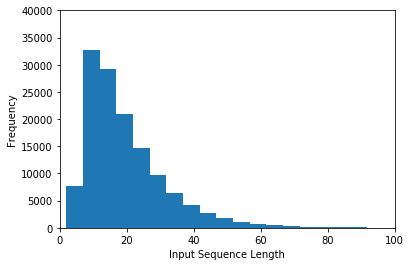

The total number of output is 133317
The total number of words in the output is 3281462
The average number of words in the output is 24.613980212576042
The maximum number of words in the output is 722


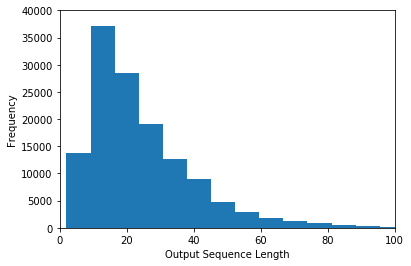

In [11]:
draw_train_diagram(train_pairs)

In [12]:
def short_sentences(pairs):
  """
  Hàm lọc ra các câu Anh - Việt trọn vẹn có độ dài từ 60 chữ trở xuống, dựa trên số liệu đã thống kê
  và giới hạn bộ nhớ của GPU dùng để huấn luyện
  
  Tham số:
    pairs: list các cặp câu Anh - Việt
    
  Returns:
    List các cặp câu Anh - Việt có độ dài từ 60 chữ trở xuống
  """
  
  result = []
  
  for i in range(len(pairs)):
    if len(pairs[i][0].split()) <= 60 and len(pairs[i][1].split()) <= 60:
      result.append([pairs[i][0], pairs[i][1]])
  
  return result

**Thống kê độ dài và số lượng câu trong tập các câu Anh - Việt có độ dài <= 60 chữ:**

In [13]:
short_train_pairs = short_sentences(train_pairs)

In [14]:
print_samples(short_train_pairs, 10)

<start> rachel pike the science behind a climate headline <end>
<start> khoa học đằng sau một tiêu đề về khí hậu <end>
<start> id like to talk to you today about the scale of the scientific effort that goes into making the headlines you see in the paper <end>
<start> tôi muốn cho các bạn biết về sự to lớn của những nỗ lực khoa học đã góp phần làm nên các dòng tít bạn thường thấy trên báo <end>
<start> headlines that look like this when they have to do with climate change and headlines that look like this when they have to do with air quality or smog <end>
<start> có những dòng trông như thế này khi bàn về biến đổi khí hậu và như thế này khi nói về chất lượng không khí hay khói bụi <end>
<start> they are both two branches of the same field of atmospheric science <end>
<start> cả hai đều là một nhánh của cùng một lĩnh vực trong ngành khoa học khí quyển <end>
<start> recently the headlines looked like this when the intergovernmental panel on climate change or ipcc put out their report on 

In [15]:
def draw_short_train_diagram(pairs):
  """
  Hàm thống kê độ dài và số lượng câu trong tập các câu Anh - Việt có độ dài <= 60 chữ và vẽ đồ thị
  
  Tham số:
    pairs: list các cặp câu Anh - Việt có độ dài <= 60 chữ
    
  Returns:
    None
  """
  
  num_words_input = []
  num_words_output = []
  
  for i in range(len(pairs)):
    num_words_input.append(len(pairs[i][0].split()))
    num_words_output.append(len(pairs[i][1].split()))
    
  print('The total number of input is', len(pairs))
  print('The total number of words in the input is', sum(num_words_input))
  print('The average number of words in the input is', sum(num_words_input)/len(num_words_input))
  print('The maximum number of words in the input is', max(num_words_input))
  
  %matplotlib inline
  plt.hist(num_words_input, 15)
  plt.xlabel('Input Sequence Length')
  plt.ylabel('Frequency')
  plt.axis([0, max(num_words_input), 0, 40000])
  plt.show()
  
  print('The total number of output is', len(pairs))
  print('The total number of words in the output is', sum(num_words_output))
  print('The average number of words in the output is', sum(num_words_output)/len(num_words_output))
  print('The maximum number of words in the output is', max(num_words_output))
  
  %matplotlib inline
  plt.hist(num_words_output, 15)
  plt.xlabel('Output Sequence Length')
  plt.ylabel('Frequency')
  plt.axis([0, max(num_words_output), 0, 40000])
  plt.show()

The total number of input is 128111
The total number of words in the input is 2273535
The average number of words in the input is 17.74660255559632
The maximum number of words in the input is 60


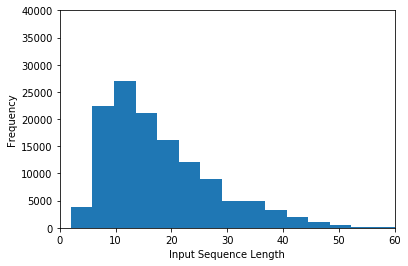

The total number of output is 128111
The total number of words in the output is 2865245
The average number of words in the output is 22.365331626480163
The maximum number of words in the output is 60


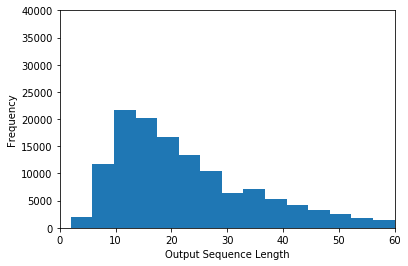

In [16]:
draw_short_train_diagram(short_train_pairs)

**Tạo tập Validation và chạy thử 10 câu Anh - Việt đầu tiên:**



In [17]:
val_pairs = create_dataset(validation_en, validation_vi)

In [18]:
print_samples(val_pairs, 10)

<start> how can i speak in 10 minutes about the bonds of women over three generations about how the astonishing strength of those bonds took hold in the life of a four year old girl huddled with her young sister her mother and her grandmother for five days and nights in a small boat in the china sea more than 30 years ago bonds that took hold in the life of that small girl and never let go that small girl now living in san francisco and speaking to you today <end>
<start> làm sao tôi có thể trình bày trong 10 phút về sợi dây liên kết những người phụ nữ qua ba thế hệ về việc làm thế nào những sợi dây mạnh mẽ đáng kinh ngạc ấy đã níu chặt lấy cuộc sống của một cô bé bốn tuổi co quắp với đứa em gái nhỏ của cô bé với mẹ và bà trong suốt năm ngày đêm trên con thuyền nhỏ lênh đênh trên biển đông hơn 30 năm trước những sợi dây liên kết đã níu lấy cuộc đời cô bé ấy và không bao giờ rời đi cô bé ấy giờ sống ở san francisco và đang nói chuyện với các bạn hôm nay <end>
<start> this is not a finis

**Thống kê độ dài và số lượng câu trong tập Validation:**

In [19]:
def draw_val_diagram(pairs):
  """
  Hàm thống kê độ dài và số lượng câu trong tập Validation Anh - Việt và vẽ đồ thị
  
  Tham số:
    pairs: list các cặp câu Anh - Việt
    
  Returns:
    None
  """
  
  num_words_input = []
  num_words_output = []
  
  for i in range(len(pairs)):
    num_words_input.append(len(pairs[i][0].split()))
    num_words_output.append(len(pairs[i][1].split()))
    
  print('The total number of input is', len(pairs))
  print('The total number of words in the input is', sum(num_words_input))
  print('The average number of words in the input is', sum(num_words_input)/len(num_words_input))
  print('The maximum number of words in the input is', max(num_words_input))
  
  %matplotlib inline
  plt.hist(num_words_input, 30)
  plt.xlabel('Input Sequence Length')
  plt.ylabel('Frequency')
  plt.axis([0, max(num_words_input), 0, 300])
  plt.show()
  
  print('The total number of output is', len(pairs))
  print('The total number of words in the output is', sum(num_words_output))
  print('The average number of words in the output is', sum(num_words_output)/len(num_words_output))
  print('The maximum number of words in the output is', max(num_words_output))
  
  %matplotlib inline
  plt.hist(num_words_output, 30)
  plt.xlabel('Output Sequence Length')
  plt.ylabel('Frequency')
  plt.axis([0, max(num_words_output), 0, 300])
  plt.show()

The total number of input is 1553
The total number of words in the input is 27276
The average number of words in the input is 17.56342562781713
The maximum number of words in the input is 92


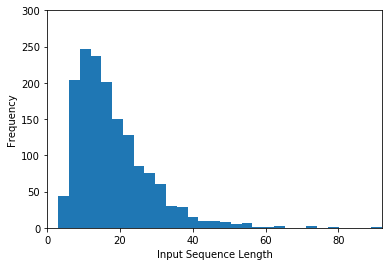

The total number of output is 1553
The total number of words in the output is 34631
The average number of words in the output is 22.2994204764971
The maximum number of words in the output is 119


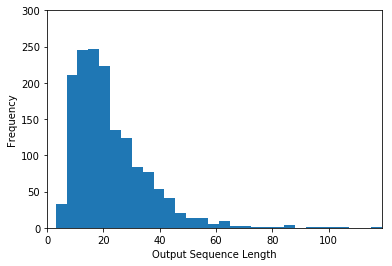

In [20]:
draw_val_diagram(val_pairs)

**Tạo tập Test và chạy thử 10 câu Anh - Việt đầu tiên:**


In [21]:
test_pairs = create_dataset(test_en, test_vi)

In [22]:
print_samples(test_pairs, 10)

<start> when i was little i thought my country was the best on the planet and i grew up singing a song called nothing to envy <end>
<start> khi tôi còn nhỏ tôi nghĩ rằng bắctriều tiên là đất nước tốt nhất trên thế giới và tôi thường hát bài chúng ta chẳng có gì phải ghen tị <end>
<start> and i was very proud <end>
<start> tôi đã rất tự hào về đất nước tôi <end>
<start> in school we spent a lot of time studying the history of kim il sung but we never learned much about the outside world except that america south korea japan are the enemies <end>
<start> ở trường chúng tôi dành rất nhiều thời gian để học về cuộc đời của chủ tịch kim ii sung nhưng lại không học nhiều về thế giới bên ngoài ngoại trừ việc hoa kỳ hàn quốc và nhật bản là kẻ thù của chúng tôi <end>
<start> although i often wondered about the outside world i thought i would spend my entire life in north korea until everything suddenly changed <end>
<start> mặc dù tôi đã từng tự hỏi không biết thế giới bên ngoài kia như thế nào 

**Thống kê độ dài và số lượng câu trong tập Test:**

In [23]:
def draw_test_diagram(pairs):
  """
  Hàm thống kê độ dài và số lượng câu trong tập Test Anh - Việt và vẽ đồ thị
  
  Tham số:
    pairs: list các cặp câu Anh - Việt
    
  Returns:
    None
  """
  
  num_words_input = []
  num_words_output = []
  
  for i in range(len(pairs)):
    num_words_input.append(len(pairs[i][0].split()))
    num_words_output.append(len(pairs[i][1].split()))
    
  print('The total number of input is', len(pairs))
  print('The total number of words in the input is', sum(num_words_input))
  print('The average number of words in the input is', sum(num_words_input)/len(num_words_input))
  print('The maximum number of words in the input is', max(num_words_input))
  
  %matplotlib inline
  plt.hist(num_words_input, 30)
  plt.xlabel('Input Sequence Length')
  plt.ylabel('Frequency')
  plt.axis([0, max(num_words_input), 0, 200])
  plt.show()
  
  print('The total number of output is', len(pairs))
  print('The total number of words in the output is', sum(num_words_output))
  print('The average number of words in the output is', sum(num_words_output)/len(num_words_output))
  print('The maximum number of words in the output is', max(num_words_output))
  
  %matplotlib inline
  plt.hist(num_words_output, 30)
  plt.xlabel('Output Sequence Length')
  plt.ylabel('Frequency')
  plt.axis([0, max(num_words_output), 0, 200])
  plt.show()

The total number of input is 1268
The total number of words in the input is 25523
The average number of words in the input is 20.128548895899055
The maximum number of words in the input is 95


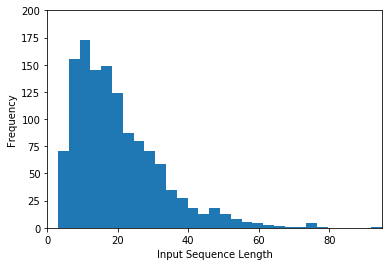

The total number of output is 1268
The total number of words in the output is 33169
The average number of words in the output is 26.15851735015773
The maximum number of words in the output is 120


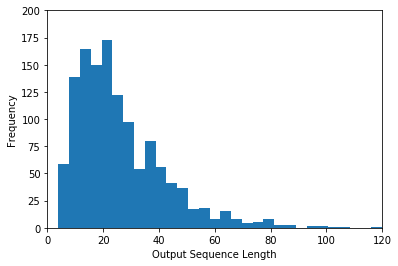

In [24]:
draw_test_diagram(test_pairs)

**Class LanguageIndex() chuyển từ chữ sang index và index sang chữ:**

In [25]:
# This class creates a word -> index mapping (e.g,. "dad" -> 5) and vice-versa 
# (e.g., 5 -> "dad") for each language,
class LanguageIndex():
  """
  Cập nhật vocab từ các câu của ngôn ngữ cần khởi tạo
  Tạo mapping chữ -> số hiệu ("dad" -> 5) và số hiệu -> chữ (5 -> "dad")
  """
  
  def __init__(self, lang):
    """
    Hàm khởi tạo
    
    Tham số:
      lang: ngôn ngữ cần khởi tạo
      
    Returns:
      None
    """
    
    self.lang = lang
    self.word2idx = {}
    self.idx2word = {}
    self.vocab = set()
    
    self.create_index()
    
  def create_index(self):
    """
    Cập nhật vocab từ các câu của ngôn ngữ cần khởi tạo
    Tạo mapping chữ -> số hiệu và số hiệu -> chữ
    """
    
    for phrase in self.lang:
      self.vocab.update(phrase.split())
    
    self.vocab = sorted(self.vocab)
    
    self.word2idx['<pad>'] = 0
    for index, word in enumerate(self.vocab):
      self.word2idx[word] = index + 1
    
    for word, index in self.word2idx.items():
      self.idx2word[index] = word

**Hàm load_train_dataset() chuyển các chữ trong các câu Tiếng Anh & Tiếng Việt của tập Train sang dạng index:**

In [26]:
def max_length(tensor):
    """
    Trả về câu dài nhất trong tensor
    
    Tham số:
      tensor: tensor của các câu
    """
    
    return max(len(t) for t in tensor)

In [27]:
def load_train_dataset(input_path, target_path):
  """
  Nhập dữ liệu đầu vào cho tập Train
  Cập nhật vocab của từng ngôn ngữ Anh, Việt
  Lọc ra những cặp câu Anh - Việt có độ dài <= 60 chữ (lựa chọn 60 chữ là dựa trên thống kê và giới hạn GPU)
  Tạo tensor chứa index của các cặp câu Anh - Việt trong tập Train
  Lấp đầy các câu ngắn bằng index 0
  
  Tham số:
    input_path: đường dẫn của tập câu Tiếng Anh
    target_path: đường dẫn của tập câu Tiếng Việt
    
  Returns:
    input_tensor: tensor index Tiếng Anh
    output_tensor: tensor index Tiếng Việt
    inp_lang: vocab Tiếng Anh
    targ_lang: vocab Tiếng Việt
    max_length_inp: độ dài lớn nhất trong tập câu Tiếng Anh
    max_length_tar: độ dài lớn nhất trong tập câu Tiếng Việt
    
  """
  
  # Nhập dữ liệu đầu vào cho tập Train
  pairs = create_dataset(input_path, target_path)
  
  # Cập nhật vocab của từng ngôn ngữ Anh, Việt
  inp_lang = LanguageIndex(en for en, vi in pairs)
  targ_lang = LanguageIndex(vi for en, vi in pairs)
  
  # Lọc ra những cặp câu Anh - Việt có độ dài <= 60 chữ
  pairs = short_sentences(pairs)

  # Chuyển các từ trong câu Tiếng Anh sang index
  input_tensor = [[inp_lang.word2idx[word] for word in en.split()] for en, vi in pairs]

  # Chuyển các từ trong câu Tiếng Việt sang index
  target_tensor = [[targ_lang.word2idx[word] for word in vi.split()] for en, vi in pairs]

  # Tính độ dài lớn nhất trong tập câu Tiếng Anh và Tiếng Việt
  max_length_inp, max_length_tar = max_length(input_tensor), max_length(target_tensor)

  # Lấp đầy các câu ngắn bằng index 0
  input_tensor = tf.keras.preprocessing.sequence.pad_sequences(input_tensor, maxlen=max_length_inp, padding='post')

  target_tensor = tf.keras.preprocessing.sequence.pad_sequences(target_tensor, maxlen=max_length_tar, padding='post')

  return input_tensor, target_tensor, inp_lang, targ_lang, max_length_inp, max_length_tar

**Tạo train_dataset:**

In [28]:
input_tensor_train, target_tensor_train, inp_lang, targ_lang, max_length_inp, max_length_targ = load_train_dataset(train_en, train_vi)

In [29]:
# In ra độ dài vocab của tập Tiếng Anh và Tiếng Việt
print(len(inp_lang.word2idx))
print(len(targ_lang.word2idx))

42916
19823


In [30]:
# In ra độ dài lớn nhất trong tập câu Tiếng Anh và Tiếng Việt
max_length_inp, max_length_targ

(60, 60)

In [31]:
# In ra câu đầu tiên trong tensor Tiếng Anh
input_tensor_train[0]

array([  804, 30734, 28670, 38331, 33653,  4190,   806,  7530, 17534,
         803,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0], dtype=int32)

In [32]:
# In ra câu đầu tiên trong tensor Tiếng Anh
target_tensor_train[0]

array([  966,  8810,  7882, 19586, 14950, 11495, 16976, 19606, 18357,
        8896,  7856,   965,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0], dtype=int32)

In [33]:
def load_val_dataset(input_path, target_path, inp_lang, targ_lang):
  """
  Nhập dữ liệu đầu vào cho tập Validation
  Tạo tensor chứa index của các cặp câu Anh - Việt trong tập Validation dựa trên vocab của tập Train
  Lấp đầy các câu ngắn bằng index 0
  
  Tham số:
    input_path: đường dẫn của tập câu Tiếng Anh
    target_path: đường dẫn của tập câu Tiếng Việt
    inp_lang: vocab Tiếng Anh của tập Train
    targ_lang: vocab Tiếng Việt của tập Train
    
  Returns:
    input_tensor: tensor index Tiếng Anh của tập Validation
    output_tensor: tensor index Tiếng Việt của tập Validation
    inp_lang: vocab Tiếng Anh
    targ_lang: vocab Tiếng Việt
    max_length_inp: độ dài lớn nhất trong tập câu Tiếng Anh
    max_length_tar: độ dài lớn nhất trong tập câu Tiếng Việt
    
  """
  
  # Nhập dữ liệu đầu vào cho tập Validation
  pairs = create_dataset(input_path, target_path)
  
  # Chuyển các từ trong câu Tiếng Anh và Tiếng Việt sang index dựa trên vocab của tập Train
  # Từ nào không có trong vocab của tập Train thì cho index = 0
  
  input_tensor = []
  target_tensor = []
  
  for en, vi in pairs:
    inputs = []
    for word in en.split():
      try:
        index = inp_lang.word2idx[word]
      except:
        index = 0
      inputs.append(index)
    input_tensor.append(inputs)
    
    targets = []
    for word in vi.split():
      try:
        index = targ_lang.word2idx[word]
      except:
        index = 0
      targets.append(index)
    target_tensor.append(targets)

  # Tính độ dài lớn nhất trong tập câu Tiếng Anh và Tiếng Việt
  max_length_inp, max_length_tar = max_length(input_tensor), max_length(target_tensor)

  # Lấp đầy các câu ngắn bằng index 0
  input_tensor = tf.keras.preprocessing.sequence.pad_sequences(input_tensor, maxlen=max_length_inp, padding='post')
  input_tensor = tf.convert_to_tensor(input_tensor)

  target_tensor = tf.keras.preprocessing.sequence.pad_sequences(target_tensor, maxlen=max_length_tar, padding='post')
  target_tensor = tf.convert_to_tensor(target_tensor)

  return input_tensor, target_tensor, inp_lang, targ_lang, max_length_inp, max_length_tar

In [34]:
input_tensor_val, target_tensor_val, inp_lang_val, targ_lang_val, max_length_inp_val, max_length_targ_val = load_val_dataset(validation_en, validation_vi, inp_lang, targ_lang)

In [35]:
# In ra độ dài lớn nhất trong các câu Tiếng Anh và Tiếng Việt của tập Validation
max_length_inp_val, max_length_targ_val

(92, 119)

In [36]:
input_tensor_val[0]

<tf.Tensor: id=5, shape=(92,), dtype=int32, numpy=
array([  804, 18358,  6189, 18660, 35762, 19091,    31, 24476,   905,
       38331,  5082, 26613, 42297, 27196, 38514, 15939,   905, 18358,
       38331,  3071, 36696, 26613, 38488,  5082, 38880, 18080, 19091,
       38331, 22206, 26613,   806, 15230, 42618, 26690, 16198, 18402,
       42227, 17762, 42717, 34929, 17762, 25034,  2173, 17762, 16615,
       15047, 14686, 10010,  2173, 26035, 19091,   806, 35229,  4976,
       19091, 38331,  7149, 33805, 24949, 38312,   487, 42627,  1578,
        5082, 38322, 38880, 18080, 19091, 38331, 22206, 26613, 38322,
       35229, 16198,  2173, 25905, 22068, 16361, 38322, 35229, 16198,
       26319, 22432, 19091, 33298, 15300,  2173, 35765, 38776, 42713,
       38791,   803], dtype=int32)>

In [37]:
target_tensor_val[0]

<tf.Tensor: id=10, shape=(119,), dtype=int32, numpy=
array([  966,  9937, 14910, 17635,  4380, 16837, 17285,  2833, 17219,
          32, 13409, 18357, 16181,  5159,  9691,  9309, 12266, 11922,
       13470, 12659, 13864,  1833, 16830,  7877, 18357, 18161,  9937,
       16830, 12497, 12266, 16181,  5159, 11412, 11450, 19440,  9039,
       11931, 19728, 19455, 12532,  3793, 10074,  4320, 16162,  4536,
       11495,  4387,  2859,  3029, 17527,  3971, 13981, 18389, 19674,
        5482,  6874, 12232,  4536,  4387,  2859, 18389, 11447, 18215,
        2827, 17219, 15979, 12553, 11872, 19467, 17280,  4067, 16672,
       12232,  9978, 19469, 17280,  2343, 19496,  7809,   553, 12553,
       17326, 12266, 16181,  5159,  9691,  9309, 19455, 12532, 10074,
        4320, 19660,  4387,  2859, 19728, 18215,  8910,  1955,  6550,
       14762, 19366,  4387,  2859, 19728,  6550, 16162, 19796, 14874,
        6025, 18215, 19352, 12537,  3630, 18389,  4345,  2936,  7788,
       11644,   965], dtype=int32)>

In [38]:
# Tổng kết số lượng cặp câu Anh-Việt của tập Train và tập Validation
len(input_tensor_train), len(target_tensor_train), len(input_tensor_val), len(target_tensor_val)

(128111, 128111, 1553, 1553)

# Chuẩn bị Train:

**Setup thông số:**

In [39]:
BUFFER_SIZE = len(input_tensor_train)
BATCH_SIZE = 256
N_BATCH = BUFFER_SIZE//BATCH_SIZE
embedding_dim = 256
units = 512
vocab_inp_size = len(inp_lang.word2idx)
vocab_tar_size = len(targ_lang.word2idx)

**Tạo các batch cho tập Train và tập Validation:**

In [40]:
train_dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train)).shuffle(BUFFER_SIZE)
train_dataset = train_dataset.batch(BATCH_SIZE, drop_remainder=True)

validation_dataset = tf.data.Dataset.from_tensor_slices((input_tensor_val, target_tensor_val)).shuffle(BUFFER_SIZE)
validation_dataset = validation_dataset.batch(BATCH_SIZE, drop_remainder=True)

**Setup encoder và decoder:**

In [41]:
def gru(units):
  """
  Hàm setup gru dựa trên điều kiện có GPU hay không
  
  Tham số:
    units: số lượng hidden units
  """
  
  if tf.test.is_gpu_available():
    return tf.keras.layers.CuDNNGRU(units, 
                                    return_sequences=True, 
                                    return_state=True, 
                                    recurrent_initializer='glorot_uniform')
  else:
    return tf.keras.layers.GRU(units, 
                               return_sequences=True, 
                               return_state=True, 
                               recurrent_activation='sigmoid', 
                               recurrent_initializer='glorot_uniform')

In [42]:
class Encoder(tf.keras.Model):
    """
    Encoder cho Tiếng Anh
    """
  
    def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
        """
        Hàm khởi tạo thông số cho encoder

        Tham số:
          vocab_size: kích cỡ vocab Tiếng Anh
          embedding_dim: kích cỡ word vector
          enc_units: số lượng hidden units
          batch_sz: kích cỡ 1 batch
        """
      
        super(Encoder, self).__init__()
        self.batch_sz = batch_sz
        self.enc_units = enc_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = gru(self.enc_units)
        
    def call(self, x, hidden):
        """
        Hàm chạy

        Returns:
          output, state: đầu ra của Encoder
        """
      
        x = self.embedding(x)
        output, state = self.gru(x, initial_state = hidden)        
        return output, state
    
    def initialize_hidden_state(self):
        """
        Hàm khởi tạo hidden state
        """
        return tf.zeros((self.batch_sz, self.enc_units))

In [43]:
class BahdanauAttention(tf.keras.Model):
  """
  Bahdanau Attention cho seq2seq Anh - Việt
  """
  
  def __init__(self, units):
    """
    Khởi tạo Attention
    
    Tham số:
      units: số lượng hiddden units của decoder
    """
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, query, values):
    # hidden shape == (batch_size, hidden size)
    # hidden_with_time_axis shape == (batch_size, 1, hidden size)
    # we are doing this to perform addition to calculate the score
    hidden_with_time_axis = tf.expand_dims(query, 1)

    # score shape == (batch_size, max_length, 1)
    # we get 1 at the last axis because we are applying score to self.V
    # the shape of the tensor before applying self.V is (batch_size, max_length, units)
    score = self.V(tf.nn.tanh(self.W1(values) + self.W2(hidden_with_time_axis)))

    # attention_weights shape == (batch_size, max_length, 1)
    attention_weights = tf.nn.softmax(score, axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * values
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

In [44]:
class LuongAttention(tf.keras.Model):
  """
  Lương Attention cho seq2seq Anh - Việt
  """

  def __init__(self, units):
    """
    Khởi tạo Attention
    
    Tham số:
      units: số lượng hiddden units của decoder
    """
    super(LuongAttention, self).__init__()
    self.W = tf.keras.layers.Dense(units)
  
  def call(self, query, values):
    # hidden shape == (batch_size, hidden size)
    # hidden_with_time_axis shape == (batch_size, 1, hidden size)
    # we are doing this to perform addition to calculate the score
    hidden_with_time_axis = tf.expand_dims(query, 1)

    # score shape == (batch_size, max_length, hidden_size)
    score = tf.matmul(values, self.W(hidden_with_time_axis), transpose_b=True)

    # attention_weights shape == (batch_size, max_length, 1)
    attention_weights = tf.nn.softmax(score, axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * values
    context_vector = tf.reduce_sum(context_vector, axis=1)
    
    return context_vector, attention_weights

In [45]:
class Decoder(tf.keras.Model):
    """
    Decoder cho Tiếng Việt
    """
  
    def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
      """
      Hàm khởi tạo thông số cho decoder
      
      Tham số:
        vocab_size: kích cỡ vocab Tiếng Việt
        embedding_dim: kích cỡ word vector
        dec_units: số lượng hidden units
        batch_sz: kích cỡ 1 batch
      """
      
      super(Decoder, self).__init__()
      self.batch_sz = batch_sz
      self.dec_units = dec_units
      self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
      self.gru = gru(self.dec_units)
      self.fc = tf.keras.layers.Dense(vocab_size)

      # used for attention
      self.attention = BahdanauAttention(self.dec_units)

    def call(self, x, hidden, enc_output):
      # enc_output shape == (batch_size, max_length, hidden_size)
      context_vector, attention_weights = self.attention(hidden, enc_output)

      # x shape after passing through embedding == (batch_size, 1, embedding_dim)
      x = self.embedding(x)

      # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
      x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

      # passing the concatenated vector to the GRU
      output, state = self.gru(x)

      # output shape == (batch_size * 1, hidden_size)
      output = tf.reshape(output, (-1, output.shape[2]))

      # output shape == (batch_size, vocab)
      x = self.fc(output)

      return x, state, attention_weights
        
    def initialize_hidden_state(self):
        """
        Hàm khởi tạo hidden state
        """
        return tf.zeros((self.batch_sz, self.dec_units))

In [46]:
encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)
decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)

**Setup optimizer và checkpoint:**

In [47]:
LEARNING_RATE = 0.001

In [48]:
optimizer = tf.train.AdamOptimizer(LEARNING_RATE)

In [49]:
def loss_function(real, pred):
  """
  Hàm tính loss giữa prediction và target
  """
  
  mask = 1 - np.equal(real, 0)
  loss_ = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=real, logits=pred) * mask
  
  return tf.reduce_mean(loss_)

In [50]:
global_step = tf.train.get_or_create_global_step()

checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

**Setup hàm huấn luyện tập Train:**

In [51]:
from fastprogress import master_bar, progress_bar

In [52]:
def epoch_training(encoder, decoder, dataset, global_step, mb, num_step):
    """
    Hàm huấn luyện trên tập Train

    Tham số:
      encoder: encoder Tiếng Anh
      decoder: decoder Tiếng Việt
      dataset: train datset
      global_step, mb, num_step: thông số vẽ đồ thị mô hình

    Returns:
      loss trung bình của 1 epoch
    """
  
    train_losses = [] # Chứa giá trị loss của các batch
    dataset_iter = iter(dataset)
    for _ in progress_bar(range(num_step), parent=mb):
        inp, targ = next(dataset_iter)
        loss = 0
        
        with tf.GradientTape() as tape:
            # Feedforward
            enc_output, enc_hidden = encoder(inp, hidden)
            
            dec_hidden = enc_hidden
            
            dec_input = tf.expand_dims([targ_lang.word2idx['<start>']] * BATCH_SIZE, 1)
            
            # Teacher forcing - feeding the target as the next input
            for t in range(1, targ.shape[1]):
                # passing enc_output to the decoder
                predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)
                
                loss += loss_function(targ[:, t], predictions)
                
                # using teacher forcing
                dec_input = tf.expand_dims(targ[:, t], 1)
                
            batch_loss = (loss / int(targ.shape[1]))
            
            train_losses.append(batch_loss)
        
        variables = encoder.variables + decoder.variables
        
        gradients = tape.gradient(loss, variables)
        
        optimizer.apply_gradients(zip(gradients, variables), global_step=global_step) 
        
        mb.child.comment = 'Train loss {:.4f}'.format(loss)
        
    return sum(train_losses)/ len(train_losses)

**Setup hàm đánh giá tập Validation:**

In [53]:
def epoch_evaluation(encoder, decoder, dataset, mb, num_step):
    """
    Hàm đánh giá trên tập Validation

    Tham số:
      encoder: encoder Tiếng Anh
      decoder: decoder Tiếng Việt
      dataset: validation datset
      global_step, mb, num_step: thông số vẽ đồ thị mô hình

    Returns:
      loss trung bình của 1 epoch
    """
  
    val_losses = [] # Chứa giá trị loss của các batch
    dataset_iter = iter(dataset)
    for _ in progress_bar(range(num_step), parent=mb):
        inp, targ = next(dataset_iter)
        loss = 0
        
        # Feed forward
        enc_output, enc_hidden = encoder(inp, hidden)
            
        dec_hidden = enc_hidden

        dec_input = tf.expand_dims([targ_lang.word2idx['<start>']] * BATCH_SIZE, 1)
        
        for t in range(1, targ.shape[1]):
            # passing enc_output to the decoder
            predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)

            loss += loss_function(targ[:, t], predictions)
            
            dec_input = tf.expand_dims(targ[:, t], 1)
            
        batch_loss = (loss / int(targ.shape[1]))
        
        val_losses.append(batch_loss)
        
        mb.child.comment = 'Validation loss {:.4f}'.format(loss)
    
    return sum(val_losses)/ len(val_losses)

# Train

Instructions for updating:
Colocations handled automatically by placer.


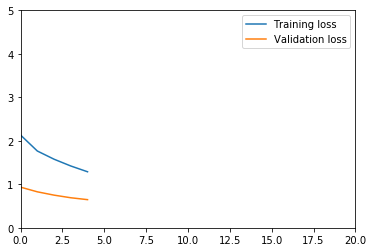

Finish train epoch 0 with loss 2.1328
Finish validate epoch 0 with loss 0.9346
Finish train epoch 1 with loss 1.7658
Finish validate epoch 1 with loss 0.8274
Finish train epoch 2 with loss 1.5772
Finish validate epoch 2 with loss 0.7510
Finish train epoch 3 with loss 1.4213
Finish validate epoch 3 with loss 0.6909
Finish train epoch 4 with loss 1.2885
Finish validate epoch 4 with loss 0.6473


In [54]:
EPOCHS = 20

mb = master_bar(range(EPOCHS))
mb.names = ['Training loss', 'Validation loss']
training_losses = []
validation_losses = []
x = []

train_step = math.floor(len(input_tensor_train)*1.0/BATCH_SIZE)
val_step = math.floor(len(input_tensor_val)*1.0/BATCH_SIZE)

for epoch in mb:
    
    # initializing the hidden state at the start of every epoch
    # initally hidden is None
    hidden = encoder.initialize_hidden_state()
    x.append(epoch)
    
    ### START CODE HERE
    # Training
    training_loss = epoch_training(encoder, decoder, train_dataset, global_step, mb, train_step)
    
    # Cập nhật thông tin sau khi huấn luyện
    training_losses.append(training_loss)
    
    # Validating
    valid_loss = epoch_evaluation(encoder, decoder, validation_dataset, mb, val_step)
    
    # Cập nhật thông tin sau khi validate
    validation_losses.append(valid_loss)
    
    # Cập nhật đồ thị
    global_step.assign_add(1)
    mb.update_graph([[x, training_losses], [x, validation_losses]], [0,EPOCHS], [0,5])
    
    print('Finish train epoch {} with loss {:.4f}'.format(epoch, training_loss))
    print('Finish validate epoch {} with loss {:.4f}'.format(epoch,valid_loss))
    
    # Update score và lưu model có score tốt nhất
    if (epoch + 1) % 2 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)
    ### END CODE HERE
    

In [55]:
# khôi phục checkpoint cuối cùng trong folder checkdir
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

# Đánh giá output

In [56]:
def evaluate(sentence, encoder, decoder, inp_lang, targ_lang, max_length_inp, max_length_targ):
    """
    Hàm dịch từng câu và tạo thông số ma trận tương quan attention giữa câu Tiếng Anh và câu Tiếng Việt

    Tham số:
      sentence: câu Tiếng Anh
      encoder: encoder Tiếng Anh
      decoder: decoder Tiếng Việt
      inp_lang: vocab Tiếng Anh
      targ_lang: vocab Tiếng Việt
      max_length_inp: độ dài lớn nhất câu Tiếng Anh
      max_length_targ: độ dài lớn nhất câu Tiếng Việt

    Returns:
      result: câu Tiếng Việt đã dịch
      sentence: câu Tiếng Anh đưa vào
      attention_plot: thống số để vẽ ma trận Attention
    """
  
    attention_plot = np.zeros((max_length_targ, max_length_inp))
    
    # Làm sạch câu Tiếng Anh
    sentence = preprocess_sentence(sentence)
    
    # Chuyển câu Tiếng Anh sang index
    inputs = []
    for word in sentence.split():
      try:
        index = inp_lang.word2idx[word]
      except:
        index = 0
      inputs.append(index)

    inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs], maxlen=max_length_inp, padding='post')
    inputs = tf.convert_to_tensor(inputs)
    
    # Dịch
    
    result = ''

    hidden = [tf.zeros((1, units))]
    enc_out, enc_hidden = encoder(inputs, hidden)

    dec_hidden = enc_hidden
    dec_input = tf.expand_dims([targ_lang.word2idx['<start>']], 0)

    for t in range(max_length_targ):
        predictions, dec_hidden, attention_weights = decoder(dec_input, dec_hidden, enc_out)
        
        # storing the attention weights to plot later on
        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention_plot[t] = attention_weights.numpy()

        predicted_id = tf.argmax(predictions[0]).numpy()

        result += targ_lang.idx2word[predicted_id]

        if targ_lang.idx2word[predicted_id] == '<end>':
            return result, sentence, attention_plot
        else:
          result += ' '
        
        # the predicted ID is fed back into the model
        dec_input = tf.expand_dims([predicted_id], 0)

    return result, sentence, attention_plot

In [57]:
# function for plotting the attention weights
def plot_attention(attention, sentence, predicted_sentence):
    """
    Hàm vẽ ma trận Attention

    Tham số:
      attention: thông số ma trận
      sentence: câu Tiếng Anh
      predicted_sentence: câu Tiếng Việt đã dịch

    Returns:
      None
    """
  
    fig = plt.figure(figsize=(5,5))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')
    
    fontdict = {'fontsize': 14}
    
    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

    plt.show()

In [58]:
def translate(sentence, encoder, decoder, inp_lang, targ_lang, max_length_inp, max_length_targ):
    """
    Hàm dịch và vẽ ma trận attention

    Tham số:
      sentence: câu Tiếng Anh
      encoder: encoder Tiếng Anh
      decoder: decoder Tiếng Việt
      inp_lang: vocab Tiếng Anh
      targ_lang: vocab Tiếng Việt
      max_length_inp: độ dài lớn nhất câu Tiếng Anh
      max_length_targ: độ dài lớn nhất câu Tiếng Việt

    Returns:
      None
    """
  
    result, sentence, attention_plot = evaluate(sentence, encoder, decoder, inp_lang, targ_lang, max_length_inp, max_length_targ)
        
    print('Input: {}'.format(sentence))
    print('Predicted translation: {}'.format(result))
    
    attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
    plot_attention(attention_plot, sentence.split(' '), result.split(' '))

# Dịch tập Test

Input: <start> i love you <end>
Predicted translation: tôi yêu bạn <end>


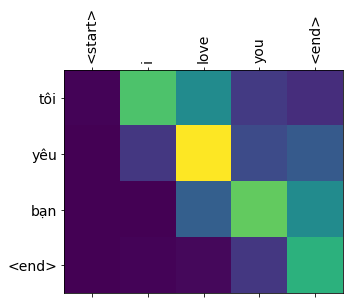

In [59]:
translate(u'i love you', encoder, decoder, inp_lang, targ_lang, max_length_inp, max_length_targ)

In [60]:
# Copyright 2017 Google Inc. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================

"""Python implementation of BLEU and smooth-BLEU.

This module provides a Python implementation of BLEU and smooth-BLEU.
Smooth BLEU is computed following the method outlined in the paper:
Chin-Yew Lin, Franz Josef Och. ORANGE: a method for evaluating automatic
evaluation metrics for machine translation. COLING 2004.
"""

import collections
import math


def _get_ngrams(segment, max_order):
  """Extracts all n-grams upto a given maximum order from an input segment.

  Args:
    segment: text segment from which n-grams will be extracted.
    max_order: maximum length in tokens of the n-grams returned by this
        methods.

  Returns:
    The Counter containing all n-grams upto max_order in segment
    with a count of how many times each n-gram occurred.
  """
  ngram_counts = collections.Counter()
  for order in range(1, max_order + 1):
    for i in range(0, len(segment) - order + 1):
      ngram = tuple(segment[i:i+order])
      ngram_counts[ngram] += 1
  return ngram_counts


def compute_bleu(reference_corpus, translation_corpus, max_order=4,
                 smooth=False):
  """Computes BLEU score of translated segments against one or more references.

  Args:
    reference_corpus: list of lists of references for each translation. Each
        reference should be tokenized into a list of tokens.
    translation_corpus: list of translations to score. Each translation
        should be tokenized into a list of tokens.
    max_order: Maximum n-gram order to use when computing BLEU score.
    smooth: Whether or not to apply Lin et al. 2004 smoothing.

  Returns:
    3-Tuple with the BLEU score, n-gram precisions, geometric mean of n-gram
    precisions and brevity penalty.
  """
  matches_by_order = [0] * max_order
  possible_matches_by_order = [0] * max_order
  reference_length = 0
  translation_length = 0
  for (references, translation) in zip(reference_corpus,
                                       translation_corpus):
    reference_length += min(len(r) for r in references)
    translation_length += len(translation)

    merged_ref_ngram_counts = collections.Counter()
    for reference in references:
      merged_ref_ngram_counts |= _get_ngrams(reference, max_order)
    translation_ngram_counts = _get_ngrams(translation, max_order)
    overlap = translation_ngram_counts & merged_ref_ngram_counts
    for ngram in overlap:
      matches_by_order[len(ngram)-1] += overlap[ngram]
    for order in range(1, max_order+1):
      possible_matches = len(translation) - order + 1
      if possible_matches > 0:
        possible_matches_by_order[order-1] += possible_matches

  precisions = [0] * max_order
  for i in range(0, max_order):
    if smooth:
      precisions[i] = ((matches_by_order[i] + 1.) /
                       (possible_matches_by_order[i] + 1.))
    else:
      if possible_matches_by_order[i] > 0:
        precisions[i] = (float(matches_by_order[i]) /
                         possible_matches_by_order[i])
      else:
        precisions[i] = 0.0

  if min(precisions) > 0:
    p_log_sum = sum((1. / max_order) * math.log(p) for p in precisions)
    geo_mean = math.exp(p_log_sum)
  else:
    geo_mean = 0

  ratio = float(translation_length) / reference_length

  if ratio > 1.0:
    bp = 1.
  else:
    bp = math.exp(1 - 1. / ratio)

  bleu = geo_mean * bp

  return (bleu, precisions, bp, ratio, translation_length, reference_length)

**Tạo tập Test:**

In [61]:
pairs_2 = create_dataset(test_en, test_vi)

**Dịch, tính bleu score và vẽ ma trận attention trên tập Test:**


Input:  <start> when i was little i thought my country was the best on the planet and i grew up singing a song called nothing to envy <end>
Groundtruth:  <start> khi tôi còn nhỏ tôi nghĩ rằng bắctriều tiên là đất nước tốt nhất trên thế giới và tôi thường hát bài chúng ta chẳng có gì phải ghen tị <end>
Translation:  <start> khi tôi nhỏ tôi nghĩ rằng đất nước tôi là người tốt nhất trên hành tinh và tôi lớn lên hát một bài hát được gọi là không có gì <end>
Bleu Score:  62.5

Input:  <start> and i was very proud <end>
Groundtruth:  <start> tôi đã rất tự hào về đất nước tôi <end>
Translation:  <start> và tôi rất tự hào <end>
Bleu Score:  48.404410457807934


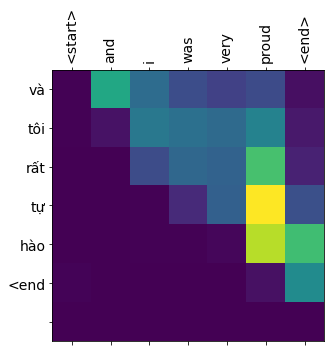


Input:  <start> in school we spent a lot of time studying the history of kim il sung but we never learned much about the outside world except that america south korea japan are the enemies <end>
Groundtruth:  <start> ở trường chúng tôi dành rất nhiều thời gian để học về cuộc đời của chủ tịch kim ii sung nhưng lại không học nhiều về thế giới bên ngoài ngoại trừ việc hoa kỳ hàn quốc và nhật bản là kẻ thù của chúng tôi <end>
Translation:  <start> trong trường học chúng tôi đã dành nhiều thời gian nghiên cứu lịch sử của các kim jong il nhưng chúng tôi chưa bao giờ học được nhiều về thế giới ngoài ngoại trừ ngoại trừ phi nam phi nhật bản là kẻ thù <end>
Bleu Score:  58.27977023024927

Input:  <start> although i often wondered about the outside world i thought i would spend my entire life in north korea until everything suddenly changed <end>
Groundtruth:  <start> mặc dù tôi đã từng tự hỏi không biết thế giới bên ngoài kia như thế nào nhưng tôi vẫn nghĩ rằng mình sẽ sống cả cuộc đời ở bắctr

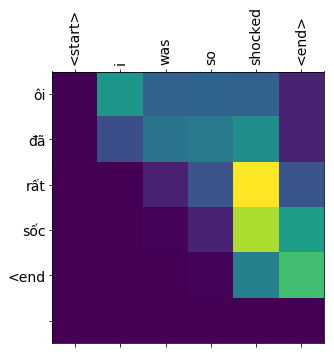


Input:  <start> this was the first time i heard that people in my country were suffering <end>
Groundtruth:  <start> vì đó là lần đầu tiên tôi biết rằng đồng bào của tôi đang phải chịu đựng như vậy <end>
Translation:  <start> đây là lần đầu tiên tôi đã nghe người ta ở mỹ tôi đã phải chịu đựng <end>
Bleu Score:  52.11033625670976

Input:  <start> soon after when i was walking past a train station i saw something terrible that i cant erase from my memory <end>
Groundtruth:  <start> không lâu sau đó khi tôi đi qua một nhà ga tôi nhìn thấy một cảnh tượng kinh hoàng mà tôi không bao giờ có thể quên <end>
Translation:  <start> ngay sau khi tôi đi bộ qua tàu hoả tôi thấy một điều khủng khiếp mà tôi không bao giờ bị mất từ trí nhớ <end>
Bleu Score:  51.5890503273989

Input:  <start> a lifeless woman was lying on the ground while an emaciated child in her arms just stared helplessly at his mothers face <end>
Groundtruth:  <start> trên nền nhà ga là xác chết của một người đàn bà hai tay vẫn đan

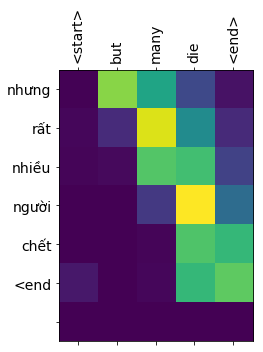


Input:  <start> sometimes i saw dead bodies floating down the river <end>
Groundtruth:  <start> và tôi đã nhìn thấy xác họ nổi trên sông <end>
Translation:  <start> đôi khi tôi thấy được cơ thể thấy được những con cơ thể đi qua sông <end>
Bleu Score:  27.77777777777778

Input:  <start> i cant reveal many details 91 about 93 how i left north korea but i only can say that during the ugly years of the famine i was sent to china to live with distant relatives <end>
Groundtruth:  <start> tôi không thể nói cụ thể về việc mình đã trốn khỏi bắc triều tiên như thế nào chỉ có thể nói rằng trong những năm tháng khốn khó vì nạn đói ấy tôi được gửi sang trung quốc để sống với một người họ hàng xa <end>
Translation:  <start> tôi không thể tiết lộ nhiều chi tiết về việc tôi rời khỏi bắc triều tiên nhưng tôi chỉ có thể nói rằng trong suốt những năm khủng hoảng năng lượng tôi đã gửi tới trung quốc để sống với những người nhật <end>
Bleu Score:  56.930049787646375

Input:  <start> but i only thought th

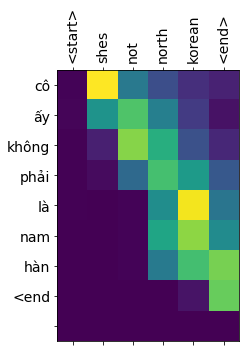


Input:  <start> and they let me go it was a miracle <end>
Groundtruth:  <start> và họ thả tôi ra đó quả là một phép màu <end>
Translation:  <start> và họ cho tôi đi một điều kì diệu <end>
Bleu Score:  45.47743189500984

Input:  <start> some north koreans in china seek asylum in foreign embassies but many can be caught by the chinese police and repatriated <end>
Groundtruth:  <start> một số người bắc triều tiên ở trung quốc đã đến những đại sứ quán của nước ngoài để xin tị nạn nhưng rất nhiều trong số đó đã bị bắt bởi cảnh sát trung quốc và bị trả về nước <end>
Translation:  <start> một người dân chủ đề ở trung quốc đang tìm kiếm ở trung tâm nước ngoài đại sứ quán mỹ nhưng có thể bị bắt bởi cảnh sát trung quốc và những người trung quốc <end>
Bleu Score:  50.558574971386236

Input:  <start> these girls were so lucky <end>
Groundtruth:  <start> những cô gái này đã rất may mắn <end>
Translation:  <start> những cô gái này rất may mắn <end>
Bleu Score:  89.48393168143697


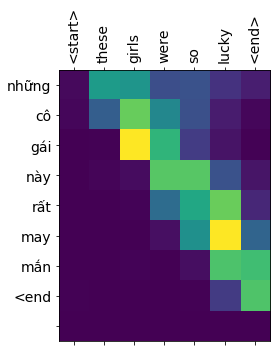


Input:  <start> even though they were caught they were eventually released after heavy international pressure <end>
Groundtruth:  <start> vì mặc dù đã bị bắt nhưng cuối cùng học cũng được thả ra nhờ vào sức ép từ cộng đồng quốc tế <end>
Translation:  <start> mặc dù họ bị bắt đầu họ đã được thả ra sau khi áp lực rất lớn <end>
Bleu Score:  38.37962908027552

Input:  <start> these north koreans were not so lucky <end>
Groundtruth:  <start> nhưng những người bắc triều tiên này thì không được may mắn như vậy <end>
Translation:  <start> người hàn quốc này không phải là may mắn <end>
Bleu Score:  40.39231756892703

Input:  <start> every year countless north koreans are caught in china and repatriated to north korea where they can be tortured imprisoned or publicly executed <end>
Groundtruth:  <start> hàng năm có vô số người bắc triều tiên bị bắt ở trung quốc và bị trả về nước nơi mà họ bị tra tấn bị giam cầm hoặc bị xử tử công khai <end>
Translation:  <start> mỗi năm trung quốc đang được bắt

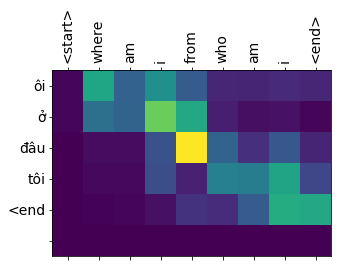


Input:  <start> suddenly there was no country i could proudly call my own <end>
Groundtruth:  <start> bỗng nhiên tôi chẳng có một đất nước nào để có thể tự hào gọi là tổ quốc <end>
Translation:  <start> bỗng dưng không có nước tôi có thể tự hào tôi <end>
Bleu Score:  44.89580601104417

Input:  <start> even though adjusting to life in south korea was not easy i made a plan <end>
Groundtruth:  <start> mặc dù để thích ứng với cuộc sống ở hàn quốc thì không dễ chút nào nhưng tôi đã lập một kế hoạch <end>
Translation:  <start> mặc dù cố gắng để sống trong lĩnh vực hàn quốc không thể tôi đã làm một kế hoạch <end>
Bleu Score:  55.104362508282534

Input:  <start> i started studying for the university entrance exam <end>
Groundtruth:  <start> và bắt đầu học để chuẩn bị cho kì thi đại học <end>
Translation:  <start> tôi bắt đầu nghiên cứu đại học vào buổi kiểm tra <end>
Bleu Score:  42.736665168106896

Input:  <start> just as i was starting to get used to my new life i received a shocking phone

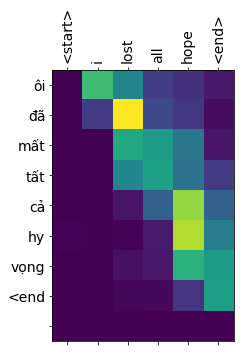


Input:  <start> at that moment i heard one mans voice ask me whats wrong <end>
Groundtruth:  <start> đúng vào lúc đó có một người đàn ông đã hỏi tôi có chuyện gì vậy <end>
Translation:  <start> trong khoảnh khắc đó tôi nghe một giọng nói của tôi hỏi tôi sai <end>
Bleu Score:  33.09363384692233

Input:  <start> i was so surprised that a total stranger cared enough to ask <end>
Groundtruth:  <start> tôi vô cùng ngạc nhiên khi một người hoàn toàn xa lạ lại quan tâm tới mức hỏi tôi như vậy <end>
Translation:  <start> tôi ngạc nhiên là một người lạ thường được yêu cầu <end>
Bleu Score:  28.515038106533865

Input:  <start> in my broken english and with a dictionary i explained the situation and without hesitating the man went to the atm and he paid the rest of the money for my family and two other north koreans to get out of jail <end>
Groundtruth:  <start> bằng vốn tiếng anh ít ỏi của mình và một quyển từ điển tôi đã kể cho cho ông ta nghe hoàn cảnh của gia đình tôi không một chút do dự ng

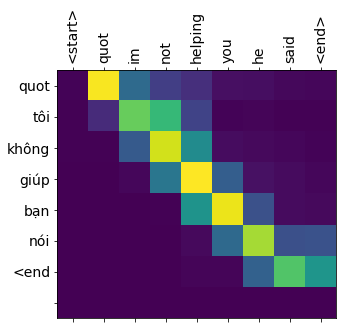


Input:  <start> quot im helping the north korean people <end>
Groundtruth:  <start> quot tôi đang giúp người bắc triều tiên <end>
Translation:  <start> quot tôi đang giúp người nga người dân tộc <end>
Bleu Score:  63.63636363636363

Input:  <start> i realized that this was a symbolic moment in my life <end>
Groundtruth:  <start> tôi nhận ra rằng đó là một khoảng khắc có ý nghĩa vô cùng to lớn trong cuộc đời tôi <end>
Translation:  <start> tôi nhận ra rằng đây là một khoảnh khắc chính trong thời đại của tôi <end>
Bleu Score:  48.21809992440168

Input:  <start> the kind stranger symbolized new hope for me and the north korean people when we needed it most and he showed me the kindness of strangers and the support of the international community are truly the rays of hope we north korean people need <end>
Groundtruth:  <start> lòng tốt từ người đàn ông xa lạ trở thành biểu tượng hy vọng mới cho tôi và cả những người dân bắc triều tiên khi mà chúng tôi đang rất cần nó và ông ta đã cho tôi 

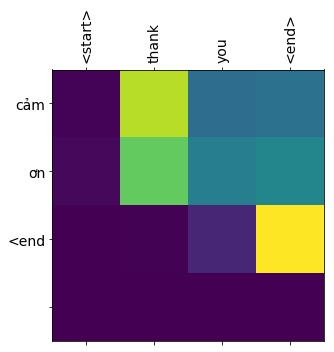


Input:  <start> today i have just one request <end>
Groundtruth:  <start> hôm nay tôi chỉ có một yêu cầu mà thôi <end>
Translation:  <start> hôm nay tôi chỉ cần phải yêu cầu <end>
Bleu Score:  65.49846024623855


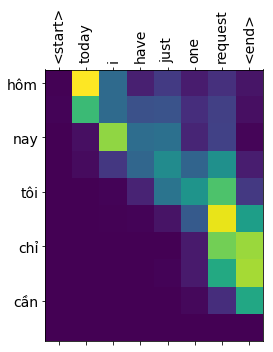


Input:  <start> please dont tell me im normal <end>
Groundtruth:  <start> xin đừng nói với tôi rằng tôi bình thường <end>
Translation:  <start> xin đừng nói với tôi tôi bình thường <end>
Bleu Score:  90.48374180359595


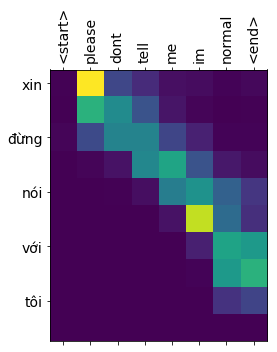


Input:  <start> now id like to introduce you to my brothers <end>
Groundtruth:  <start> bây giờ tôi muốn giới thiệu các bạn với những người em trai của tôi <end>
Translation:  <start> giờ tôi muốn giới thiệu với các bạn đến nhà bạn <end>
Bleu Score:  56.54934466089882

Input:  <start> remi is 22 tall and very handsome <end>
Groundtruth:  <start> remi 22 tuổi cao ráo và rất đẹp trai <end>
Translation:  <start> có phải là 22 người cao và rất đẹp <end>
Bleu Score:  63.63636363636363

Input:  <start> hes speechless but he communicates joy in a way that some of the best orators cannot <end>
Groundtruth:  <start> em không nói được nhưng em truyền đạt niềm vui theo cách mà ngay cả một số nhà hùng biện giỏi nhất cũng không thể làm được <end>
Translation:  <start> anh ta trả lời nhưng ông ấy giao tiếp với một cách nào đó một trong những điều tốt nhất <end>
Bleu Score:  19.840104791571363

Input:  <start> remi knows what love is <end>
Groundtruth:  <start> remi biết tình yêu là gì <end>
Transla

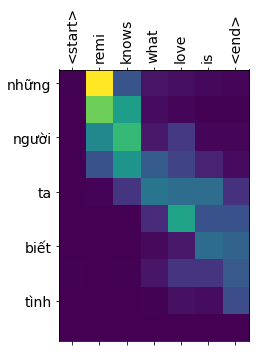


Input:  <start> he shares it unconditionally and he shares it regardless <end>
Groundtruth:  <start> em chia sẻ nó một cách vô điều kiện dù bất kể ra sao chăng nữa <end>
Translation:  <start> ông ấy đã chia sẻ nó và ông chia sẻ điều đó <end>
Bleu Score:  32.206169703226536

Input:  <start> hes not greedy he doesnt see skin color <end>
Groundtruth:  <start> em ấy không tham lam em không phân biệt màu da <end>
Translation:  <start> anh ta không phải là tham chiến là ông ta không nhìn thấy da màu <end>
Bleu Score:  41.17647058823529

Input:  <start> he doesnt care about religious differences and get this he has never told a lie <end>
Groundtruth:  <start> em không quan tâm về sự khác biệt tôn giáo và hãy hiểu rằng em ấy chưa từng nói dối <end>
Translation:  <start> ông ấy không quan tâm đến những người khác biệt và nhận được ông ấy chưa bao giờ nói gì <end>
Bleu Score:  50.0

Input:  <start> when he sings songs from our childhood attempting words that not even i could remember he reminds

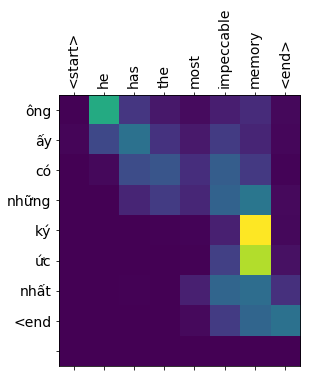


Input:  <start> he has a selective one though <end>
Groundtruth:  <start> nhưng cũng là có chọn lọc <end>
Translation:  <start> ông ấy có một loại chọn một loại bỏ <end>
Bleu Score:  36.36363636363637

Input:  <start> he doesnt remember if he stole my chocolate bar but he remembers the year of release for every song on my ipod conversations we had when he was four weeing on my arm on the first ever episode of teletubbies and lady gagas birthday <end>
Groundtruth:  <start> em không nhớ liệu em có xoáy thanh kẹo sô cô la của tôi không nhưng em lại nhớ năm phát hành của từng bài hát trên ipod của tôi các cuộc nói chuyện giữa chúng tôi từ em mới bốn tuổi tè lên tay của tôi vào ngày teletubbies lên sóng tập đầu tiên và sinh nhật của lady gaga <end>
Translation:  <start> ông ấy không nhớ là anh ta cướp đi sô cô la tôi nhưng ông nhớ lại năm cho những bài hát trên ghế sofa tôi có khi ông ta có bốn tuổi <end>
Bleu Score:  24.39214376636346

Input:  <start> dont they sound incredible <end>
Grou

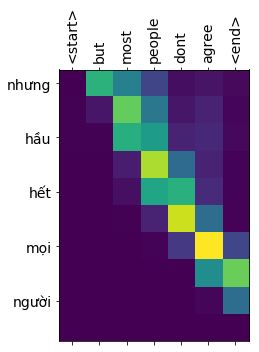


Input:  <start> and in fact because their minds dont fit into societys version of normal theyre often bypassed and misunderstood <end>
Groundtruth:  <start> và thực tế là vì tâm trí của các em tôi không phù hợp với phiên bản xã hội bình thường các em thường bị cho qua và hiểu lầm <end>
Translation:  <start> và thực tế vì họ là không có được một phiên bản của họ bình thường họ thường xuyên mặt nạ bỏ qua <end>
Bleu Score:  45.347024487343525

Input:  <start> but what lifted my heart and strengthened my soul was that even though this was the case although they were not seen as ordinary this could only mean one thing that they were extraordinary autistic and extraordinary <end>
Groundtruth:  <start> nhưng điều khiến trái tim tôi nhẹ nhõm hơn và tâm hồn tôi mạnh mẽ hơn là rằng mặc dù điều này là đúng dù các em không được coi là bình thường điều này chỉ có thể có nghĩa rằng các em thật phi thường người tự kỉ và người phi thường <end>
Translation:  <start> nhưng điều mà nâng cấp tim tôi tăng

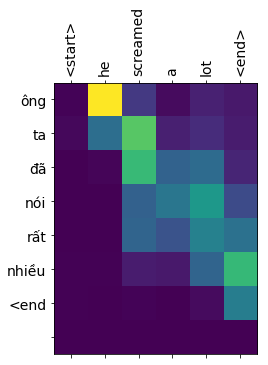


Input:  <start> he didnt want to play like the other babies did and in fact he didnt seem very interested in me whatsoever <end>
Groundtruth:  <start> em không muốn chơi đùa như các em bé khác và trong thực tế em có vẻ chẳng thích thú gì đến tôi hay điều gì khác hết <end>
Translation:  <start> ông ấy không muốn chơi nhạc như thế này những đứa trẻ khác và thực tế ông ấy không thích thú với tôi <end>
Bleu Score:  42.57399916005506

Input:  <start> remi lived and reigned in his own world with his own rules and he found pleasure in the smallest things like lining up cars around the room and staring at the washing machine and eating anything that came in between <end>
Groundtruth:  <start> remi sống và ngự trị trong thế giới của riêng mình với quy tắc riêng của mình và em thấy niềm vui trong những điều nhỏ nhặt nhất như là xếp ô tô quanh phòng và nhìn chằm chằm vào cái máy giặt và ăn bất cứ thứ gì trong tầm tay <end>
Translation:  <start> những người ta sống và có thể hiện tại và thế giới 

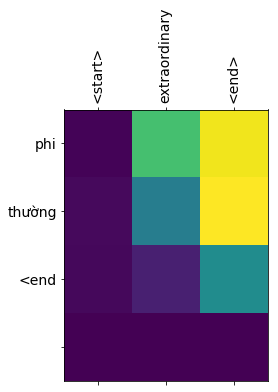


Input:  <start> now i cannot deny that there have been some challenging moments in my family moments where ive wished that they were just like me <end>
Groundtruth:  <start> chà tôi không thể phủ nhận rằng đã có một vài khoảnh khắc khó khăn trong gia đình tôi những khoảnh khắc tôi ước ao các em cũng giống như mình <end>
Translation:  <start> bây giờ tôi không thể chối bỏ lại có những thách thức khó khăn trong gia đình tôi có lẽ ước muốn chúng giống như tôi <end>
Bleu Score:  50.785332942788266

Input:  <start> but i cast my mind back to the things that theyve taught me about individuality and communication and love and i realize that these are things that i wouldnt want to change with normality <end>
Groundtruth:  <start> nhưng tôi đưa kí ức mình quay trở lại những điều các em đã dạy tôi về tính cách lối giao tiếp và tình yêu và tôi nhận ra rằng đây là những điều mà tôi sẽ chẳng đánh đổi để lấy sự bình thường <end>
Translation:  <start> nhưng tôi nhớ về những suy nghĩ về những điều mà

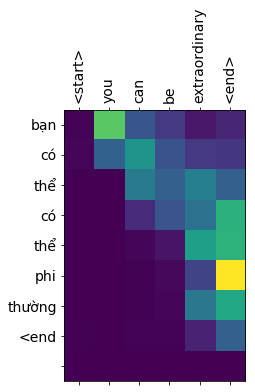


Input:  <start> because autistic or not the differences that we have weve got a gift everyones got a gift inside of us and in all honesty the pursuit of normality is the ultimate sacrifice of potential <end>
Groundtruth:  <start> vì có mắc chứng tự kỷ hay không sự khác biệt giữa chúng ta chúng ta có một món quà ai cũng mang trong mình một món quà và thật lòng mà nói theo đuổi cái bình thường chính là hi sinh tiềm năng lớn nhất <end>
Translation:  <start> bởi vì bị tự kỉ hoặc không có sự khác biệt mà chúng ta đã có một món quà có một món quà có thể làm món quà có thể làm món quà có thể làm món quà có thể làm món quà có thể làm món quà có thể làm món quà có thể làm món quà có thể
Bleu Score:  29.508196721311474

Input:  <start> the chance for greatness for progress and for change dies the moment we try to be like someone else <end>
Groundtruth:  <start> cơ hội cho sự vĩ đại tiến bộ và cho sự thay đổi bị dập tắt khi ta cố gắng trở nên giống như một người khác <end>
Translation:  <start> 

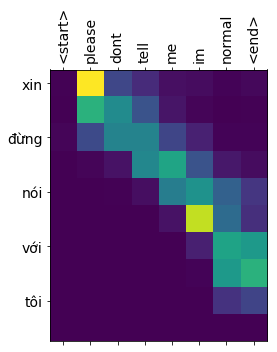


Input:  <start> thank you <end>
Groundtruth:  <start> cảm ơn bạn <end>
Translation:  <start> cảm ơn <end>
Bleu Score:  77.8800783071405


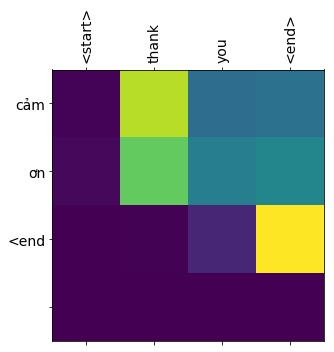


Input:  <start> you probably all agree with me that this is a very nice road <end>
Groundtruth:  <start> có lẽ các bạn đều đồng ý với tôi đây là một con đường rất đẹp <end>
Translation:  <start> bạn có thể tất cả đều đồng ý với tôi rằng đây là một con đường tốt đẹp <end>
Bleu Score:  75.0

Input:  <start> its made of asphalt and asphalt is a very nice material to drive on but not always especially not on these days as today when its raining a lot <end>
Groundtruth:  <start> nó được xây dựng từ nhựa đường và nhựa đường là loại vật liệu xe mà chạy trên nó thì rất êm nhưng không phải lúc nào cũng được vậy đặc biệt không phải vào những ngày này như hôm nay khi trời đang mưa nhiều <end>
Translation:  <start> nó được làm bằng nhựa đường nhựa đường là một vật liệu tốt để lái xe nhưng không phải là không tốt nhất trong ngày nay khi đó là như vậy là mưa như vậy là mưa như vậy là mưa như vậy là mưa như vậy là mưa như vậy là mưa như vậy là mưa như vậy là
Bleu Score:  34.42622950819672

Input:  <

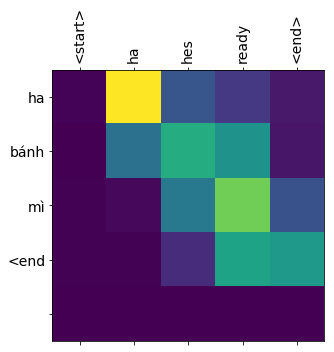


Input:  <start> potholes of course that can become a problem but we have a solution <end>
Groundtruth:  <start> ổ gà đương nhiên có thể trở thành một vấn đề nhưng chúng tôi có giải pháp <end>
Translation:  <start> bãi cỏ dĩ nhiên điều này có thể trở thành một vấn đề nhưng chúng ta có một giải pháp <end>
Bleu Score:  68.18181818181817

Input:  <start> here you see actually how the damage appears in this material <end>
Groundtruth:  <start> thật sự như bạn thấy ở đây vật liệu này có dấu hiệu bị hư hại ra sao <end>
Translation:  <start> đây bạn thấy đấy tác động như thế này đã xảy ra trong vật liệu này <end>
Bleu Score:  49.71329537857609

Input:  <start> its a porous asphalt like i said so you have only a small amount of binder between the stones <end>
Groundtruth:  <start> nó là nhựa xốp như tôi đã nói bạn chỉ có một lượng nhỏ keo dính bám giữa các viên đá <end>
Translation:  <start> nó là một loại nhựa đường như tôi đã nói với bạn có một loạt chất dính trộn giữa các mỏ <end>
Bleu Scor

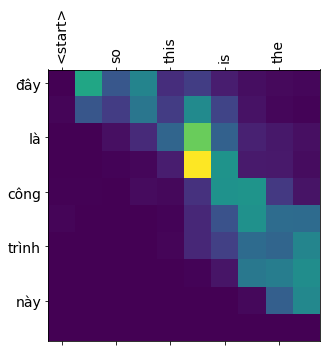


Input:  <start> so i said we have such an industrial machine in the lab to heat up the specimens <end>
Groundtruth:  <start> tôi đã nói chúng tôi phát minh ra một cái máy công nghiệp như trên tại phòng thí nghiệm để đun nóng các vật mẫu <end>
Translation:  <start> tôi nói chúng ta có một thiết bị công nghiệp trong phòng thí nghiệm để làm việc với các mẫu vật <end>
Bleu Score:  54.80673718244987

Input:  <start> we tested a lot of specimens there and then the government they actually saw our results and they thought well thats very interesting we have to try that <end>
Groundtruth:  <start> tại phòng thí nghiệm chúng tôi đã thử qua nhiều mẫu và rồi chính phủ họ đã thực sự nhìn thấy kết quả và họ cho rằng à cách đó hay lắm chúng ta phải thử xem sao <end>
Translation:  <start> chúng tôi đã thử nghiệm rất nhiều mẫu adn và sau đó chính phủ họ đã thấy sự kết quả của chúng tôi đã thấy kết quả của họ và họ nghĩ rằng chúng tôi thật sự thú vị chúng ta phải cố gắng làm <end>
Bleu Score:  53.1914

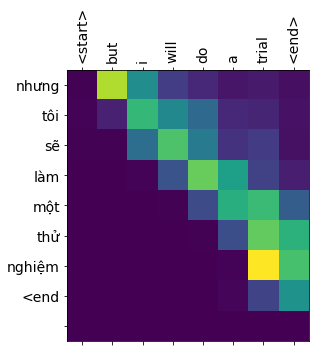


Input:  <start> lets see yeah it worked <end>
Groundtruth:  <start> xem nè vâng nó dính <end>
Translation:  <start> hãy xem có vẻ như vậy <end>
Bleu Score:  37.5


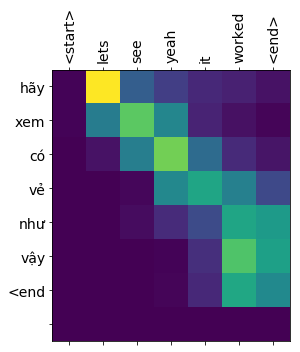


Input:  <start> thank you <end>
Groundtruth:  <start> xin cám ơn <end>
Translation:  <start> cảm ơn <end>
Bleu Score:  58.41005873035536


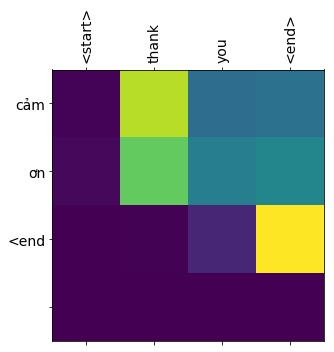


Input:  <start> im here today to talk about a disturbing question which has an equally disturbing answer <end>
Groundtruth:  <start> hôm nay tôi đến đây để nói về một câu hỏi bối rối mà câu trả lời cũng gấy bối rối không kém <end>
Translation:  <start> hôm nay tôi sẽ nói về một câu hỏi một câu hỏi một cách dễ chịu đựng một câu trả lời một câu trả lời một câu trả lời một câu trả lời một câu trả lời một câu trả lời một câu trả lời một câu trả lời một câu trả lời một câu trả lời một câu trả
Bleu Score:  19.672131147540984

Input:  <start> my topic is the secrets of domestic violence and the question im going to tackle is the one question everyone always asks why does she stay <end>
Groundtruth:  <start> chủ đề là bí mật của bạo lực gia đình và câu hỏi tôi đặt ra là câu hỏi mà mọi người luôn thắc mắc tại sao cô ấy ở lại <end>
Translation:  <start> chủ đề của tôi là bí mật của bạo lực và những câu hỏi tôi sẽ giải quyết vấn đề là một câu hỏi mọi người luôn hỏi tại sao cô ấy lại ở đâu <end>


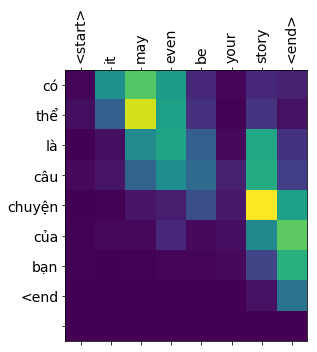


Input:  <start> i dont look like a typical domestic violence survivor <end>
Groundtruth:  <start> tôi không giống môt nhà tư vấn bạo lực gia đình <end>
Translation:  <start> tôi không nhìn như một nạn buôn bán bất bình đẳng gia đình <end>
Bleu Score:  40.0

Input:  <start> i have a b a in english from harvard college an mba in marketing from wharton business school <end>
Groundtruth:  <start> tôi có bằng cử nhân tiếng anh từ trường cao đẳng harvard và quản trị kinh doanh marketing từ trường kinh doanh wharton <end>
Translation:  <start> tôi có một tờ b có tiếng anh từ đại học harvard từ đại học ở quảng cáo trường kinh doanh <end>
Bleu Score:  47.828710540460165

Input:  <start> ive spent most of my career working for fortune 500 companies including johnson amp amp johnson leo burnett and the washington post <end>
Groundtruth:  <start> tôi đã dàng hết sự nghiệp làm việc cho những công ty trong top 500 của mỹ như johnson amp amp johnson leo burnett và thời báo washington <end>
Translati

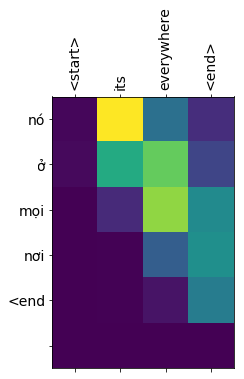


Input:  <start> and my second message is that everyone thinks domestic violence happens to women that its a womens issue <end>
Groundtruth:  <start> và điều thứ hai tôi muốn nói là mọi người nghĩ rằng bạo lực gia đình xảy ra với phụ nữ đó là vấn đề của phụ nữ <end>
Translation:  <start> và thứ hai thông điệp của tôi là mọi người nghĩ rằng bạo lực của những phụ nữ là một vấn đề về phụ nữ <end>
Bleu Score:  69.59861353000653

Input:  <start> not exactly <end>
Groundtruth:  <start> không đúng <end>
Translation:  <start> không phải là gì <end>
Bleu Score:  50.0


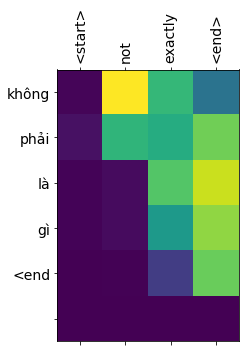


Input:  <start> over 85 percent of abusers are men and domestic abuse happens only in intimate interdependent long term relationships in other words in families the last place we would want or expect to find violence which is one reason domestic abuse is so confusing <end>
Groundtruth:  <start> hơn 85 phần trăm kẻ bạo hành là đàn ông và bạo lực gia đình xảy ra chỉ trong những mối quan hệ thân thiết ràng buộc lâu dài nói cách khác là trong gia đình nơi cuối cùng chúng ta mong muốn hoặc trông chờ tìn thấy bạo lực đó là một lí do khiến bạo hành gia đình là vấn đề gây bối rối <end>
Translation:  <start> hơn 85 trong rừng đánh đập cánh đồng quê và đàn áp và thậm chí chỉ có xu hướng phụ thuộc lẫn nhau hơn trong những từ những người khác trong khi chúng ta muốn được coi là bạo lực <end>
Bleu Score:  21.794688486791735

Input:  <start> i would have told you myself that i was the last person on earth who would stay with a man who beats me but in fact i was a very typical victim because of my a

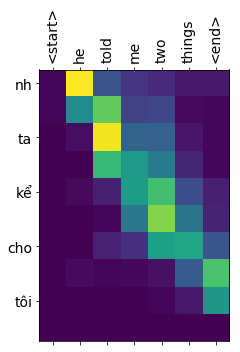


Input:  <start> one was that he too had just graduated from an ivy league school and that he worked at a very impressive wall street bank <end>
Groundtruth:  <start> một là anh ta cũng như tôi vừa tốt nghiệp trường ivy league và rằng anh ta làm việc tại một ngân hàng rất ấn tượng ở phố wall <end>
Translation:  <start> một là ông ấy đã tốt nghiệp từ một máng 7 giờ và ông ấy đã làm việc rất ấn tượng đường phố wall <end>
Bleu Score:  47.59920963349246

Input:  <start> but what made the biggest impression on me that first meeting was that he was smart and funny and he looked like a farm boy <end>
Groundtruth:  <start> nhưng điều gây ấn tương nhất với tôi ở cuộc gặp gỡ đầu tiên là anh ta thông minh là vui tính và trông anh ta có vẻ một cậu nhóc nông dân <end>
Translation:  <start> nhưng điều đáng ngạc nhiên lớn nhất trong đầu tiên là lần đầu tiên là người mà người ta là thông minh và vui vẻ và ông ấy trông như một cậu bé trai <end>
Bleu Score:  50.0

Input:  <start> he had these big cheeks

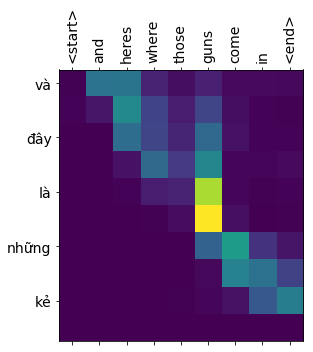


Input:  <start> as soon as we moved to new england you know that place where connor was supposed to feel so safe he bought three guns <end>
Groundtruth:  <start> khi chúng tôi chuyển đến new england bạn biết đấy nơi mà conor dựa vào để cảm thấy an toàn anh ta mua ba cây súng <end>
Translation:  <start> ngay khi chúng tôi chuyển sang anh quốc gia bạn biết rằng khi ở đây là nên có thể cảm thấy an toàn hơn ông ấy mua súng ba <end>
Bleu Score:  51.61290322580645

Input:  <start> he kept one in the glove compartment of our car <end>
Groundtruth:  <start> anh ta giữ một cây trong ngăn chứa đồ của chiếc xe của chúng tôi <end>
Translation:  <start> ông giữ lại trong số các bạn đang ở sân bay của chúng tôi <end>
Bleu Score:  41.099321498089566

Input:  <start> he kept one under the pillows on our bed and the third one he kept in his pocket at all times <end>
Groundtruth:  <start> một cây dưới gối chỗ giường ngủ của chúng tôi cây thứ ba anh luôn ta giữa trong ví <end>
Translation:  <start> ông 

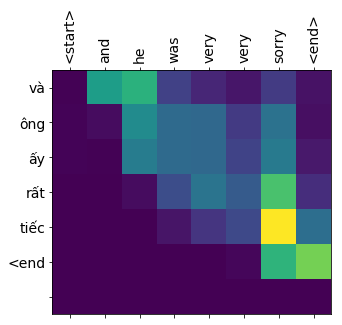


Input:  <start> he had just been really stressed out by the wedding and by becoming a family with me <end>
Groundtruth:  <start> anh ta đã thật sự rất căng thẳng vì đám cưới và việc lập gia đình với tôi <end>
Translation:  <start> ông ấy đã bị căng thẳng bởi đám cưới và người trở thành một gia đình với tôi <end>
Bleu Score:  60.0

Input:  <start> it was an isolated incident and he was never going to hurt me again <end>
Groundtruth:  <start> đó là môt sự cố cá biệt và anh ta sẽ không bao giờ làm đau tôi nữa <end>
Translation:  <start> nó là một bà bị cô ấy và ông chưa bao giờ làm tôi đau khổ lần nữa <end>
Bleu Score:  50.0

Input:  <start> it happened twice more on the honeymoon <end>
Groundtruth:  <start> nó đã xảy ra thêm hai lần trong tuần trăng mật <end>
Translation:  <start> nó xảy ra gấp 2 trên youtube <end>
Bleu Score:  35.62113269055304


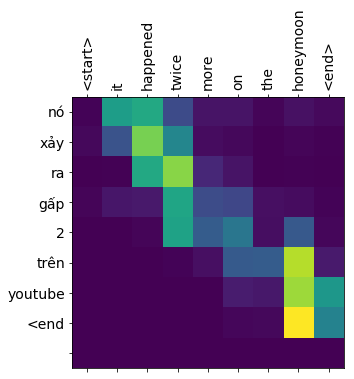


Input:  <start> the first time i was driving to find a secret beach and i got lost and he punched me in the side of my head so hard that the other side of my head repeatedly hit the drivers side window <end>
Groundtruth:  <start> lần đầu tiên tôi đang lái xe để tìm một bãi biển bí mật và tôi bị lạc anh ta đánh vào một bên đầu tôi rất mạnh khiến đầu tôi liên tục đập vào cửa kính của xe <end>
Translation:  <start> lần đầu tiên tôi đang lái xe tìm thấy một bãi biển bí mật và tôi đã mất đi và tôi đã làm tôi và tôi đã làm tôi và tôi đã làm tôi và tôi đã làm tôi và tôi đã làm tôi và tôi đã làm tôi và tôi đã làm tôi và tôi đã làm tôi và
Bleu Score:  29.508196721311474

Input:  <start> and then a few days later driving home from our honeymoon he got frustrated by traffic and he threw a cold big mac in my face <end>
Groundtruth:  <start> vài ngày sau đó khi đang lái xe về nhà sau tuần trăng mật anh ta mệt mỏi vì xe cộ và anh ta ném cả túi thức ăn big mac vào mặt tôi <end>
Translation:  <start>

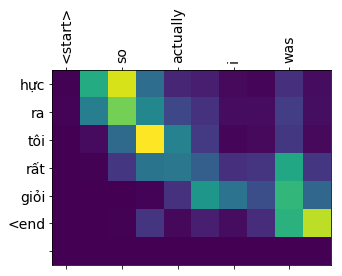


Input:  <start> back to my question why did i stay <end>
Groundtruth:  <start> trở lại câu hỏi của tôi tại sao tôi ở lại <end>
Translation:  <start> trở lại câu hỏi tại sao tôi lại ở lại <end>
Bleu Score:  84.33740467435463

Input:  <start> the answer is easy <end>
Groundtruth:  <start> câu trả lời rất dễ <end>
Translation:  <start> câu trả lời là dễ dàng <end>
Bleu Score:  75.0


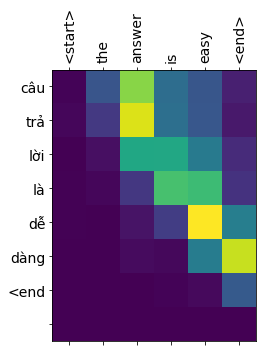


Input:  <start> i didnt know he was abusing me <end>
Groundtruth:  <start> tôi không biết anh ta đang bạo hành tôi <end>
Translation:  <start> tôi không biết ông ta đang ngược đãi tôi <end>
Bleu Score:  72.72727272727273

Input:  <start> even though he held those loaded guns to my head pushed me down stairs threatened to kill our dog pulled the key out of the car ignition as i drove down the highway poured coffee grinds on my head as i dressed for a job interview i never once thought of myself as a battered wife <end>
Groundtruth:  <start> thậm chí anh ta chĩa súng vào đầu tôi đẩy tôi xuống sàn đe doạ giết lũ chó của tôi rút chìa khoá ra khỏi xe khi tôi đang lái xe vào đường cao tốc đổ grinds cafe lên đầu tôi khi tôi đang mặc đồ cho buổi phỏng vấn tôi chưa bao giờ một lần nghĩ bản thân như một người vợ bị hành hạ <end>
Translation:  <start> ông ấy đã lấy những khẩu súng đạn cho tôi xuống đẩy xuống cầu thang bị đe doạ con chó của mình để điều khiển khỏi chiếc xe lửa động vật tôi làm tô

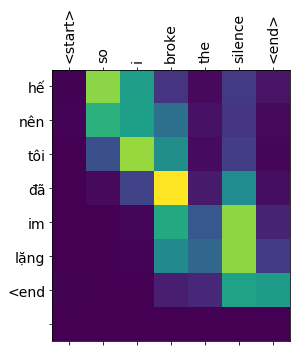


Input:  <start> i told everyone the police my neighbors my friends and family total strangers and im here today because you all helped me <end>
Groundtruth:  <start> tôi kể với mọi người cánh sát những người láng giềng bạn bè và gia đình tôi những người hoàn toàn xa lạ và tôi đứng đây hôm nay bởi vì bạn đều đang giúp tôi <end>
Translation:  <start> tôi bảo mọi người hàng xóm của mình và gia đình tôi và gia đình tôi và ở đây hôm nay vì bạn đều đã giúp đỡ tôi <end>
Bleu Score:  48.508794763094414

Input:  <start> we tend to stereotype victims as grisly headlines self destructive women damaged goods <end>
Groundtruth:  <start> chúng ta có quan niệm rập khuôn về nạn nhân như những tiêu đề đáng sợ những phụ nữ tự huỷ hoại mình những điều tốt bị làm tổn thương <end>
Translation:  <start> chúng ta có xu hướng tình trạng nạn nhân như những vụ khủng hoảng những người phụ nữ huỷ hoại những tấn công <end>
Bleu Score:  45.347024487343525

Input:  <start> the question why does she stay <end>
Groun

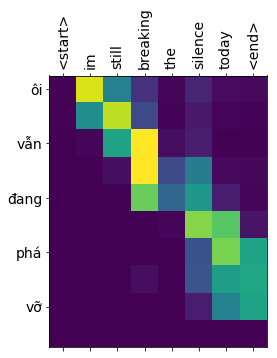


Input:  <start> its my way of helping other victims and its my final request of you <end>
Groundtruth:  <start> đây là cách tôi giúp những nạn nhân khác và đây là yêu cầu cuối cùng của tôi <end>
Translation:  <start> đó là cách tôi giúp đỡ những nạn nhân khác và đó là lời đề nghị của tôi <end>
Bleu Score:  70.0

Input:  <start> talk about what you heard here <end>
Groundtruth:  <start> hãy kể về những gì bạn được nghe ở đây <end>
Translation:  <start> nói về những gì bạn nghe thấy ở đây <end>
Bleu Score:  74.70824042309418

Input:  <start> abuse thrives only in silence <end>
Groundtruth:  <start> sự ngược đãi chỉ đáng sợ trong im lặng <end>
Translation:  <start> việc sử dụng tỷ lệ phát triển nhanh chóng chỉ trong yên lặng <end>
Bleu Score:  33.33333333333333

Input:  <start> you have the power to end domestic violence simply by shining a spotlight on it <end>
Groundtruth:  <start> bạn có sức mạnh để kết thúc bạo lực gia đình đơn giản bằng cách rọi vào đó một tia sáng <end>
Translation

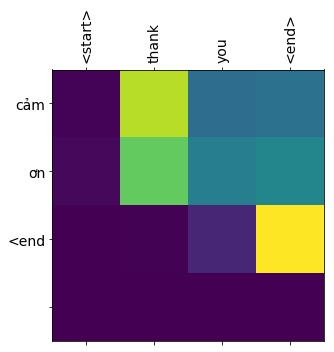


Input:  <start> i would like to talk to you about a very special group of animals <end>
Groundtruth:  <start> tôi muốn nói chuyện với các bạn về một nhóm động vật rất đặc biệt <end>
Translation:  <start> tôi muốn nói chuyện với một nhóm rất nhiều loài động vật <end>
Bleu Score:  69.18152117189051

Input:  <start> there are 10 000 species of birds in the world <end>
Groundtruth:  <start> hiện có khoảng 10 000 loài chim trên thế giới <end>
Translation:  <start> có khoảng 10 loài chim trong các thế giới <end>
Bleu Score:  74.70824042309418

Input:  <start> vultures are amongst the most threatened group of birds <end>
Groundtruth:  <start> kền kền là một trong những nhóm chim bị đe doạ nghiêm trọng nhất <end>
Translation:  <start> chim nhại lại là những loài đe doạ loài chim <end>
Bleu Score:  41.79765978347104

Input:  <start> when you see a vulture like this the first thing that comes to your mind is these are disgusting ugly greedy creatures that are just after your flesh associated wi

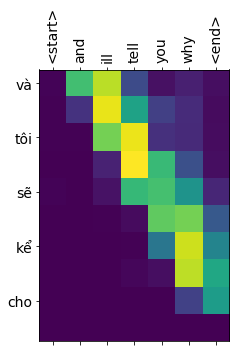


Input:  <start> first of all why do they have such a bad press <end>
Groundtruth:  <start> trước tiên tại sao chúng lại có ấn tượng xấu như vậy <end>
Translation:  <start> trước hết tại sao họ lại có một vụ tồi tệ <end>
Bleu Score:  49.85944269612471

Input:  <start> when charles darwin went across the atlantic in 1832 on the beagle he saw the turkey vulture and he said these are disgusting birds with bald scarlet heads that are formed to revel in putridity <end>
Groundtruth:  <start> khi charles darwin vượt qua thái bình dương năm 1832 từ tàu beagle ông thấy những con kền kền thổ nhĩ kỳ ông nói những con chim này thật kinh tởm với cái đầu trọc đỏ chói được tạo ra để hoan hỉ trong hôi thối <end>
Translation:  <start> khi charles darwin đã vượt qua đại tây dương trên khắp nơi ông ta thấy là thổ nhĩ kỳ và ông nói rằng những gì tuyệt vời với những con chim đã chết yểu cao su là những người bị chết yểu cao su là những người bị chết yểu cao su là những người bị chết yểu cao su
Bleu Score: 

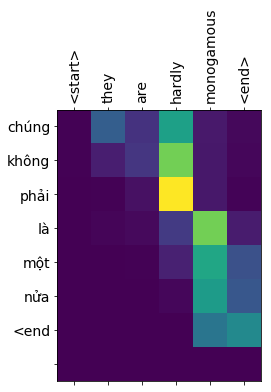


Input:  <start> they are far from being extinct <end>
Groundtruth:  <start> họ còn lâu mới bị tuyệt chủng <end>
Translation:  <start> chúng sẽ từ những nơi tuyệt chủng <end>
Bleu Score:  44.44444444444444


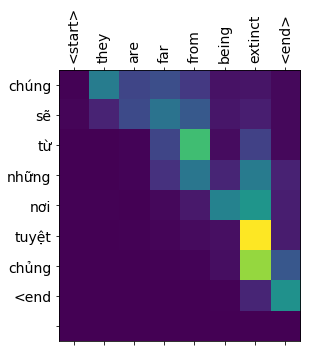


Input:  <start> and my favorite is vultures are better looking <end>
Groundtruth:  <start> và điều mà tôi thích nhất là những con kền kền trông được hơn nhiều <end>
Translation:  <start> và yêu thích của tôi là thợ mộc rất tốt hơn <end>
Bleu Score:  39.584541262629166

Input:  <start> so theres two types of vultures in this planet <end>
Groundtruth:  <start> có hai loại kền kền trên hành tinh này <end>
Translation:  <start> có 2 loại loại tổ chức tại sao <end>
Bleu Score:  36.193496721438386


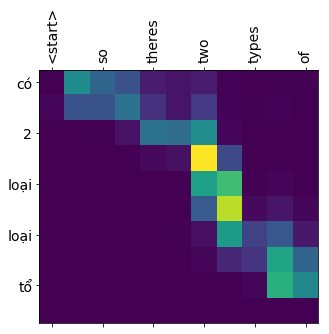


Input:  <start> there are the new world vultures that are mainly found in the americas like the condors and the caracaras and then the old world vultures where we have 16 species from these 16 11 of them are facing a high risk of extinction <end>
Groundtruth:  <start> những loại kền kền tân thế giới được tìm thấy chủ yếu tại mỹ giống như loài condor và caracaras tiếp đó kền kền cựu thế giới nơi mà có khoảng 16 loài trong số 16 loài này thì có 11 loài đối mặt với nguy cơ tuyệt chủng cao <end>
Translation:  <start> có một thế giới thiên nhiên là những người ta chủ yếu là tìm ra ở trong nước mỹ như thế giới và những nơi mà thế giới già và pho mát và thế giới già và pho mát và thế giới già và pho mát và thế giới già và pho mát và thế giới già và pho mát
Bleu Score:  26.229508196721312

Input:  <start> so why are vultures important first of all they provide vital ecological services they clean up <end>
Groundtruth:  <start> vậy tại sao kền kền lại quan trọng trước hết chúng cung cấp những 

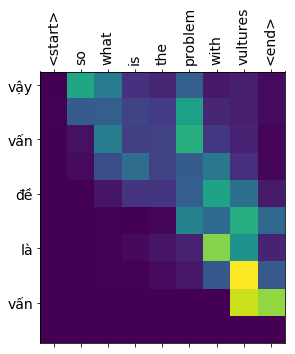


Input:  <start> we have eight species of vultures that occur in kenya of which six are highly threatened with extinction <end>
Groundtruth:  <start> chúng ta có 8 loài kền kền xuất hiện tại kenya trong đó có 6 loài bị đe doạ với nguy cơ tuyệt chủng cao <end>
Translation:  <start> chúng ta có 8 loài tằm làm sao ở kenya có thể bị đe doạ vô hại <end>
Bleu Score:  41.454035082368854

Input:  <start> the reason is that theyre getting poisoned and the reason that theyre getting poisoned is because theres human wildlife conflicts the pastoral communities are using this poison to target predators and in return the vultures are falling victim to this <end>
Groundtruth:  <start> lí do là chúng đang bị đầu độc chúng bị đầu độc vì có những sự tranh giành giữa con người và thế giới hoang dã những cộng đồng mục đồng đang sử dụng chất độc này để nhằm vào các con vật săn mồi nhưng thay vì vậy những con kền kền lại là nạn nhân cho này <end>
Translation:  <start> lý do là chúng được chuyển đổi và đó là

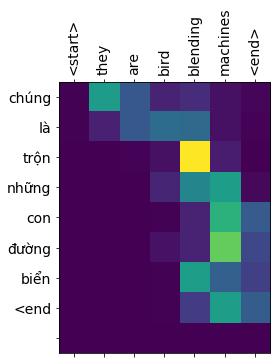


Input:  <start> in west africa theres a horrific trade of dead vultures to serve the witchcraft and the fetish market <end>
Groundtruth:  <start> tại tây phi có một ngành buôn bán kền kền chết thật kinh khủng để phục vụ cho thị trường ma thuật và bùa ngải <end>
Translation:  <start> ở châu phi có một thương lượng thương lượng tử vong làm lạnh làm lạnh làm dịu dàng và đánh bại về mặt nạ bi thảm kịch <end>
Bleu Score:  20.689655172413797

Input:  <start> so whats being done well were conducting research on these birds were putting transmitters on them <end>
Groundtruth:  <start> vậy chúng tôi đã làm được gì chúng tôi đang tiến hành nghiên cứu về những chú chim này chúng tôi đang gắn máy phát tín hiệu vào chúng <end>
Translation:  <start> vì vậy điều gì đã được làm là chúng tôi đang học cách nghiên cứu về những con chim này đang truyền bá chúng <end>
Bleu Score:  57.11905156019095

Input:  <start> were trying to determine their basic ecology and see where they go <end>
Groundtruth:  <sta

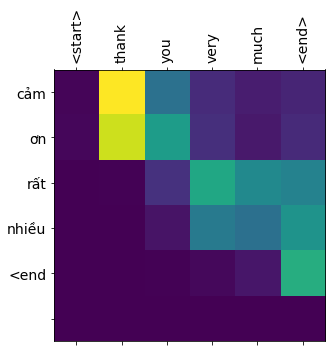


Input:  <start> when i was 11 i remember waking up one morning to the sound of joy in my house <end>
Groundtruth:  <start> khi tôi 11 tuổi tôi nhớ một buổi sáng tôi thức dậy khi nghe tiếng hân hoan trong căn nhà của tôi <end>
Translation:  <start> khi tôi 11 tuổi tôi nhớ rằng sáng suốt một buổi sáng để nghe niềm vui trong tình yêu <end>
Bleu Score:  53.66386998453506

Input:  <start> my father was listening to bbc news on his small gray radio <end>
Groundtruth:  <start> bố tôi lúc ấy đang nghe tin tức bbc trên chiếc radio màu xám nhỏ của ông ấy <end>
Translation:  <start> cha tôi đang kêu gọi cho tin tức về màu xám xịt <end>
Bleu Score:  37.225089001774606

Input:  <start> there was a big smile on his face which was unusual then because the news mostly depressed him <end>
Groundtruth:  <start> ông ấy nở một nụ cười rất lớn điều này rất bất thường vì tin tức thường làm ông ấy buồn rầu hơn <end>
Translation:  <start> có một nụ cười lớn hơn về mặt khác thường vì thế bởi vì tin tức giận c

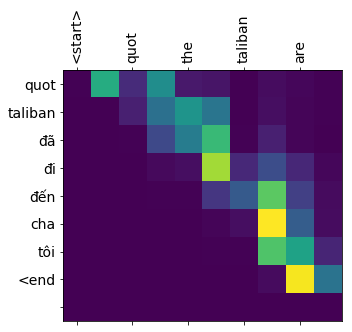


Input:  <start> i didnt know what it meant but i could see that my father was very very happy <end>
Groundtruth:  <start> lúc đó tôi không hiểu rõ nhưng tôi có thể thấy rằng bố tôi rất rất vui mừng <end>
Translation:  <start> tôi không biết điều đó nghĩa gì nhưng tôi có thể thấy rằng cha tôi là rất vui vẻ <end>
Bleu Score:  66.66666666666666

Input:  <start> quot you can go to a real school now he said <end>
Groundtruth:  <start> quot bây giờ con có thể thật sự đến trường rồi ông nói <end>
Translation:  <start> quot bạn có thể đi học một trường đại học anh ta đã nói <end>
Bleu Score:  43.75

Input:  <start> a morning that i will never forget <end>
Groundtruth:  <start> một buổi sáng mà tôi không thể nào quên được <end>
Translation:  <start> một buổi sáng mà tôi sẽ không bao giờ quên <end>
Bleu Score:  75.0

Input:  <start> a real school <end>
Groundtruth:  <start> một ngôi trường thật sự <end>
Translation:  <start> một trường thực <end>
Bleu Score:  53.62560368285115


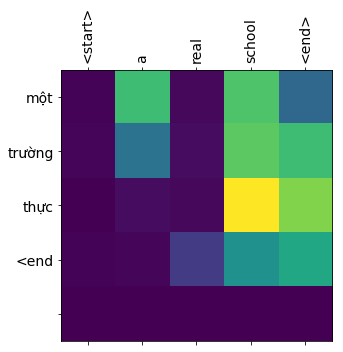


Input:  <start> you see i was six when the taliban took over afghanistan and made it illegal for girls to go to school <end>
Groundtruth:  <start> bạn biết không bọn taliban đến xâm lấn afghanistan từ khi tôi 6 tuổi và ngăn cấm các cô gái đi học <end>
Translation:  <start> bạn thấy tôi có 6 tuổi khi tôi đã đến afghanistan và làm cho những cô gái đến trường <end>
Bleu Score:  49.53587998572467

Input:  <start> so for the next five years i dressed as a boy to escort my older sister who was no longer allowed to be outside alone to a secret school <end>
Groundtruth:  <start> trong 5 năm sau đó tôi đã ăn mặc như 1 thằng con trai để đi cùng với chị tôi tới một trường bí mật vì chị tôi bị cấm ra khỏi nhà môt mình <end>
Translation:  <start> vì vậy trong 5 năm tới tôi đã mặc đồ lặn để chăm sóc con gái tôi không còn được cho mình ở ngoài một mình trường bí mật <end>
Bleu Score:  47.84690106655459

Input:  <start> it was the only way we both could be educated <end>
Groundtruth:  <start> đó là c

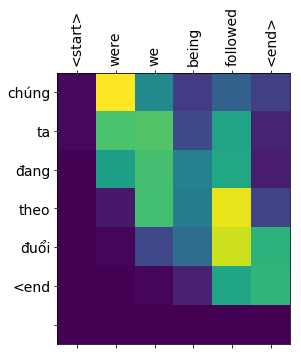


Input:  <start> do they know where we live <end>
Groundtruth:  <start> họ có biết chỗ chúng tôi ở không <end>
Translation:  <start> liệu họ có biết chúng ta sống <end>
Bleu Score:  59.655954454291305


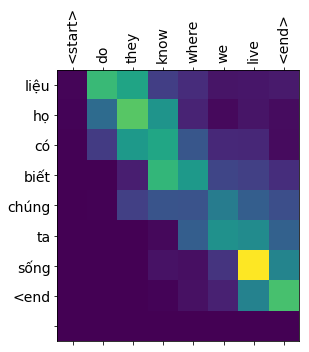


Input:  <start> we were scared but still school was where we wanted to be <end>
Groundtruth:  <start> chúng tôi đã rất sợ nhưng dù vậy chúng tôi vẫn muốn tới trường <end>
Translation:  <start> chúng ta sợ hãi nhưng vẫn còn học trường là nơi mà chúng tôi muốn <end>
Bleu Score:  58.82352941176471

Input:  <start> i was very lucky to grow up in a family where education was prized and daughters were treasured <end>
Groundtruth:  <start> tôi rất may mắn được nuôi dạy trong một gia đình rất trân trọng việc học và con gái được quý trọng <end>
Translation:  <start> tôi rất may mắn khi trưởng thành một gia đình nơi mà giáo dục là giáo dục và con gái chúng ta <end>
Bleu Score:  50.0

Input:  <start> my grandfather was an extraordinary man for his time <end>
Groundtruth:  <start> ông ngoại của tôi là một người thật đáng khâm phục vào thời ấy <end>
Translation:  <start> ông tôi là một người đàn ông là một người đàn ông là một người đàn ông là một người đàn ông là một người đàn ông là một người đà

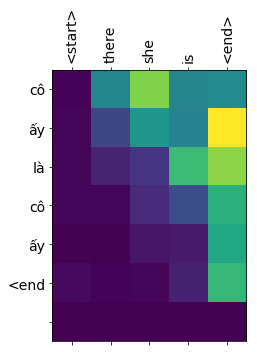


Input:  <start> she retired two years ago only to turn our house into a school for girls and women in our neighborhood <end>
Groundtruth:  <start> bà nghỉ hưu 2 năm về trước để dùng nhà của chúng tôi để mở trường cho bé gái và phụ nữ trong hàng xóm <end>
Translation:  <start> cô giáo sĩ 2 năm trước chỉ để chuyển nhà mình vào nhà trường nữ và phụ nữ trong khu phố <end>
Bleu Score:  43.8453897459599

Input:  <start> and my father thats him he was the first ever in his family to receive an education <end>
Groundtruth:  <start> và đây là bố của tôi ông là người đầu tiên trong gia đình của ông ấy được giáo dục <end>
Translation:  <start> và bố tôi là ông ấy là ông ấy là lần đầu tiên trong gia đình nhận được một giáo dục <end>
Bleu Score:  78.26086956521739

Input:  <start> there was no question that his children would receive an education including his daughters despite the taliban despite the risks <end>
Groundtruth:  <start> không nghi ngờ rằng con cái của ông ấy sẽ được giáo dục bao gồm

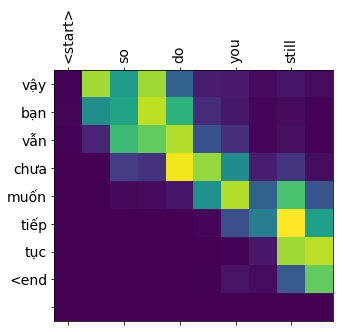


Input:  <start> today i am 22 <end>
Groundtruth:  <start> hôm nay tôi 22 tuổi <end>
Translation:  <start> hôm nay tôi là 22 tuổi <end>
Bleu Score:  87.5


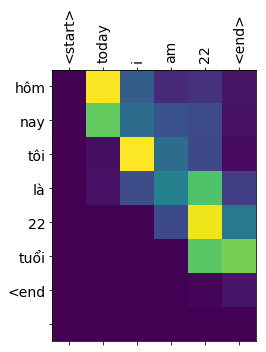


Input:  <start> i was raised in a country that has been destroyed by decades of war <end>
Groundtruth:  <start> tôi đã được lớn lên ở một quốc gia đã bị tiêu huỷ bởi bao thập niên chiến tranh <end>
Translation:  <start> tôi được nuôi lớn trong một đất nước đã bị phá huỷ bởi những chiến tranh <end>
Bleu Score:  56.4321149927076

Input:  <start> fewer than six percent of women my age have made it beyond high school and had my family not been so committed to my education i would be one of them <end>
Groundtruth:  <start> ít hơn 6 phụ nữ tuổi tôi được học sau trung học phổ thông và nếu gia đình tôi không cam kết về việc học của tôi tôi cũng trở thành một trong số họ <end>
Translation:  <start> ít hơn 6 phụ nữ của tôi đã làm nhiều hơn và trường gia đình tôi không phải phục vụ giáo dục tôi sẽ là một trong số họ <end>
Bleu Score:  50.50506223691873

Input:  <start> instead i stand here a proud graduate of middlebury college <end>
Groundtruth:  <start> nhưng mà tôi hãnh diện đứng đây là một s

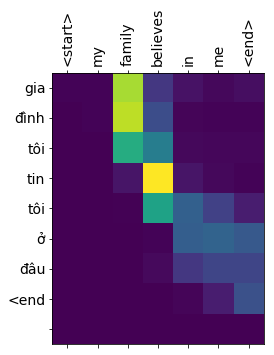


Input:  <start> i dream big but my family dreams even bigger for me <end>
Groundtruth:  <start> tôi mơ ước lớn nhưng gia đình tôi mong ước cho tôi còn lớn hơn <end>
Translation:  <start> tôi mơ ước lớn nhưng gia đình tôi còn lớn hơn cho tôi <end>
Bleu Score:  87.51733190429475

Input:  <start> thats why i am a global ambassador for 10x10 a global campaign to educate women <end>
Groundtruth:  <start> vì thế tôi là đại sứ toàn cầu cho 10x10 đây là cuộc vận động toàn cầu để giáo dục phụ nữ <end>
Translation:  <start> đó là lý do tại sao tôi là một đại sứ toàn cầu dành cho toàn cầu chiến dịch toàn cầu để giáo viên nữ giới <end>
Bleu Score:  53.57142857142857

Input:  <start> thats why i cofounded sola the first and perhaps only boarding school for girls in afghanistan a country where its still risky for girls to go to school <end>
Groundtruth:  <start> vì vậy tôi giúp thành lập sola ngôi trường đầu tiên và hẳn là duy nhất cho con gái ở afghanistan một đất nước mà vẫn còn nguy hiểm cho các

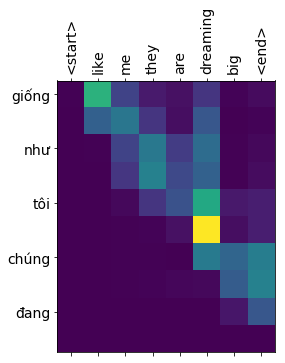


Input:  <start> thank you <end>
Groundtruth:  <start> cám ơn <end>
Translation:  <start> cảm ơn <end>
Bleu Score:  75.0


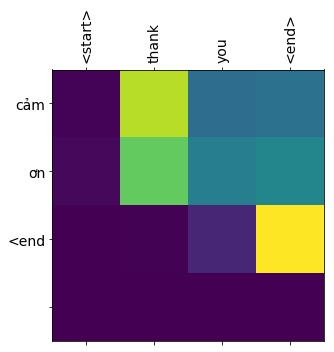


Input:  <start> hi this is my mobile phone <end>
Groundtruth:  <start> xin chào đây là chiếc điện thoại di động của tôi <end>
Translation:  <start> xin chào tôi đây là điện thoại di động của tôi <end>
Bleu Score:  92.3076923076923

Input:  <start> a mobile phone can change your life and a mobile phone gives you individual freedom <end>
Groundtruth:  <start> một chiếc điện thoại di động có thể thay đổi cuộc sống của bạn và một chiếc điện thoại cũng mang lại cho bạn tự do cá nhân <end>
Translation:  <start> điện thoại di động có thể thay đổi cuộc sống của bạn và một điện thoại di động cho bạn tự do cá nhân <end>
Bleu Score:  79.14497715327151

Input:  <start> with a mobile phone you can shoot a crime against humanity in syria <end>
Groundtruth:  <start> với một chiếc điện thoại di động bạn có thể ghi lại hình ảnh những hành động xâm phạm nhân quyền ở syria <end>
Translation:  <start> với điện thoại di động bạn có thể bắn một tội phạm chống lại loài người syria <end>
Bleu Score:  53.7314

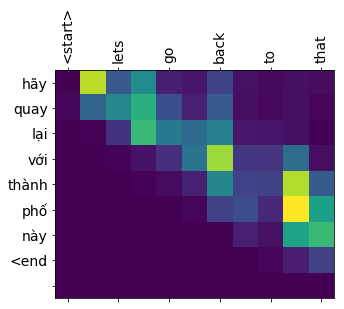


Input:  <start> here you can see how hundreds of thousands of people stood up and protested for change <end>
Groundtruth:  <start> bạn có thể thấy ở đây cách mà hàng ngàn người dân đứng lên và biểu tình cho sự thay đổi <end>
Translation:  <start> đây bạn có thể thấy cách đây hàng trăm ngàn người đứng dậy và phản đối xứng đáng <end>
Bleu Score:  55.946018467628754

Input:  <start> this is autumn 1989 and imagine that all those people standing up and protesting for change had a mobile phone in their pocket <end>
Groundtruth:  <start> đó là vào mùa thu năm 1989 và hãy tưởng tượng những con người đã đứng lên và biểu tình đòi sự thay đổi đó có một chiếc điện thoại di động trong túi <end>
Translation:  <start> đây là năm 1989 và tưởng tượng rằng tất cả những người đứng dậy và lạm dụng để thay đổi có một điện thoại di động trong túi <end>
Bleu Score:  60.040255225718674

Input:  <start> who in the room has a mobile phone with you <end>
Groundtruth:  <start> những ai trong khán phòng có điện 

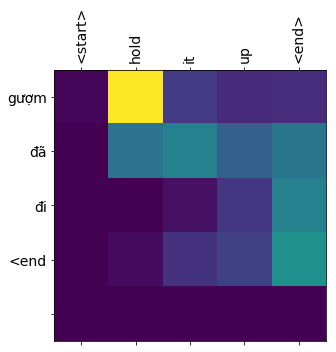


Input:  <start> hold your phones up hold your phones up <end>
Groundtruth:  <start> hãy giơ chiếc điện thoại của bạn lên hãy giơ cao chiếc điện thoại của bạn lên <end>
Translation:  <start> giữ điện thoại của bạn có thể thao lên mạng <end>
Bleu Score:  32.55205016991941

Input:  <start> hold it up an android a blackberry wow <end>
Groundtruth:  <start> hãy giơ cao nó lên một chiếc điện thoại android blackberry wow <end>
Translation:  <start> gượm đã đặt nó lên một vở nhạc pop ồ <end>
Bleu Score:  35.27007187044225

Input:  <start> thats a lot almost everybody today has a mobile phone <end>
Groundtruth:  <start> rất nhiều ngày nay phần lớn chúng ta đều có một chiếc điện thoại di động <end>
Translation:  <start> đó là một lúc gần như mọi người ngày nay có một điện thoại di động <end>
Bleu Score:  55.55555555555556

Input:  <start> but today i will talk about me and my mobile phone and how it changed my life <end>
Groundtruth:  <start> nhưng hôm nay tôi sẽ nói về bản thân và chiếc điện t

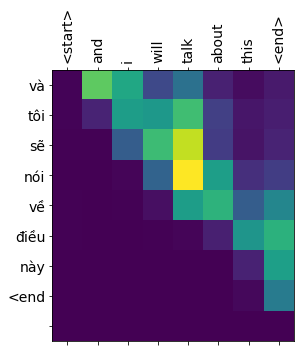


Input:  <start> these are 35 830 lines of information <end>
Groundtruth:  <start> có khoảng 35830 dãy thông tin <end>
Translation:  <start> đây là 35 độ thông tin <end>
Bleu Score:  50.0


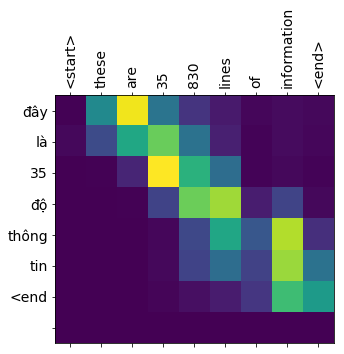


Input:  <start> raw data <end>
Groundtruth:  <start> những thông tin thuần sơ cấp <end>
Translation:  <start> dữ liệu thô sơ <end>
Bleu Score:  35.826565528689464


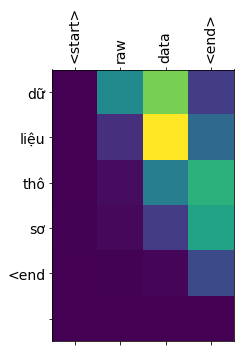


Input:  <start> and why are these informations there <end>
Groundtruth:  <start> nhưng tại sao những thông tin đó lại ở đây <end>
Translation:  <start> và tại sao những thông tin được <end>
Bleu Score:  55.73021304462805


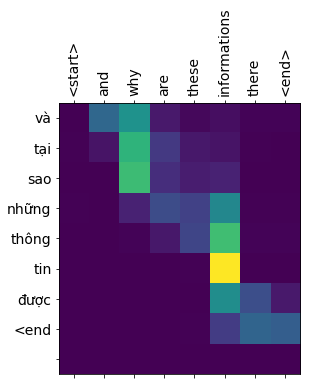


Input:  <start> because in the summer of 2006 the e u commission tabled a directive <end>
Groundtruth:  <start> nguyên nhân là do mùa hè năm 2006 uỷ ban châu âu đã đề xuất một chỉ thị chính thức <end>
Translation:  <start> bởi vì mùa hè năm 2006 của bai đề nghị <end>
Bleu Score:  25.351562162912895

Input:  <start> this directive 91 is 93 called data retention directive <end>
Groundtruth:  <start> nó được gọi là chỉ thị bảo lưu dữ liệu <end>
Translation:  <start> chính quyền hành động 93 gọi là sự kết quả của bộ lạc <end>
Bleu Score:  26.666666666666668

Input:  <start> this directive says that each phone company in europe each internet service company all over europe has to store a wide range of information about the users <end>
Groundtruth:  <start> chỉ thị này cho biết mỗi công ty viễn thông ở châu âu mỗi nhà cung cấp dịch vụ internet trên toàn lãnh thổ châu âu đều phải lưu trữ một lượng lớn thông tin về những người sử dụng <end>
Translation:  <start> đây thực tế nói rằng mỗi công 

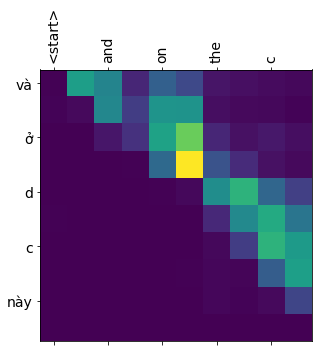


Input:  <start> thirty five thousand eight hundred thirty lines of information <end>
Groundtruth:  <start> 35830 dãy các thông tin <end>
Translation:  <start> 32 năm trăm trăm trăm trăm trăm trăm trăm trăm trăm trăm trăm trăm trăm trăm trăm trăm trăm trăm trăm trăm trăm trăm trăm trăm trăm trăm trăm trăm trăm trăm trăm trăm trăm trăm trăm trăm số trăm số các thông tin <end>
Bleu Score:  10.869565217391305

Input:  <start> at first i saw it and i said okay its a huge file okay <end>
Groundtruth:  <start> đầu tiên tôi nhìn nó và nói được rồi nó là một file dữ liệu lớn tốt <end>
Translation:  <start> đầu tiên tôi thấy nó và nói được rồi đó là một tập trung rất tốt <end>
Bleu Score:  68.31929497659972

Input:  <start> but then after a while i realized this is my life <end>
Groundtruth:  <start> nhưng sau đó tôi đã nhận ra đây là toàn bộ cuộc sống của mình <end>
Translation:  <start> nhưng sau khi tôi nhận ra đây là cuộc sống của tôi <end>
Bleu Score:  69.18152117189051

Input:  <start> th

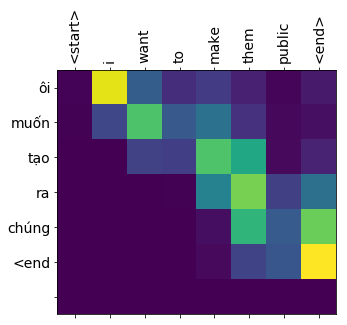


Input:  <start> because i want to show the people what does data retention mean <end>
Groundtruth:  <start> bởi lẽ tôi muốn cho mọi người thấy sự bảo lưu dữ liệu thật sự là như thế nào <end>
Translation:  <start> bởi vì tôi muốn cho các bạn xem những dữ liệu của ý nghĩa của ý nghĩa <end>
Bleu Score:  37.89842636851618

Input:  <start> so together with zeit online and open data city i did this <end>
Groundtruth:  <start> do vậy đối với zeit online và open data city tôi cũng làm điều tương tự <end>
Translation:  <start> vì vậy cùng với nhau với các bạn với mạng và mở rộng mở rộng mở cửa sổ và mở rộng mở cửa sổ và mở rộng mở cửa sổ và mở rộng mở cửa sổ và mở rộng mở cửa sổ và mở rộng mở cửa sổ và mở rộng mở cửa sổ và mở rộng mở cửa sổ
Bleu Score:  6.557377049180328

Input:  <start> this is a visualization of six months of my life <end>
Groundtruth:  <start> đây là những hình ảnh trực quan về cuộc sống trong sáu tháng đã được ghi lại của tôi <end>
Translation:  <start> đây là một bản chất

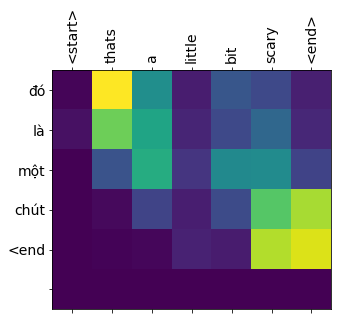


Input:  <start> but it is not only about me <end>
Groundtruth:  <start> nhưng những thông tin đó không chỉ nói về tôi <end>
Translation:  <start> nhưng nó không chỉ là tôi <end>
Bleu Score:  45.48979947844751


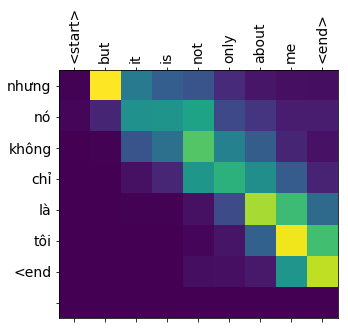


Input:  <start> its about all of us <end>
Groundtruth:  <start> nó là thông tin về tất cả chúng ta <end>
Translation:  <start> nó là về tất cả chúng ta <end>
Bleu Score:  80.07374029168082


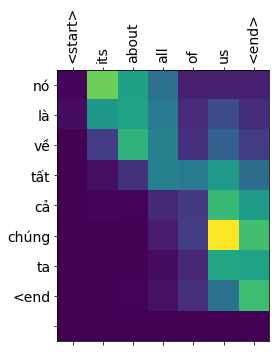


Input:  <start> first its only like i call my wife and she calls me and we talk to each other a couple of times <end>
Groundtruth:  <start> đầu tiên nó chỉ giống như thế này tôi gọi cho vợ tôi và cô ấy cũng gọi cho tôi chúng tôi nói chuyện với nhau vài ba lần <end>
Translation:  <start> đầu tiên nó chỉ là tôi gọi vợ tôi và gọi nó và nói chuyện với nhau <end>
Bleu Score:  44.77907622152175

Input:  <start> and then there are some friends calling me and they call each other <end>
Groundtruth:  <start> và sau đó là một vài người bạn gọi cho tôi họ gọi cho nhau nữa <end>
Translation:  <start> và có một số bạn tôi gọi tôi và họ gọi họ <end>
Bleu Score:  48.30925455483982

Input:  <start> and after a while you are calling you and you are calling you and you have this great communication network <end>
Groundtruth:  <start> một lúc sau đó bạn gọi cho bạn và bạn gọi cho bạn và bạn sẽ có được mạng lưới giao tiếp rộng lớn này <end>
Translation:  <start> và sau khi bạn gọi bạn và bạn gọi bạn và b

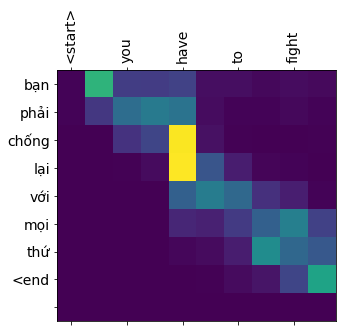


Input:  <start> so when you go home tell your friends that privacy is a value of the 21st century and its not outdated <end>
Groundtruth:  <start> sau đó khi bạn trở về nhà hãy nói với bạn bè của mình rằng quyền riêng tư là một giá trị của thế kỉ 21 và điều đó không hề lỗi thời <end>
Translation:  <start> khi bạn về nhà nói với bạn bè của bạn rằng bạn là một người giá trị của thế kỉ 21 và nó không phải lỗi thời <end>
Bleu Score:  67.29134564019623

Input:  <start> when you go home tell your representative only because companies and state agencies have the possibility to store certain information they dont have to do it <end>
Groundtruth:  <start> khi bạn trở về nhà hãy nói với chỉ người đại diện của mình rằng bởi các công ty và cơ quan chức năng có thể lưu giữ lại những thông tin cụ thể mặc dù họ không nhất thiết phải làm như thế <end>
Translation:  <start> khi bạn về nhà nói với đại diện cho chính phủ bởi vì các công ty có cơ hội để có thể lưu trữ các loại thông tin mà họ không cần p

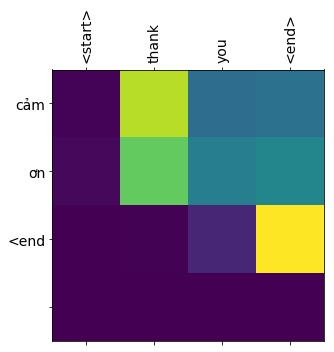


Input:  <start> photography has been my passion ever since i was old enough to pick up a camera but today i want to share with you the 15 most treasured photos of mine and i didnt take any of them <end>
Groundtruth:  <start> nhiếp ảnh là niềm đam mê của tôi kể từ khi tôi đủ lớn để cầm một chiếc máy ảnh nhưng hôm nay tôi muốn chia sẻ với các bạn 15 bức ảnh mà tôi trân trọng nhất và tôi không tự chụp cái nào trong số đó <end>
Translation:  <start> nhiếp ảnh đã có đam mê của tôi từ khi tôi già đủ để tôi chọn để có thể thiết kế một chiếc máy nhưng hôm nay tôi muốn chia sẻ với các bạn 15 phần lớn nhất của những người lớn nhất của mình và tôi không đưa cho họ <end>
Bleu Score:  62.264150943396224

Input:  <start> there were no art directors no stylists no chance for reshoots not even any regard for lighting <end>
Groundtruth:  <start> không có đạo diễn nghệ thuật không có nhà tạo mẫu không chụp lại thậm chí không hề quan tâm tới ánh sáng <end>
Translation:  <start> không có tranh cãi về ngh

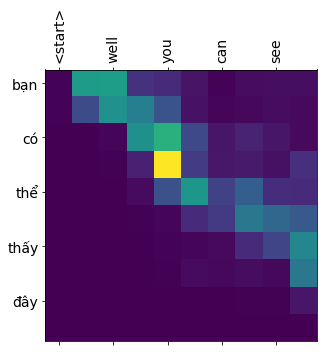


Input:  <start> approaching my daughters third birthday my wife said hey why dont you take sabina back to new york and make it a father daughter trip and continue the ritual <end>
Groundtruth:  <start> khi sắp tới sinh nhật lần thứ 3 của con gái tôi vợ tôi nói sao anh không đưa sabrina đến new york làm một chuyến du lịch chỉ có cha và con gái rồi tiếp tục nghi thức cũ <end>
Translation:  <start> tiến đến con gái tôi một người vợ tôi nói này tại sao anh không lấy lại truờng quay lại new york và làm nó một người cha con gái và tiếp tục nghi thức <end>
Bleu Score:  56.66580648308518

Input:  <start> this is when we started asking passing tourists to take the picture <end>
Groundtruth:  <start> từ đó chúng tôi bắt đầu nhờ khách du lịch qua đường chụp ảnh <end>
Translation:  <start> đây là khi chúng tôi bắt đầu đi du khách du lịch <end>
Bleu Score:  55.72786498394026

Input:  <start> you know its remarkable how universal the gesture is of handing your camera to a total stranger <end>
Groun

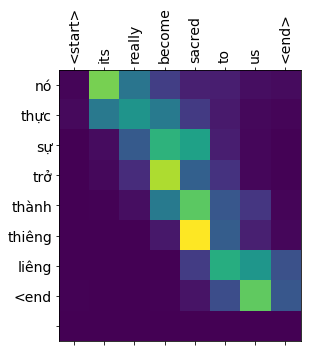


Input:  <start> this one was taken just weeks after 9 11 and i found myself trying to explain what had happened that day in ways a five year old could understand <end>
Groundtruth:  <start> bức này được chụp vài tuần sau sự kiện 11 9 và tôi đã cố gắng giải thích những việc xảy ra hôm đó theo những cách mà một đứa trẻ 5 tuổi có thể hiểu được <end>
Translation:  <start> đây là tuần sau 9 11 và tôi thấy rằng cố gắng giải thích được chuyện gì đã xảy ra trong vòng cách nào trong vòng 5 năm tuổi có thể hiểu <end>
Bleu Score:  55.856912741313394

Input:  <start> so these photos are far more than proxies for a single moment or even a specific trip <end>
Groundtruth:  <start> những bức ảnh này không chỉ là vật đại diện cho một khoảnh khắc hay một chuyến đi đặc biệt nào đó <end>
Translation:  <start> những bức ảnh này lại hiệu ứng với một khoảnh khắc hay thậm chí là một chuyến đi <end>
Bleu Score:  57.31115271545873

Input:  <start> theyre also ways for us to freeze time for one week in october

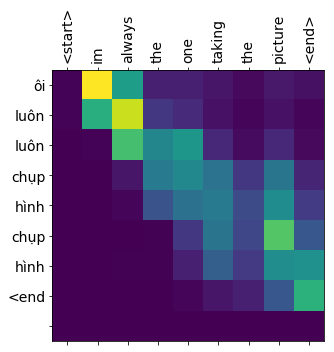


Input:  <start> so i want to encourage everyone today to get in the shot and dont hesitate to go up to someone and ask will you take our picture <end>
Groundtruth:  <start> vì vậy hôm nay tôi muốn động viên tất cả mọi người hãy có mặt trong bức ảnh và đừng ngần ngại bước tới chỗ một ai đó và hỏi bạn chụp ảnh giúp chúng tôi nhé <end>
Translation:  <start> vì vậy tôi muốn khuyến khích tất cả mọi người hôm nay để có thể bắt đầu bắn và không hề nghĩ đến để ai đó và hỏi sẽ đưa bạn chụp hình ảnh <end>
Bleu Score:  53.669257520043864

Input:  <start> thank you <end>
Groundtruth:  <start> cảm ơn <end>
Translation:  <start> cảm ơn <end>
Bleu Score:  100.0


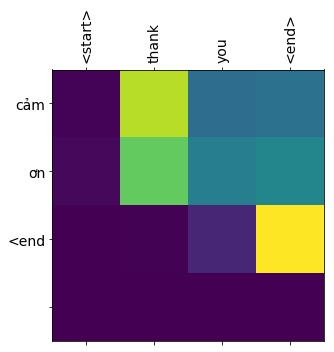


Input:  <start> i have never ever forgotten the words of my grandmother who died in her exile son resist gaddafi fight him <end>
Groundtruth:  <start> tôi chưa bao giờ quên những lời bà tôi dặn dò bà đã qua đời trong cảnh tha hương này cháu hãy chống lại gaddafi hãy chiến đấu chống lại hắn <end>
Translation:  <start> tôi chưa bao giờ quên đi từ chối bà tôi đã chết trong vòng đời của cô ta chống lại <end>
Bleu Score:  38.59740561807668

Input:  <start> but dont you ever turn into a gaddafi like revolutionary <end>
Groundtruth:  <start> nhưng đừng bao giờ biến thành một dạng người cách mạng kiểu gaddafi <end>
Translation:  <start> nhưng bạn không bao giờ quay lại với một con ong như cách mạng <end>
Bleu Score:  50.0

Input:  <start> almost two years have passed since the libyan revolution broke out inspired by the waves of mass mobilization in both the tunisian and the egyptian revolutions <end>
Groundtruth:  <start> gần hai năm đã trôi qua từ khi cuộc khởi nghĩa ở libya nổ ra được tiếp

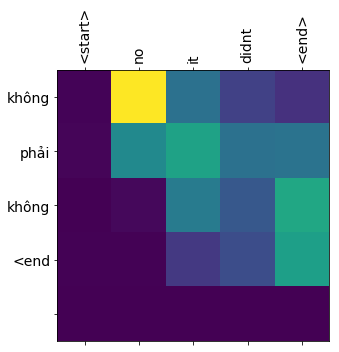


Input:  <start> what is it then <end>
Groundtruth:  <start> vậy cuối cùng nó đã giúp ích gì <end>
Translation:  <start> nó sẽ xảy ra <end>
Bleu Score:  25.6708559516296


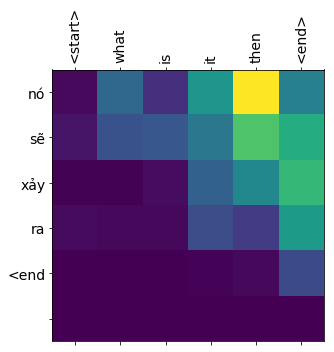


Input:  <start> why does our society continue to be polarized and dominated with selfish politics of dominance and exclusion by both men and women <end>
Groundtruth:  <start> tại sao xã hội chúng tôi tiếp tục là một xã hội phân cực và thống trị bởi những nền chính trị ích kỷ của sự thống trị và loại trừ bởi cả hai giới nam và nữ <end>
Translation:  <start> tại sao xã hội của chúng ta tiếp tục xã hội và phân tích và ích kỷ và sự phân biệt và sự phân biệt và sự phân biệt và sự phân biệt và sự phân biệt và sự phân biệt và sự phân biệt và sự phân biệt và sự phân biệt và sự phân biệt và sự phân
Bleu Score:  29.508196721311474

Input:  <start> maybe what was missing was not the women only but the feminine values of compassion mercy and inclusion <end>
Groundtruth:  <start> có thể sự thiếu sót không chỉ là về mặt bình quyền của phụ nữ mà còn là những giá trị tính nữ về lòng trắc ẩn sự khoan dung và tính toàn diện <end>
Translation:  <start> có thể là thiếu sót không phải là những người phụ n

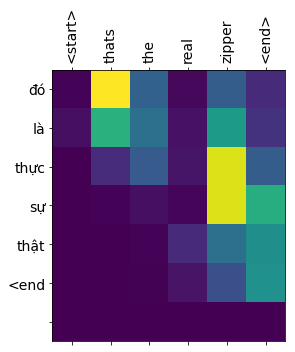


Input:  <start> and we need to establish that existentially before we do so sociopolitically <end>
Groundtruth:  <start> và chúng tôi cần thiết lập yếu tố sống còn đó trước khi thực hiện mặt chính trị xã hội <end>
Translation:  <start> và chúng ta cần thiết lập để chúng tôi làm vậy <end>
Bleu Score:  30.79507202218893

Input:  <start> according to a quranic verse salam peace is the word of the all merciful god raheem <end>
Groundtruth:  <start> theo một đoạn thơ trong kinh koran salam hoà bình là từ của chúa trời đầy lòng khoan dung raheem <end>
Translation:  <start> theo một cách hoàn toàn là bình luận là từ từ đó trong tạp chí natgeo <end>
Bleu Score:  35.5883290185248

Input:  <start> in turn the word raheem which is known in all abrahamic traditions has the same root in arabic as the word rahem womb symbolizing the maternal feminine encompassing all humanity from which the male and the female from which all tribes all peoples have emanated from <end>
Groundtruth:  <start> tiếp the

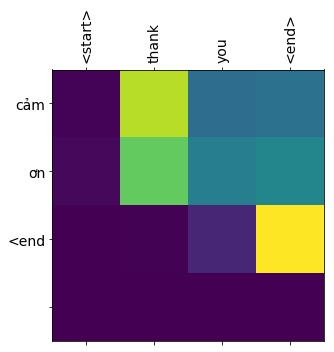


Input:  <start> five years ago i experienced a bit of what it must have been like to be alice in wonderland <end>
Groundtruth:  <start> 5 năm trước tôi đã trải qua 1 chuyện có chút giống như alice ở xứ thần tiên <end>
Translation:  <start> năm năm trước tôi đã trải qua một chút về điều mà tôi đã bị ám ảnh ở đại dịch <end>
Bleu Score:  45.45454545454545

Input:  <start> penn state asked me a communications teacher to teach a communications class for engineering students <end>
Groundtruth:  <start> trường penn state yêu cầu tôi một giáo viên dạy giao tiếp dạy một khoá giao tiếp cho sinh viên kỹ thuật <end>
Translation:  <start> ở nhà phục hồi tôi đã giao tiếp học để giảng dạy học tập hợp cho các sinh viên khoa học <end>
Bleu Score:  37.46556657658882

Input:  <start> and i was scared <end>
Groundtruth:  <start> tôi đã rất sợ <end>
Translation:  <start> và tôi sợ <end>
Bleu Score:  65.49846024623855


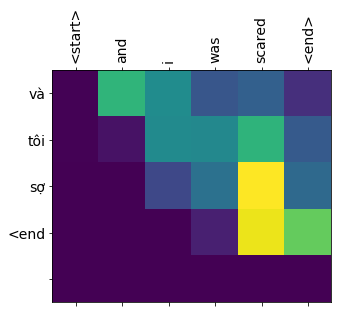


Input:  <start> really scared scared of these students with their big brains and their big books and their big unfamiliar words <end>
Groundtruth:  <start> thực sự sợ sợ những sinh viên to đầu những quyển sách to đùng và cả những ngôn từ lạ lẫm <end>
Translation:  <start> thật sự sợ sợ những người sinh viên của chúng và lớn và vĩ đại của họ và những quyển sách cũ của họ <end>
Bleu Score:  46.15384615384615

Input:  <start> but as these conversations unfolded i experienced what alice must have when she went down that rabbit hole and saw that door to a whole new world <end>
Groundtruth:  <start> nhưng khi những cuộc trao đổi mở ra tôi đã trải nghiệm điều mà hẳn alice cũng trải qua khi cô bé rơi xuống hang thỏ và phát hiện cánh cửa dẫn đến 1 thế giới mới <end>
Translation:  <start> nhưng như những cuộc đối thoại đã diễn ra tôi đã trải qua những gì đã bị ám ảnh khi tôi đi xuống con rắn đó và nhìn thấy cánh cửa và nhìn thấy cánh cửa và nhìn thấy cánh cửa và nhìn thấy cánh cửa và nhìn thấy 

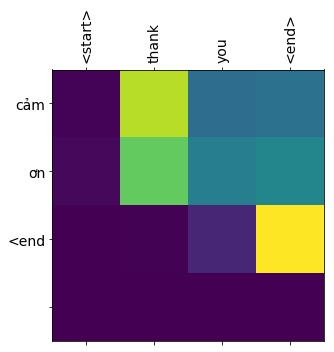


Input:  <start> hi my name is cameron russell and for the last little while ive been a model <end>
Groundtruth:  <start> xin chào tôi là cameron russell và trong khoảng thời gian ngắn ngủi vừa qua tôi là một người mẫu <end>
Translation:  <start> chào tên tôi là cameron russell và vì thế là khi tôi đã là một mô hình <end>
Bleu Score:  49.43861222030993

Input:  <start> actually for 10 years <end>
Groundtruth:  <start> thật ra trong 10 năm <end>
Translation:  <start> thực ra trong 10 năm <end>
Bleu Score:  85.71428571428571


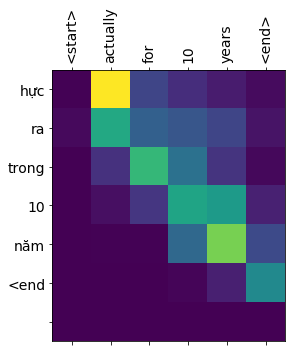


Input:  <start> and i feel like theres an uncomfortable tension in the room right now because i should not have worn this dress <end>
Groundtruth:  <start> và tôi cảm thấy có một áp lực không thoải mái trong phòng vào lúc này bởi vì đáng lẽ ra tôi không nên mặc cái đầm này <end>
Translation:  <start> và tôi cảm thấy như có những sự giằng co ma quỷ trong phòng này ngay bây giờ vì tôi không có mặt mặc quần áo này <end>
Bleu Score:  49.97094809615154

Input:  <start> so luckily i brought an outfit change <end>
Groundtruth:  <start> may mắn thay tôi có mang theo một bộ đồ khác <end>
Translation:  <start> may mắn tôi đã mang lại rất nhiều thay đổi <end>
Bleu Score:  53.669257520043864

Input:  <start> this is the first outfit change on the ted stage so you guys are pretty lucky to witness it i think <end>
Groundtruth:  <start> đây là lần đầu tiên có người thay đồ trên sân khấu của ted vậy nên tôi nghĩ các bạn rất may mắn khi được chứng kiến cảnh này đấy <end>
Translation:  <start> đây là đ

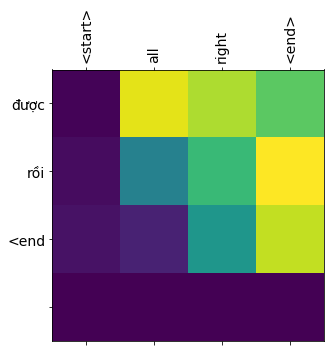


Input:  <start> so why did i do that <end>
Groundtruth:  <start> tại sao tôi lại làm như vậy <end>
Translation:  <start> vậy tại sao tôi làm điều đó <end>
Bleu Score:  77.77777777777779


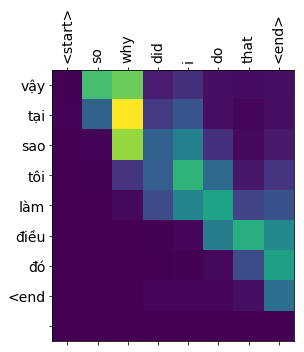


Input:  <start> that was awkward <end>
Groundtruth:  <start> nó thật là kì cục <end>
Translation:  <start> đó là một trận đấu <end>
Bleu Score:  42.857142857142854


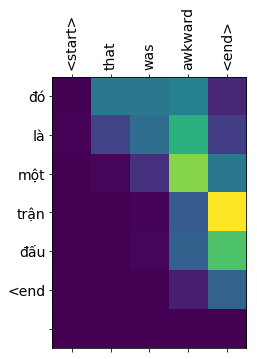


Input:  <start> well hopefully not as awkward as that picture <end>
Groundtruth:  <start> thật ra hy vọng là nó không đến nỗi kì cục như tấm hình này <end>
Translation:  <start> hy vọng rằng không giống như là bức tranh <end>
Bleu Score:  36.88225410448788

Input:  <start> image is powerful but also image is superficial <end>
Groundtruth:  <start> hình ảnh có sức mạnh rất lớn nhưng nó cũng rất là giả tạo <end>
Translation:  <start> hình ảnh là mạnh mẽ nhưng cũng là hình ảnh hời <end>
Bleu Score:  48.85677894264315

Input:  <start> i just totally transformed what you thought of me in six seconds <end>
Groundtruth:  <start> tôi vừa mới thay đổi hoàn toàn những gì bạn nghĩ về tôi trong vòng 6 giây <end>
Translation:  <start> tôi đã hoàn toàn bị biến đổi những gì bạn nghĩ về tôi trong 6 giây <end>
Bleu Score:  78.82995574223045

Input:  <start> and in this picture i had actually never had a boyfriend in real life <end>
Groundtruth:  <start> và trong bức ảnh này thực ra tôi chưa hề có bạn 

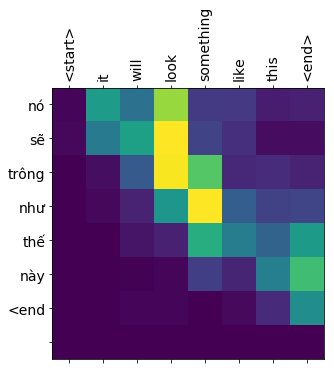


Input:  <start> hopefully less awkward than that one in the middle <end>
Groundtruth:  <start> hi vọng là nó ít kì cục hơn tấm hình ở giữa <end>
Translation:  <start> hy vọng rằng ít hơn một chút nào cả hai trong một trong một người ở giữa <end>
Bleu Score:  36.84210526315789

Input:  <start> that was i dont know what happened there <end>
Groundtruth:  <start> tôi không biết điều gì xảy ra trong lúc đó nữa <end>
Translation:  <start> tôi không biết điều gì đã xảy ra <end>
Bleu Score:  66.67363986135462


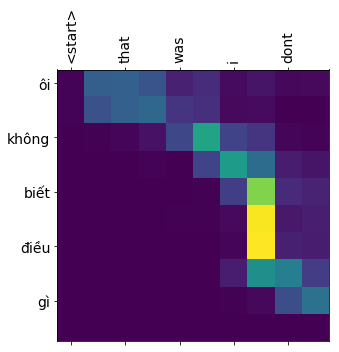


Input:  <start> unfortunately after youve gone to school and you have a résumé and youve done a few jobs you cant say anything anymore so if you say you want to be the president of the united states but your résumé reads underwear model 10 years people give you a funny look <end>
Groundtruth:  <start> thật đáng tiếc sau khi bạn học xong bạn viết résumé và từng làm một vài việc bạn không thể nói thêm điều gì nữa vì nếu bạn nói muốn trở thành tổng thống hoa kỳ nhưng résumé của bạn lại ghi người mẫu đồ lót 10 năm người ta sẽ nhìn bạn với ánh mắt khác lạ <end>
Translation:  <start> thật không may sau khi bạn đi học và bạn có một phiên bản và bạn đã làm một vài việc làm bạn không thể nói gì nữa nữa nếu như bạn muốn có tổng thống của mình là cá mô hình của mình là cá mô hình của mình là cá mô hình của mình là cá mô hình
Bleu Score:  40.98360655737705

Input:  <start> the next question people always ask me is do they retouch all the photos <end>
Groundtruth:  <start> câu hỏi tiếp theo mà ngư

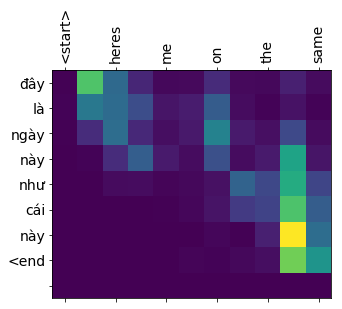


Input:  <start> my friend got to come with me <end>
Groundtruth:  <start> cô bạn của tôi đã đi cùng tôi <end>
Translation:  <start> bạn tôi đến với tôi <end>
Bleu Score:  46.531361252218254


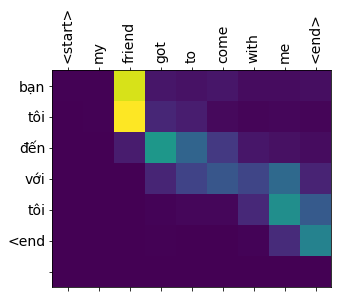


Input:  <start> heres me at a slumber party a few days before i shot french vogue <end>
Groundtruth:  <start> đây là tôi ở tiệc ngủ vài ngày trước khi chụp ảnh cho vogue pháp <end>
Translation:  <start> đây là tôi ở một bữa tiệc tử một vài ngày trước khi tôi đã viết <end>
Bleu Score:  61.111111111111114

Input:  <start> heres me on the soccer team and in v magazine <end>
Groundtruth:  <start> đây là tôi với đội bóng đá trong tạp chí v <end>
Translation:  <start> đây là tôi đang ở trong nhóm đá và viết blog <end>
Bleu Score:  53.84615384615385

Input:  <start> and heres me today <end>
Groundtruth:  <start> và đây là tôi bây giờ <end>
Translation:  <start> và đây là tôi hôm nay <end>
Bleu Score:  75.0


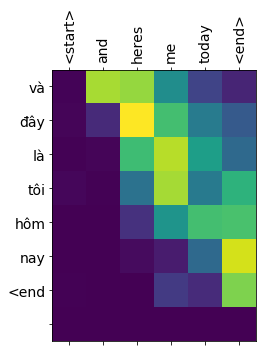


Input:  <start> and i hope what youre seeing is that these pictures are not pictures of me <end>
Groundtruth:  <start> tôi mong rằng bạn nhìn ra được những bức ảnh trên không phải là hình ảnh của tôi <end>
Translation:  <start> và tôi mong các bạn thấy là những bức ảnh này không phải là hình ảnh của tôi <end>
Bleu Score:  75.0

Input:  <start> they are constructions and they are constructions by a group of professionals by hairstylists and makeup artists and photographers and stylists and all of their assistants and pre production and post production and they build this thats not me <end>
Groundtruth:  <start> đó là những hình ảnh được dựng lên và nó được dựng nên bởi một nhóm các chuyên gia những nhà tạo mẫu tóc những chuyên gia trang điểm nhiếp ảnh gia và những nhà tạo phong cách và tất cả những người trợ lý của họ khâu tiền sản xuất và hậu sản xuất và họ tạo nên cái này đây đó không phải là tôi <end>
Translation:  <start> chúng tạo ra những cấu trúc và chúng đang vẽ ra bởi một nhóm

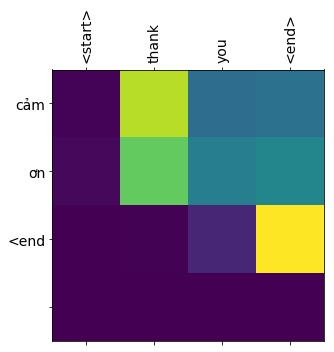


Input:  <start> there are a lot of ways the people around us can help improve our lives <end>
Groundtruth:  <start> có rất nhiều cách mà những người ở xung quanh chúng ta có thể giúp cải thiện cuộc sống của chúng ta <end>
Translation:  <start> có rất nhiều cách mọi người xung quanh chúng ta có thể cải thiện cuộc sống của mình <end>
Bleu Score:  73.68576777701837

Input:  <start> we dont bump into every neighbor so a lot of wisdom never gets passed on though we do share the same public spaces <end>
Groundtruth:  <start> chúng ta không đụng vào mỗi người xung quanh vì vậy có rất nhiều sự thông thái không bao giờ được biết tới dù chúng ta cùng chia sẻ những không gian công cộng <end>
Translation:  <start> chúng ta không có ai bị đuổi bất cứ mỗi người hàng xóm với rất nhiều sự khôn ngoan chưa bao giờ được vượt qua mặc dù chúng ta chia sẻ với những nơi không gian chung <end>
Bleu Score:  56.41025641025641

Input:  <start> so over the past few years ive tried ways to share more with my neig

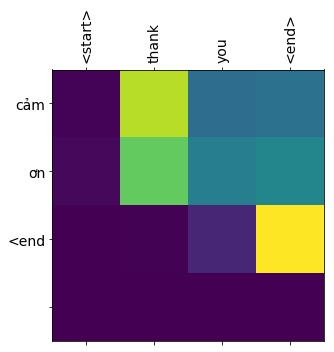


Input:  <start> thank you <end>
Groundtruth:  <start> cảm ơn <end>
Translation:  <start> cảm ơn <end>
Bleu Score:  100.0


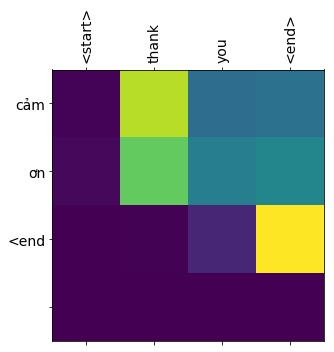


Input:  <start> so well i do applied math and this is a peculiar problem for anyone who does applied math is that we are like management consultants <end>
Groundtruth:  <start> vâng tôi làm toán học ứng dụng và đây là một vấn đề khác thường cho bất cứ ai làm toán học ứng dụng chính là chúng tôi giống như các nhà tư vấn quản lý <end>
Translation:  <start> vâng tôi đã làm việc sử dụng toán và đây là một vấn đề đặc biệt đối với bất cứ ai cũng được áp dụng phương tiện <end>
Bleu Score:  42.98034303580605

Input:  <start> no one knows what the hell we do <end>
Groundtruth:  <start> không ai biết chúng tôi làm cái quái gì <end>
Translation:  <start> không ai biết điều mà chúng ta làm gì <end>
Bleu Score:  72.72727272727273

Input:  <start> so i am going to give you some attempt today to try and explain to you what i do <end>
Groundtruth:  <start> vì vậy hôm nay tôi sẽ thử cố gắng giải thích cho bạn việc tôi làm <end>
Translation:  <start> tôi sẽ đưa ra một số nỗ lực ngày để giải thích cho c

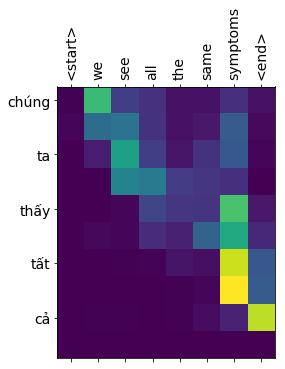


Input:  <start> we see vocal tremor weakness and rigidity <end>
Groundtruth:  <start> chúng ta thấy giọng run sự suy nhược và xơ cứng <end>
Translation:  <start> chúng ta thấy tiếng tăm và sự dũng cảm <end>
Bleu Score:  53.05700387751149

Input:  <start> the speech actually becomes quieter and more breathy after a while and thats one of the example symptoms of it <end>
Groundtruth:  <start> lời nói trở nên trầm lắng hơn và nhiều giọng gió hơn sau một thời gian và đó là một trong các triệu chứng ví dụ về nó <end>
Translation:  <start> bài nói chuyện đã trở nên vui vẻ hơn và nhiều lần nữa trong một trong số ví dụ về triệu chứng của nó <end>
Bleu Score:  52.76331810218101

Input:  <start> so these vocal effects can actually be quite subtle in some cases but with any digital microphone and using precision voice analysis software in combination with the latest in machine learning which is very advanced by now we can now quantify exactly where somebody lies on a continuum between health and

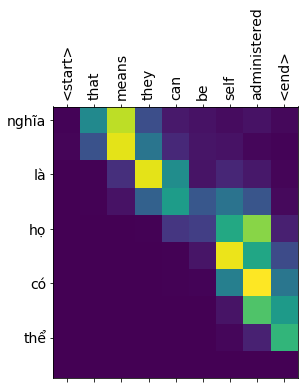


Input:  <start> theyre high speed take about 30 seconds at most <end>
Groundtruth:  <start> tốc độ nhanh chỉ mất khoảng 30 giây tối đa <end>
Translation:  <start> chúng là tốc độ cao tốc 30 giây <end>
Bleu Score:  49.12384518467891


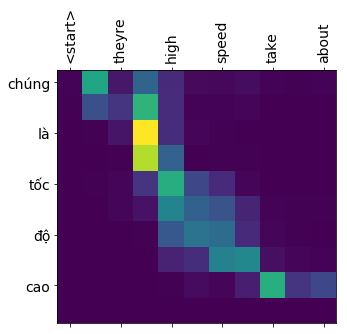


Input:  <start> theyre ultra low cost and we all know what happens <end>
Groundtruth:  <start> chi phí cực thấp và chúng ta đều biết điều gì sẽ xảy ra <end>
Translation:  <start> chúng là những giá thấp và chúng ta đều biết điều gì xảy ra <end>
Bleu Score:  75.0

Input:  <start> when something becomes ultra low cost it becomes massively scalable <end>
Groundtruth:  <start> khi một cái gì đó trở nên cực rẻ nó sẽ được phổ biến trên diện rộng <end>
Translation:  <start> khi có thể làm một nguồn nước có giá trị sẽ có thể có thể có thể có thể có thể có thể có thể có thể có thể có thể có thể có thể có thể có thể có thể có thể có thể có thể có thể có thể có thể có thể có thể có thể có
Bleu Score:  6.557377049180328

Input:  <start> so here are some amazing goals that i think we can deal with now <end>
Groundtruth:  <start> vì vậy đây là một số mục tiêu tuyệt vời mà tôi nghĩ rằng chúng tôi có thể làm bây giờ <end>
Translation:  <start> đây là một số những mục tiêu tuyệt vời mà tôi nghĩ chúng 

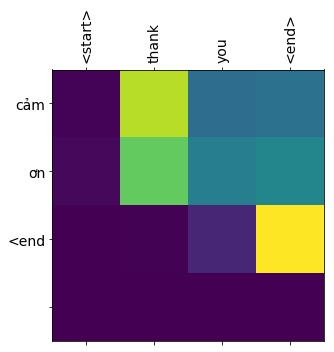


Input:  <start> so max by taking all these samples of lets say 10 000 people youll be able to tell whos healthy and whos not <end>
Groundtruth:  <start> tom rielly vậy max bằng cách lấy tất cả các mẫu cho là của 10 000 người đi bạn có thể cho biết ai khoẻ mạnh và ai không <end>
Translation:  <start> max rất nhiều nhất định này hãy nói 10 000 người bạn sẽ có thể nói với ai đó khoẻ mạnh và ai không <end>
Bleu Score:  47.59920963349246

Input:  <start> what are you going to get out of those samples <end>
Groundtruth:  <start> bạn sẽ kết luận được gì từ những mẫu này <end>
Translation:  <start> bạn sẽ ra khỏi những mẫu này <end>
Bleu Score:  55.73021304462805


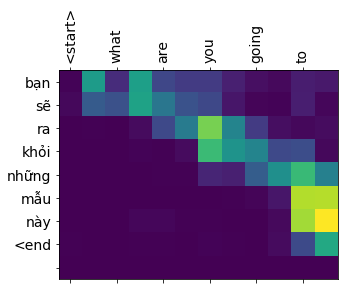


Input:  <start> yeah yeah so what will happen is that during the call you have to indicate whether or not you have the disease or not you see right <end>
Groundtruth:  <start> max little vâng vâng điều sẽ xảy ra là khi gọi bạn phải chỉ rõ bạn có bệnh hay không phải <end>
Translation:  <start> vâng đúng vậy điều đó sẽ xảy ra là trong khi mà bạn phải chỉ có hay không có những bệnh tật hay không thấy không <end>
Bleu Score:  57.14285714285714

Input:  <start> you see some people may not do it they may not get through it <end>
Groundtruth:  <start> bạn thấy đó một số người có thể không làm điều đó có thể họ không gọi tới được <end>
Translation:  <start> bạn thấy đấy một số người không thể làm được họ không thể vượt qua nó <end>
Bleu Score:  65.8374674914922

Input:  <start> but well get a very large sample of data that is collected from all different circumstances and its getting it in different circumstances that matter because then we are looking at ironing out the confounding factors a

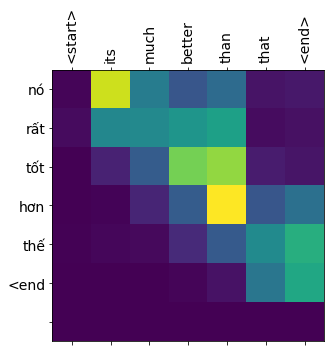


Input:  <start> actually my student thanasis i have to plug him because hes done some fantastic work and now he has proved that it works over the mobile telephone network as well which enables this project and were getting 99 percent accuracy <end>
Groundtruth:  <start> thực ra sinh viên của tôi thanasis tôi phải khen ngợi anh ta bởi vì anh ấy đã làm một số công việc tuyệt vời anh ta đã chứng minh được rằng điều này còn có thể thực hiện được qua mạng điện thoại di động nữa điều đó cho phép dự án này được thực hiện và độ chính xác đang đạt đến 99 phần trăm <end>
Translation:  <start> thực ra sinh viên của tôi tôi phải cắm trại cho anh ta vì anh ta đã làm một vài tác phẩm tuyệt vời và bây giờ anh ấy đã chứng minh rằng nó hoạt động hơn điện thoại di động như thế này cho phép dự án này và nó sẽ có được dự đoán và dự đoán được
Bleu Score:  56.076140944653396

Input:  <start> ninety nine well thats an improvement <end>
Groundtruth:  <start> chín mươi chín vâng một tiến bộ tớn <end>
Translat

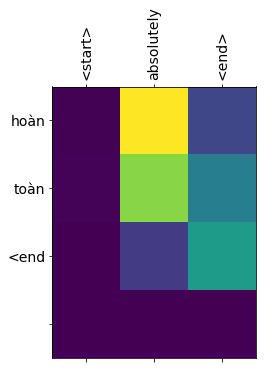


Input:  <start> thanks so much max little everybody <end>
Groundtruth:  <start> cảm ơn rất nhiều hoan nghênh max little nào mọi người <end>
Translation:  <start> cảm ơn rất nhiều người đều rất nhiều <end>
Bleu Score:  51.857275447720255


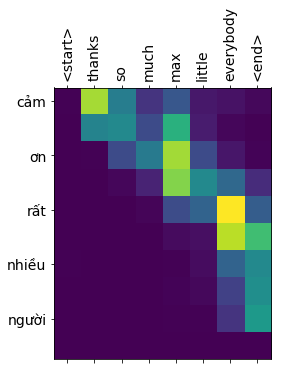


Input:  <start> thanks tom <end>
Groundtruth:  <start> cảm ơn nhiều tom <end>
Translation:  <start> cảm ơn <end>
Bleu Score:  60.653065971263345


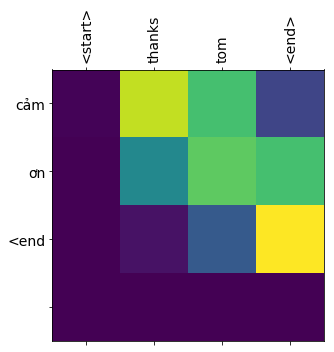


Input:  <start> i live in south central <end>
Groundtruth:  <start> tôi sống ở vùng trung nam <end>
Translation:  <start> tôi sống ở miền nam trung <end>
Bleu Score:  87.5


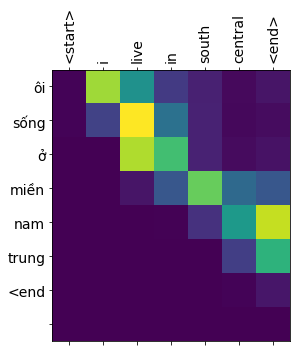


Input:  <start> this is south central liquor stores fast food vacant lots <end>
Groundtruth:  <start> đây là vùng trung nam cửa hàng rượu đồ ăn nhanh đất hoang <end>
Translation:  <start> đây là nam châm vàng đã mua sắm rất nhanh <end>
Bleu Score:  38.94003915357025

Input:  <start> so the city planners they get together and they figure theyre going to change the name south central to make it represent something else so they change it to south los angeles like this is going to fix whats really going wrong in the city <end>
Groundtruth:  <start> vì vậy các nhà hoạch định thành phố họp lại với nhau và họ định thay cái tên nam trung để nó mang ý nghĩa khác vậy nên họ đổi thành vùng nam los langeles như thể việc đó sẽ giải quyết được những rắc rối đang thực sự diễn ra trong thành phố <end>
Translation:  <start> vì thế nên các nhà hoạch định họ đã cùng nhau và họ hình dung họ sẽ thay đổi tên cho vùng miền nam phi để làm cho nó đại diện cho thấy một điều khác mà họ thay đổi nó đến với los a

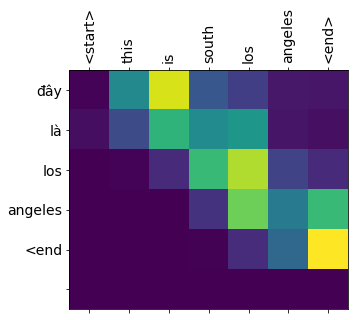


Input:  <start> liquor stores fast food vacant lots <end>
Groundtruth:  <start> cửa hàng rượu đồ ăn nhanh đất hoang <end>
Translation:  <start> bán hàng hoá nhanh <end>
Bleu Score:  34.227807935506135


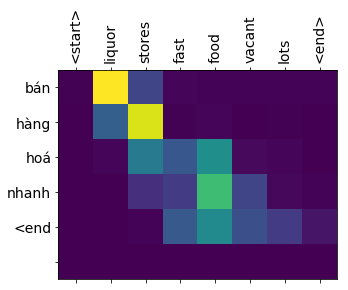


Input:  <start> just like 26 5 million other americans i live in a food desert south central los angeles home of the drive thru and the drive by <end>
Groundtruth:  <start> cũng giống như 26 5 triệu người mĩ khác tôi sống trong một sa mạc thức ăn vùng nam trung los angeles ngôi nhà của quầy phục vụ đồ ăn nhanh bên đường và gậy tai nạn rồi bỏ chạy <end>
Translation:  <start> chỉ như 26 5 triệu người mỹ tôi sống trong một môi trường ở miền đông los angeles về vùng lân cận thông qua và đi khỏi <end>
Bleu Score:  33.03767890199779

Input:  <start> funny thing is the drive thrus are killing more people than the drive bys <end>
Groundtruth:  <start> điều thú vị là đồ ăn nhanh bên đường đang giết chết nhiều người hơn gây tai nạn rồi bỏ chạy <end>
Translation:  <start> điều thú vị là việc lái xe là giết chết nhiều người hơn người lái xe hơn <end>
Bleu Score:  46.903868864508915

Input:  <start> people are dying from curable diseases in south central los angeles <end>
Groundtruth:  <start> ở n

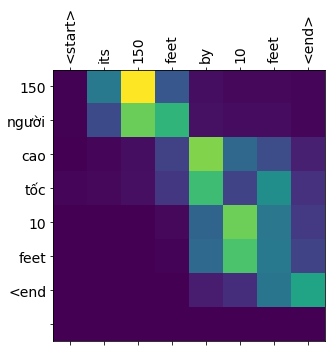


Input:  <start> thing is its owned by the city <end>
Groundtruth:  <start> vấn đề là mảnh đất đó thuộc về thành phố <end>
Translation:  <start> điều đó là nó là chính sách thành phố <end>
Bleu Score:  49.80549361539612

Input:  <start> but you have to maintain it <end>
Groundtruth:  <start> nhưng bạn phải trông giữ nó <end>
Translation:  <start> nhưng bạn phải giữ nó <end>
Bleu Score:  86.68778997501818


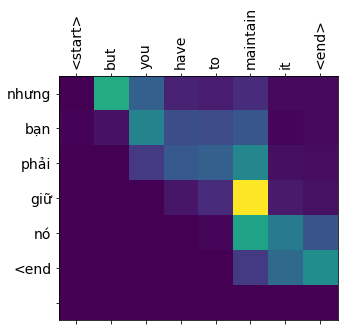


Input:  <start> so im like cool i can do whatever the hell i want since its my responsibility and i gotta maintain it <end>
Groundtruth:  <start> nên tôi nghĩ tuyệt tôi có thể làm việc gì tôi muốn bởi vì đó là trách nhiệm của tôi và tôi phải trông giữ nó <end>
Translation:  <start> tôi thích thú vị có thể làm bất cứ điều gì tôi muốn kể cả khi tôi muốn tôi muốn tôi muốn tôi muốn tôi muốn tôi muốn tôi muốn tôi muốn tôi muốn tôi muốn tôi muốn tôi muốn tôi muốn tôi muốn tôi muốn tôi muốn tôi muốn tôi muốn tôi muốn tôi muốn tôi muốn tôi muốn
Bleu Score:  18.0327868852459

Input:  <start> and this is how i decided to maintain it <end>
Groundtruth:  <start> và đây là cách mà tôi trông giữ mảnh đất đó <end>
Translation:  <start> và đây là cách mà tôi quyết định để giữ nó <end>
Bleu Score:  69.23076923076923

Input:  <start> so me and my group l a green grounds we got together and we started planting my food forest fruit trees you know the whole nine vegetables <end>
Groundtruth:  <start> tôi 

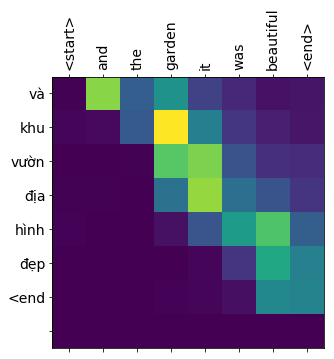


Input:  <start> and then somebody complained <end>
Groundtruth:  <start> rồi sau đó có người than phiền <end>
Translation:  <start> và rồi ai đó đã phàn nàn <end>
Bleu Score:  44.44444444444444


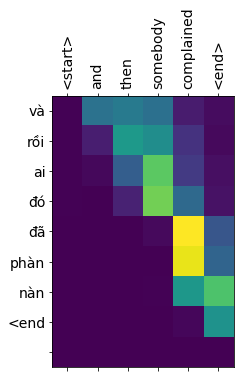


Input:  <start> the city came down on me and basically gave me a citation saying that i had to remove my garden which this citation was turning into a warrant <end>
Groundtruth:  <start> thành phố tới gặp tôi và đại khái là đưa cho tôi một công văn yêu cầu tôi phải phá bỏ mảnh vườn công văn đó sau này trở thành trát của toà <end>
Translation:  <start> thành phố đã xuống dưới tôi và đưa ra một trích dẫn nói rằng tôi phải loại bỏ lại khu vườn ghi lại ghi lại thành lập một câu trả lời <end>
Bleu Score:  37.07733703522067

Input:  <start> and im like come on really <end>
Groundtruth:  <start> và tôi như thể thôi nào thật à <end>
Translation:  <start> và tôi muốn nói về việc này <end>
Bleu Score:  39.77063630286087


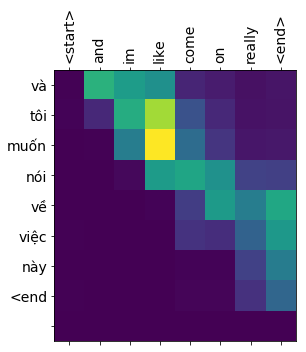


Input:  <start> a warrant for planting food on a piece of land that you could care less about <end>
Groundtruth:  <start> một trát hầu toà vì trồng cây trên mảnh đất mà các người không thèm quan tâm sao <end>
Translation:  <start> một tin nhắn cho việc trồng trồng thức ăn trên một khối u mà bạn có thể quan tâm ít hơn <end>
Bleu Score:  34.78260869565218

Input:  <start> and i was like cool bring it <end>
Groundtruth:  <start> và tôi nói rằng được mang tới đây <end>
Translation:  <start> và tôi thích thú vị <end>
Bleu Score:  37.225089001774606


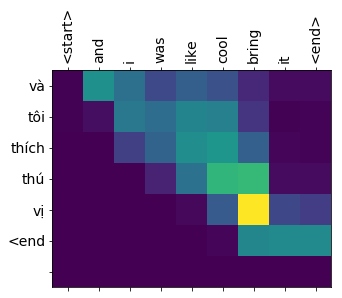


Input:  <start> because this time it wasnt coming up <end>
Groundtruth:  <start> vì lần này thì chuyện này không tới đâu <end>
Translation:  <start> bởi vì lần này không phải lên <end>
Bleu Score:  53.38249352778721


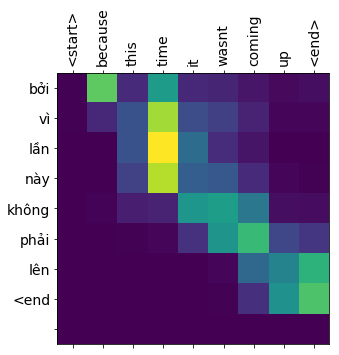


Input:  <start> so l a times got ahold of it steve lopez did a story on it and talked to the councilman and one of the green grounds members they put up a petition on change org and with 900 signatures we were a success <end>
Groundtruth:  <start> rồi tờ l a times nhận được tin steve lopez viết một bài báo về nó và bàn với uỷ viên hội đồng rồi một trong các thành viên của những mảnh đất xanh gửi một tờ đơn kiến nghị trên change org và với 900 chữ ký chúng tôi đã thành công <end>
Translation:  <start> và l a lần nữa có lần nữa <end>
Bleu Score:  0.5554498269121153


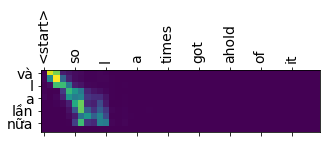


Input:  <start> we had a victory on our hands <end>
Groundtruth:  <start> chúng tôi đã có được một chiến thắng trong tay <end>
Translation:  <start> chúng tôi đã giành chiến thắng trong tay <end>
Bleu Score:  73.68576777701837


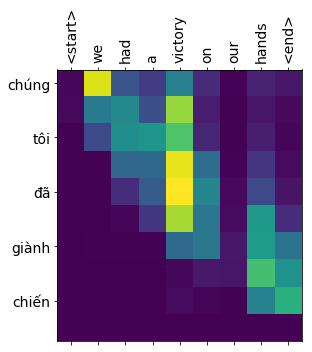


Input:  <start> my councilman even called in and said how they endorse and love what were doing <end>
Groundtruth:  <start> uỷ viên hội đồng đó thậm chí còn gọi tới và nói rằng họ tán thành và thích việc mà chúng tôi đang làm <end>
Translation:  <start> tôi không được gọi là họ làm thế nào và cảm nhận những gì chúng ta đang làm <end>
Bleu Score:  33.33681993067731

Input:  <start> i mean come on why wouldnt they <end>
Groundtruth:  <start> ý tôi là thôi nào tại sao lại không chứ <end>
Translation:  <start> ý tôi là tại sao tại sao họ không <end>
Bleu Score:  66.40732482052816

Input:  <start> l a leads the united states in vacant lots that the city actually owns <end>
Groundtruth:  <start> l a dẫn đầu nước mỹ về diện tích đất hoang mà thành phố sở hữu <end>
Translation:  <start> l a dẫn dắt nước mỹ bị lãng phí thành phố thực sự <end>
Bleu Score:  49.12384518467891

Input:  <start> they own 26 square miles of vacant lots <end>
Groundtruth:  <start> họ sở hữu 42 kilomet vuông đất bỏ hoa

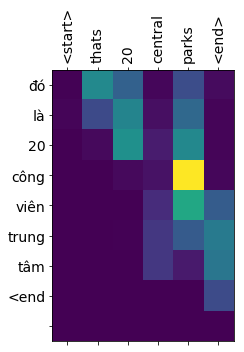


Input:  <start> thats enough space to plant 725 million tomato plants <end>
Groundtruth:  <start> đủ để trồng 725 triệu cây cà chua <end>
Translation:  <start> đó là không gian để trồng cây số nước sốt cà chua <end>
Bleu Score:  50.0

Input:  <start> why in the hell would they not okay this <end>
Groundtruth:  <start> làm sao họ có thể không đồng tình chứ <end>
Translation:  <start> tại sao nó sẽ không nên không <end>
Bleu Score:  35.5883290185248


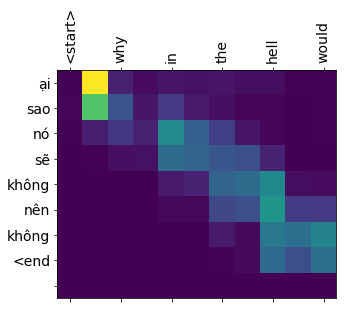


Input:  <start> growing one plant will give you 1 000 10 000 seeds <end>
Groundtruth:  <start> trồng một cây sẽ cho bạn 1 000 10 000 hạt giống <end>
Translation:  <start> trồng một cây cối sẽ cho bạn 1 000 thước dầu <end>
Bleu Score:  71.22777528017816

Input:  <start> when one dollars worth of green beans will give you 75 dollars worth of produce <end>
Groundtruth:  <start> khi lượng đậu xanh có giá 1 đô la sẽ cho bạn lượng sản phẩm tương đương với 75 đô la <end>
Translation:  <start> khi một đô la từ xanh lá sẽ mua cho bạn 75 bạn có thể làm cho việc <end>
Bleu Score:  47.338938703378176

Input:  <start> its my gospel when im telling people grow your own food <end>
Groundtruth:  <start> đó là đức tin của tôi khi tôi nói với mọi người hãy tự trồng lấy thực phẩm cho mình <end>
Translation:  <start> đó là âm nhạc của tôi khi tôi nói với mọi người lớn lên thức ăn của mình <end>
Bleu Score:  58.81443217233737

Input:  <start> growing your own food is like printing your own money <end>
Gro

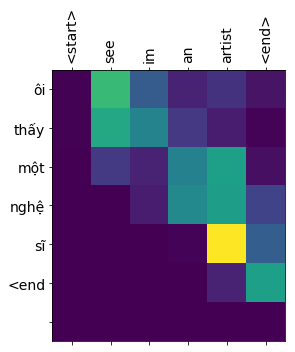


Input:  <start> gardening is my graffiti i grow my art <end>
Groundtruth:  <start> làm vườn là nghệ thuật của tôi tôi trồng ra tác phẩm của mình <end>
Translation:  <start> làm vườn là vẽ tôi vẽ tôi <end>
Bleu Score:  35.73311964723874


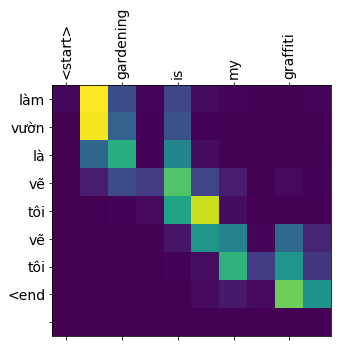


Input:  <start> just like a graffiti artist where they beautify walls me i beautiful lawns parkways <end>
Groundtruth:  <start> cũng giống như một hoạ sĩ người tô điểm cho các bức tường tôi tôi tô điểm cho những bãi cỏ lối đi dạo <end>
Translation:  <start> giống như một nghệ sĩ graffiti mà họ có tường những bức cắt những chiếc máy quay phim đẹp tôi <end>
Bleu Score:  37.8978599125082

Input:  <start> i use the garden the soil like its a piece of cloth and the plants and the trees thats my embellishment for that cloth <end>
Groundtruth:  <start> tôi sử dụng mảnh vườn đất trồng như một tấm vải và cây trồng và cây xanh là những gì tôi tô điểm cho tấm vải đó <end>
Translation:  <start> tôi sử dụng khu vườn đất như là một mảnh vải và cây cối và cây cối và đây là cây <end>
Bleu Score:  53.591749397714494

Input:  <start> youd be surprised what the soil could do if you let it be your canvas <end>
Groundtruth:  <start> bạn sẽ bất ngờ với những gì mà mảnh đất có thể làm nếu bạn biến chúng thà

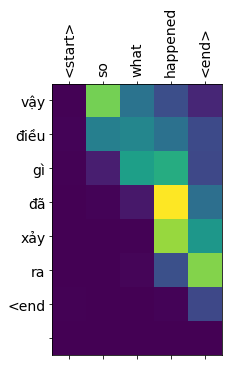


Input:  <start> i have witnessed my garden become a tool for the education a tool for the transformation of my neighborhood <end>
Groundtruth:  <start> tôi đã chứng kiến mảnh vườn của mình trở thành một công cụ giáo dục một công cụ cho sự chuyển đổi của vùng đất tôi sống <end>
Translation:  <start> tôi đã chứng kiến ở nhà tôi trở thành một công cụ cho công cụ cho công cụ cho sự vận chuyển của khu vực lân cận <end>
Bleu Score:  62.06896551724138

Input:  <start> to change the community you have to change the composition of the soil <end>
Groundtruth:  <start> để thay đổi cộng đồng bạn phải thay đổi thành phần của đất <end>
Translation:  <start> để thay đổi cộng đồng bạn phải thay đổi sự sống của đất <end>
Bleu Score:  86.66666666666667

Input:  <start> we are the soil <end>
Groundtruth:  <start> chúng ta là đất <end>
Translation:  <start> chúng ta là đất <end>
Bleu Score:  100.0


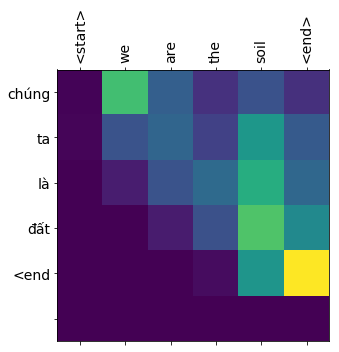


Input:  <start> youd be surprised how kids are affected by this <end>
Groundtruth:  <start> bạn sẽ ngạc nhiên khi thấy cách mà những đứa trẻ bị ảnh hưởng <end>
Translation:  <start> bạn sẽ ngạc nhiên khi trẻ em bị ảnh hưởng bởi điều này <end>
Bleu Score:  68.6038455689853

Input:  <start> gardening is the most therapeutic and defiant act you can do especially in the inner city <end>
Groundtruth:  <start> làm vườn là công việc có tính trị liệu nhất và thách thức nhất mà bạn có thể làm đặc biệt là ở trong nội thành <end>
Translation:  <start> làm vườn là làm chữa trị và cách hành động bạn có thể làm đặc biệt trong môi trường <end>
Bleu Score:  47.76875403825262

Input:  <start> plus you get strawberries <end>
Groundtruth:  <start> với lại bạn còn thu được dâu nữa <end>
Translation:  <start> thêm vào đó bạn có thể dâu <end>
Bleu Score:  39.77063630286087


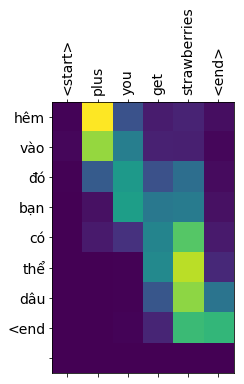


Input:  <start> i remember this time there was this mother and a daughter came it was like 10 30 at night and they were in my yard and i came out and they looked so ashamed <end>
Groundtruth:  <start> tôi nhớ có một lần có một người mẹ và con gái tới lúc đó là khoảng 10 30 tối và họ ở trong vườn của tôi rồi tôi đi ra ngoài và họ rất xấu hổ <end>
Translation:  <start> tôi nhớ lần này có con mẹ và con gái đến đây là như 10 30 đêm và họ ở ngoài và tôi đi ra và họ nhìn thấy xấu hổ <end>
Bleu Score:  60.63657586001313

Input:  <start> so im like man it made me feel bad that they were there and i told them you know you dont have to do this like this <end>
Groundtruth:  <start> tôi nghĩ trời ạ tôi cảm thấy rất tệ vì họ ở đó và tôi nói với họ rằng hai người biết đấy không cần phải làm như vậy <end>
Translation:  <start> tôi thích người đàn ông làm tôi cảm thấy xấu hổ họ nói với họ biết đấy bạn không có tác dụng như thế này <end>
Bleu Score:  51.09945818271163

Input:  <start> this is on the s

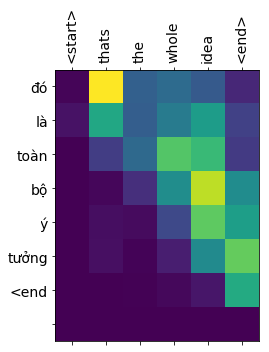


Input:  <start> i want them to take it but at the same time i want them to take back their health <end>
Groundtruth:  <start> tôi muốn họ lấy chúng nhưng cùng lúc đó tôi muốn họ có lại được sức khoẻ của mình <end>
Translation:  <start> tôi muốn họ cần nó nhưng cùng lúc tôi muốn họ trở lại sức khoẻ của họ <end>
Bleu Score:  71.05954944096784

Input:  <start> theres another time when i put a garden in this homeless shelter in downtown los angeles <end>
Groundtruth:  <start> có một lần khác khi tôi làm vườn tại một khu vô gia cư ở trung tâm los angeles <end>
Translation:  <start> có một lần nữa khi tôi đặt một khu vườn nhỏ ở nơi cư trú ở los angeles <end>
Bleu Score:  66.58605971504997

Input:  <start> these are the guys they helped me unload the truck <end>
Groundtruth:  <start> có mấy người đàn ông họ giúp tôi dỡ đồ từ xe tải <end>
Translation:  <start> đây là những người này giúp đỡ tôi tải giảm xóc xe tải <end>
Bleu Score:  46.666666666666664

Input:  <start> it was cool and they jus

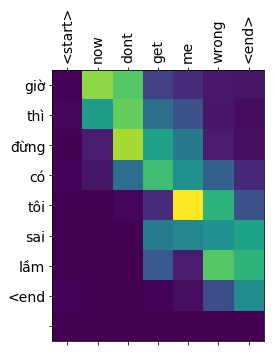


Input:  <start> im not talking about no free shit because free is not sustainable <end>
Groundtruth:  <start> tôi không nói về những thứ miễn phí bởi miễn phí thì không bền vững <end>
Translation:  <start> tôi không nói về không không tự do nào miễn phí không có bền vững <end>
Bleu Score:  64.70588235294117

Input:  <start> the funny thing about sustainability you have to sustain it <end>
Groundtruth:  <start> điều thú vị về sự bền vững đó là bạn phải duy trì nó <end>
Translation:  <start> điều thú vị về sự bền vững bạn phải duy trì nó <end>
Bleu Score:  86.68778997501818

Input:  <start> what im talking about is putting people to work and getting kids off the street and letting them know the joy the pride and the honor in growing your own food opening farmers markets <end>
Groundtruth:  <start> tôi đang nói về việc giao công việc cho mọi người và kéo bọn trẻ ra khỏi phố và cho chúng biết niềm vui niềm tự hào và niềm vinh dự khi tự trồng thực phẩm cho mình mở chợ cho nông dân <end>
Tr

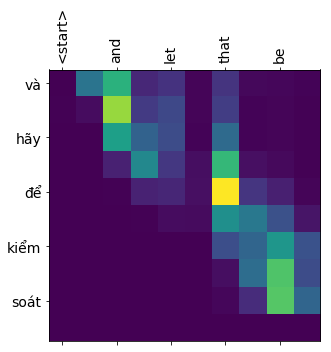


Input:  <start> so basically if you want to meet with me you know if you want to meet dont call me if you want to sit around in cushy chairs and have meetings where you talk about doing some shit where you talk about doing some shit <end>
Groundtruth:  <start> căn bản là nếu bạn muốn gặp tôi bạn biết đấy nếu bạn muốn gặp đừng gọi tôi nếu bạn muốn ngồi không trên những chiếc ghế êm ái và tham gia những cuộc họp nơi bạn nói về làm này làm nọ nơi bạn nói về làm này làm nọ vớ vẩn <end>
Translation:  <start> vì thế nên đơn giản là nếu bạn muốn gặp mặt với các bạn biết đấy nếu bạn muốn gặp tôi không tôi gọi nếu tôi muốn ngồi quanh sân khấu nào và có cuộc họp bạn nói về việc làm một số ít chỗ bạn sẽ nói về việc làm một số ít chỗ bạn sẽ nói về việc
Bleu Score:  52.459016393442624

Input:  <start> if you want to meet with me come to the garden with your shovel so we can plant some shit <end>
Groundtruth:  <start> nếu bạn muốn gặp tôi hãy ra vườn cùng với chiếc xẻng của bạn và ta sẽ trồng vài t

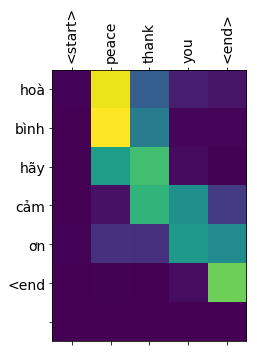


Input:  <start> thank you <end>
Groundtruth:  <start> cảm ơn <end>
Translation:  <start> cảm ơn <end>
Bleu Score:  100.0


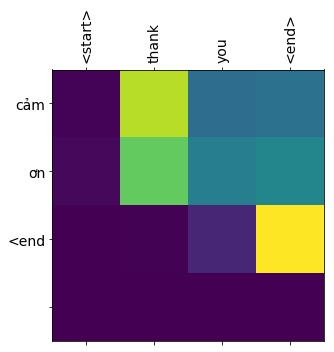


Input:  <start> this is where i live i live in kenya at the south parts of the nairobi national park <end>
Groundtruth:  <start> đây là nơi tôi sống tôi sống ở kenya phía nam công viên quốc gia nairobi <end>
Translation:  <start> đây là nơi tôi sống ở kenya ở nam cực của nam giới <end>
Bleu Score:  54.5820502051988

Input:  <start> those are my dads cows at the back and behind the cows thats the nairobi national park <end>
Groundtruth:  <start> phía sau tôi là đàn bò của bố tôi và phía sau đàn bò là công viên quốc gia nairobi <end>
Translation:  <start> đó là những con trai của tôi ở vùng mẹ và sau các con bò vẫn là người dân tộc là người dân tộc của gia đình <end>
Bleu Score:  34.48275862068966

Input:  <start> nairobi national park is not fenced in the south widely which means wild animals like zebras migrate out of the park freely <end>
Groundtruth:  <start> công viên quốc gia nairobi không được rào chắn trên diện rộng ở khu vực phía nam điều đó có nghĩa là các động vật hoang dã nh

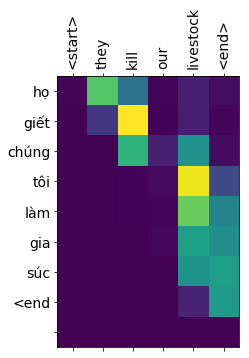


Input:  <start> this is one of the cows which was killed at night and i just woke up in the morning and i found it dead and i felt so bad because it was the only bull we had <end>
Groundtruth:  <start> đây là một trong số những con bò đã bị giết vào buổi tối và khi thức dậy vào buổi sáng tôi tìm thấy nó đã chết và tôi đã cảm thấy rất buồn bởi vì đó là con bò đực duy nhất mà chúng tôi có <end>
Translation:  <start> đây là một con bò được giết vào đêm và tôi thức dậy vào buổi sáng và tôi thấy nó chết và tôi cảm thấy chán vì nó là người đàn ông ấy có <end>
Bleu Score:  52.267617049358414

Input:  <start> my community the maasai we believe that we came from heaven with all our animals and all the land for herding them and thats why we value them so much <end>
Groundtruth:  <start> cộng đồng của tôi người maasai tin rằng chúng tôi đến từ thiên đường cùng với tất cả các con vật của mình và tất cả đất đai để chăn giữ chúng đó là lý do vì sao chúng tôi rất coi trọng chúng <end>
Translation:  

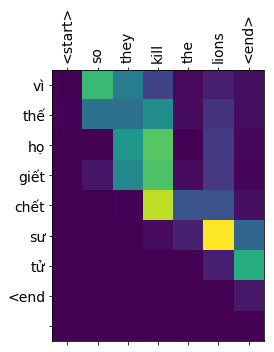


Input:  <start> its one of the six lions which were killed in nairobi <end>
Groundtruth:  <start> đây là một trong sáu con sư tử đã bị giết ở nairobi <end>
Translation:  <start> đó là một con sư tử mà chúng tôi đã giết ở nairobi <end>
Bleu Score:  73.33333333333333

Input:  <start> and i think this is why the nairobi national park lions are few <end>
Groundtruth:  <start> và tôi nghĩ đây là lý do mà sư tử ở công viên quốc gia nairobi còn rất ít <end>
Translation:  <start> và tôi nghĩ đây là tại sao ở nairobi quốc gia của hai của một số <end>
Bleu Score:  51.729438743315306

Input:  <start> so a boy from six to nine years old in my community is responsible for his dads cows and thats the same thing which happened to me <end>
Groundtruth:  <start> mỗi đứa con trai từ 6 đến 9 tuổi trong cộng đồng của tôi chịu trách nhiệm chăn giữ những con bò của bố mình và tôi cũng phải làm điều tương tự <end>
Translation:  <start> một cậu bé từ 6 đến 6 năm tuổi trong cộng đồng của tôi được chịu trách n

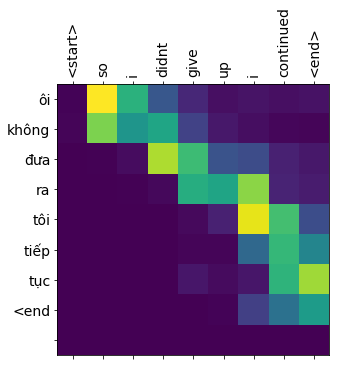


Input:  <start> and a second idea i got was to use a scarecrow <end>
Groundtruth:  <start> và ý tưởng thứ hai của tôi đó là sử dụng bù nhìn <end>
Translation:  <start> và ý tưởng thứ hai tôi phải dùng để tìm ra một con muỗi đi <end>
Bleu Score:  47.05882352941176

Input:  <start> i was trying to trick the lions 91 into thinking 93 that i was standing near the cowshed <end>
Groundtruth:  <start> tôi đã cố gắng đánh lừa những con sư tử đó 91 vào cái suy nghĩ 93 là tôi đứng gần chuồng bò <end>
Translation:  <start> tôi đang cố gắng lừa bịp bợm này vào trong suy nghĩ rằng tôi đang đứng gần giống chuồng bò <end>
Bleu Score:  55.52433681896333

Input:  <start> but lions are very clever <end>
Groundtruth:  <start> nhưng sư tử rất thông minh <end>
Translation:  <start> nhưng những con sư tử rất thông minh <end>
Bleu Score:  80.0


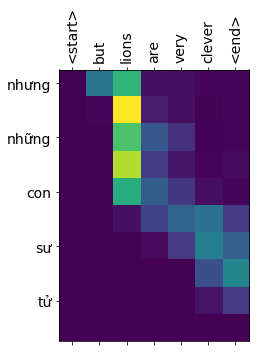


Input:  <start> they will come the first day and they see the scarecrow and they go back but the second day theyll come and they say this thing is not moving here its always here <end>
Groundtruth:  <start> chúng tới ngày đầu tiên và nhìn thấy con bù nhìn và rồi chúng quay về nhưng ngày thứ 2 chúng đến và nói rằng thứ này không hề chuyển động nó luôn luôn chỉ ở đó <end>
Translation:  <start> họ sẽ đến ngày đầu tiên họ nhìn thấy con bọ đi và chúng trở lại nhưng rồi lần thứ hai sẽ đến và họ nói điều này không phải di chuyển ở đây nó luôn ở đây <end>
Bleu Score:  55.00000000000001

Input:  <start> so he jumps in and kills the animals <end>
Groundtruth:  <start> và rồi sư tử nhảy vào và giết gia súc <end>
Translation:  <start> nên ông ấy nhảy nhảy và giết chết con vật <end>
Bleu Score:  41.66666666666667

Input:  <start> so one night i was walking around the cowshed with a torch and that day the lions didnt come <end>
Groundtruth:  <start> vì thế vào một đêm tôi cầm một cây đuốc đi xung q

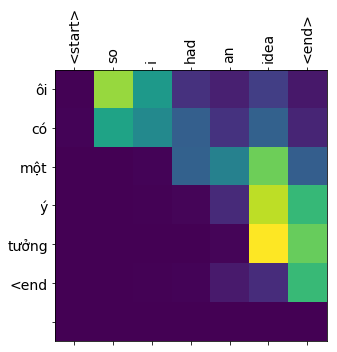


Input:  <start> since i was a small boy i used to work in my room for the whole day and i even took apart my moms new radio and that day she almost killed me but i learned a lot about electronics <end>
Groundtruth:  <start> từ khi còn nhỏ tôi đã từng làm việc ở trong phòng mình cả ngày và tôi thậm chí đã mở tung chiếc radio mới mua của mẹ vào hôm đó bà gần như giết tôi nhưng tôi đã học được nhiều điều về điện <end>
Translation:  <start> kể từ khi tôi là một cậu bé tôi quen với việc trong phòng khách hàng ngày và tôi thậm chí còn đi bộ mẹ tôi chợt phát ra và tôi ngày càng bị giết tôi nhưng tôi đã học được nhiều hơn về điện tử <end>
Bleu Score:  52.083333333333336

Input:  <start> so i got an old car battery an indicator box its a small device found in a motorcycle and it helps motorists when they want to turn right or left it blinks <end>
Groundtruth:  <start> thế nên tôi đã lấy một bình ắc quy xe ô tô cũ một hộp đồng hồ đo nó là một thiết bị nhỏ được tìm thấy ở xe mô tô và nó giúp ngư

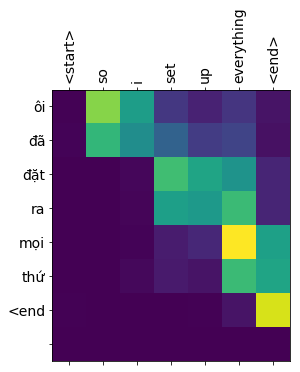


Input:  <start> as you can see the solar panel charges the battery and the battery supplies the power to the small indicator box i call it a transformer <end>
Groundtruth:  <start> như các bạn có thể thấy tấm pin mặt trời dùng để xạc ắc quy và bình ắc quy cung cấp năng lượng cho hộp đồng hồ đo tôi gọi nó là máy biến thế <end>
Translation:  <start> như bạn có thể thấy dải quang năng lượng pin mặt pin và pin chức năng lượng điện năng lượng nhỏ bé nhỏ mà tôi gọi nó là một cái máy bay hơi <end>
Bleu Score:  45.87372951117939

Input:  <start> and the indicator box makes the lights flash <end>
Groundtruth:  <start> và chiếc hộp đồng hồ đo làm cho đèn chớp tắt <end>
Translation:  <start> và những nốt âm thanh của việc tạo ra ánh sáng chớp <end>
Bleu Score:  28.57142857142857

Input:  <start> as you can see the bulbs face outside because thats where the lions come from <end>
Groundtruth:  <start> như các bạn thấy đó các bóng đèn hướng ra phía ngoài bởi vì đó là hướng sư tử tiến vào <end>
Tran

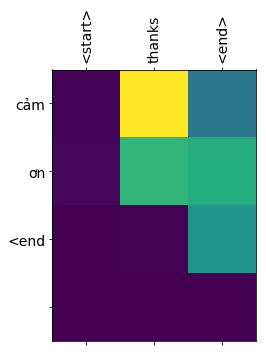


Input:  <start> so i set it up in my home two years ago and since then we have never experienced any problem with lions <end>
Groundtruth:  <start> tôi đã lắp đặt nó ở nhà mình 2 năm trước kể từ đó chúng tôi không hề gặp phải bất cứ vấn đề nào với sư tử cả <end>
Translation:  <start> tôi đã đưa nó trong 2 năm trước và từ đó và chúng tôi chưa bao giờ trải qua bất kỳ vấn đề gì với những con sư tử <end>
Bleu Score:  58.06451612903226

Input:  <start> and my neighboring homes heard about this idea <end>
Groundtruth:  <start> các gia đình hàng xóm nghe kể về ý tưởng này <end>
Translation:  <start> và những nhà nước tôi đã nghe về ý tưởng này <end>
Bleu Score:  53.84615384615385

Input:  <start> one of them was this grandmother <end>
Groundtruth:  <start> một trong số đó là người bà này <end>
Translation:  <start> một trong số đó là bà ấy <end>
Bleu Score:  79.54127260572174


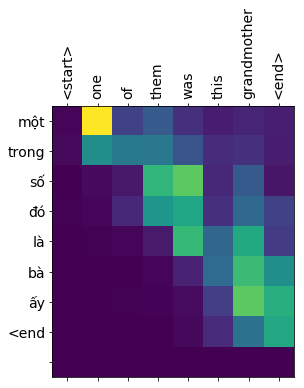


Input:  <start> she had a lot of her animals being killed by lions and she asked me if i could put the lights for her <end>
Groundtruth:  <start> bà có nhiều gia súc đã bị sư tử giết và bà đã hỏi tôi liệu tôi có thể giúp bà lắp các bóng điện <end>
Translation:  <start> cô ấy đã có rất nhiều con vật bị giết bởi sư tử và cô ấy hỏi tôi nếu tôi có thể đèn đèn cho cô <end>
Bleu Score:  53.57142857142857

Input:  <start> and i said yes <end>
Groundtruth:  <start> tôi trả lời vâng <end>
Translation:  <start> và tôi trả lời đúng <end>
Bleu Score:  71.42857142857143


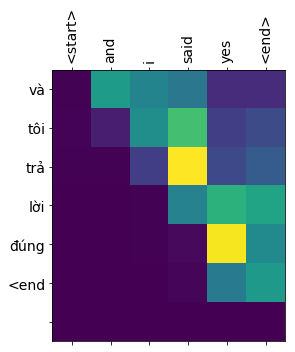


Input:  <start> so i put the lights you can see at the back those are the lion lights <end>
Groundtruth:  <start> thế là tôi lắp đặt các bóng đèn các bạn có thể nhìn thấy ở đằng sau chúng là các bóng đèn sư tử <end>
Translation:  <start> vì vậy tôi sẽ thắp sáng bạn có thể thấy ở đây là những con sư tử <end>
Bleu Score:  40.05307409460888

Input:  <start> since now ive set up seven homes around my community and theyre really working <end>
Groundtruth:  <start> cho đến nay tôi đã giúp lắp đặt cho 7 hộ gia đình trong cộng đồng của mình và chúng đều hoạt động hiệu quả <end>
Translation:  <start> kể từ giờ tôi đã làm việc trong 7 nhà hàng xóm quanh tôi và họ đang thực hiện <end>
Bleu Score:  25.049243102509532

Input:  <start> and my idea is also being used now all over kenya for scaring other predators like hyenas leopards and its also being used to scare elephants away from peoples farms <end>
Groundtruth:  <start> hiện nay ý tưởng của tôi đã được sử dụng trên khắp kenya để xua đuổi các 

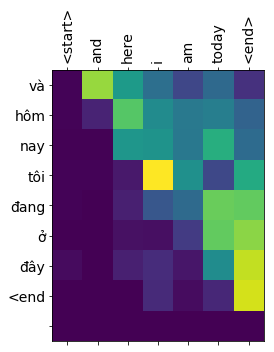


Input:  <start> i got a chance to come by plane for my first time for ted <end>
Groundtruth:  <start> tôi đã có cơ hội đi đến đây bằng máy bay lần đầu tiên để tham gia ted <end>
Translation:  <start> tôi có cơ hội để đi đến máy bay lần đầu tiên của ted <end>
Bleu Score:  73.0125734129442

Input:  <start> so my big dream is to become an aircraft engineer and pilot when i grow up <end>
Groundtruth:  <start> ước mơ lớn nhất của tôi là trở thành một kỹ sư máy bay và phi công khi lớn lên <end>
Translation:  <start> vì vậy thì tôi mơ ước của tôi là trở thành một kỹ sư máy bay và tôi phát triển <end>
Bleu Score:  68.18181818181817

Input:  <start> i used to hate lions but now because my invention is saving my fathers cows and the lions we are able to stay with the lions without any conflict <end>
Groundtruth:  <start> tôi đã từng ghét sư tử nhưng bây giờ bởi vì phát minh của tôi đang cứu đàn bò của bố và sư tử chúng tôi có thể sống chung với sư tử mà không có bất cứ xung đột nào <end>
Transl

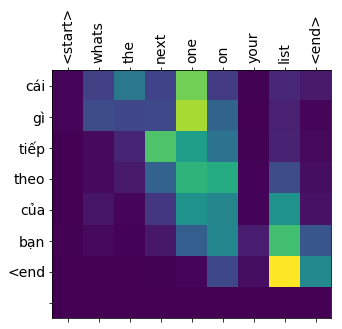


Input:  <start> my next invention is i want to make an electric fence electric fence <end>
Groundtruth:  <start> phát minh sắp tới của cháu cháu muốn làm một hàng rào điện hàng rào điện sao <end>
Translation:  <start> sáng tạo ra tôi là tôi muốn tạo ra một cái xe điện <end>
Bleu Score:  25.530944612154954

Input:  <start> but i know electric fences are already invented but i want to make mine <end>
Groundtruth:  <start> cháu biết là hàng rào điện đã được phát minh rồi nhưng cháu muốn làm cái của riêng mình <end>
Translation:  <start> nhưng tôi biết đấy những hàng rào chắn đã phát minh nhưng tôi muốn làm cho tôi <end>
Bleu Score:  52.11033625670976

Input:  <start> you already tried it once right and you i tried it before but i stopped because it gave me a shock <end>
Groundtruth:  <start> cháu đã thử đúng không và cháu cháu đó thử trước đây nhưng cháu đã dừng lại vì bị giật điện <end>
Translation:  <start> bạn đã thử nó đã và tôi cố gắng trước đây nhưng tôi đã bị bỏ nó bởi vì nó đã đư

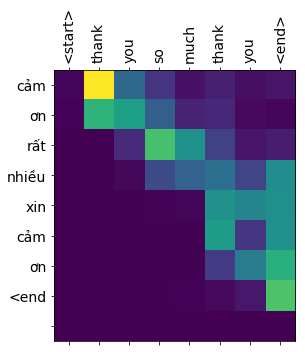


Input:  <start> everything i do and everything i do professionally my life has been shaped by seven years of work as a young man in africa <end>
Groundtruth:  <start> những gì tôi làm và những gì tôi làm chuyên về cuộc đời tôi đã được đinh hình trong bảy năm làm việc tại châu phi khi còn trẻ <end>
Translation:  <start> mọi thứ tôi làm và mọi thứ tôi làm nghề nghiệp của tôi đã được hình thành bởi bảy năm làm việc như một người đàn ông ở afghanistan <end>
Bleu Score:  48.38709677419355

Input:  <start> from 1971 to 1977 i look young but im not i worked in zambia kenya ivory coast algeria somalia in projects of technical cooperation with african countries <end>
Groundtruth:  <start> từ năm 1971 đến 1977 trông tôi trẻ thế chứ không phải vậy đâu tôi đã làm việc tại zambia kenya ivory coast algeria somalia trong những dự án hợp tác về kỹ thuật với những quốc gia châu phi <end>
Translation:  <start> năm 1958 đến năm 1977 tôi nhìn tôi nhưng tôi không tôi đã làm việc ở zambia kenya takaungu ke

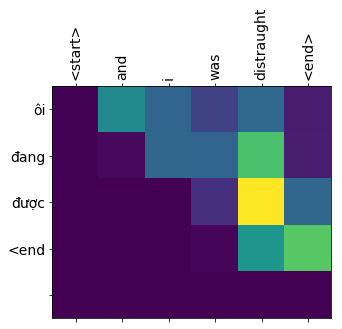


Input:  <start> i thought age 21 that we italians were good people and we were doing good work in africa <end>
Groundtruth:  <start> mới 21 tuổi đời tôi nghĩ người ý là người tốt và chúng tôi đang làm việc tốt tại châu phi <end>
Translation:  <start> tôi đã nghĩ rằng 99 tuổi mà chúng ta đã là người tốt là chúng tôi là những người tốt và chúng tôi đang làm tốt trong châu phi <end>
Bleu Score:  54.83870967741935

Input:  <start> instead everything we touched we killed <end>
Groundtruth:  <start> nhưng thay vì thế chúng tôi giết chết mọi thứ mà chúng tôi đụng vào <end>
Translation:  <start> thay vào tất cả mọi thứ chúng ta chạm vào chúng ta đã giết chết <end>
Bleu Score:  58.82352941176471

Input:  <start> our first project the one that has inspired my first book ripples from the zambezi was a project where we italians decided to teach zambian people how to grow food <end>
Groundtruth:  <start> dự án đầu tiên cái đã truyền cảm hứng cho cuốn sách đầu tiên của tôi những cơn sóng nhẹ từ zam

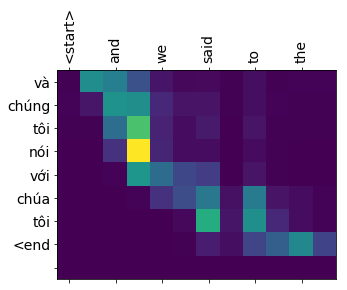


Input:  <start> and the zambians said yes thats why we have no agriculture here <end>
Groundtruth:  <start> và người dân đáp rằng vâng đó là lí do tại sao chúng tôi chẳng trồng thứ gì ở đây cả <end>
Translation:  <start> và điều này nói vâng vâng đó là tại sao chúng ta không có nông nghiệp ở đây <end>
Bleu Score:  47.338938703378176

Input:  <start> quot why didnt you tell us you never asked <end>
Groundtruth:  <start> quot thế tại sao mọi người không cho chúng tôi biết trước anh có bao giờ hỏi đâu <end>
Translation:  <start> quot tại sao bạn không cho chúng ta không bao giờ hỏi <end>
Bleu Score:  51.184497377440074

Input:  <start> i thought it was only us italians blundering around africa but then i saw what the americans were doing what the english were doing what the french were doing and after seeing what they were doing i became quite proud of our project in zambia <end>
Groundtruth:  <start> tôi đã nghĩ chỉ có mỗi người ý là khờ khạo trên đất châu phi nhưng sau đó khi tôi nhìn 

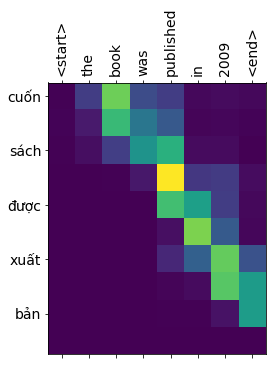


Input:  <start> we western donor countries have given the african continent two trillion american dollars in the last 50 years <end>
Groundtruth:  <start> chúng ta những quốc gia viện trợ tây phương đã mang đến lục địa châu phi 2 tỉ tỉ mỹ kim trong vòng 50 năm qua <end>
Translation:  <start> chúng ta những nước sốt rét đã có được châu phi 2 tỉ tỉ siling <end>
Bleu Score:  33.878930134499804

Input:  <start> im not going to tell you the damage that that money has done <end>
Groundtruth:  <start> tôi sẽ không nói với bạn những thiệt hại mà số tiền đó đã gây ra <end>
Translation:  <start> tôi sẽ không nói với các bạn biết những tổn thương mà tiền đó đã làm <end>
Bleu Score:  72.22222222222221

Input:  <start> just go and read her book <end>
Groundtruth:  <start> hãy tìm đọc cuốn sách của bà ấy <end>
Translation:  <start> chỉ cần đọc cuốn sách của cô ấy <end>
Bleu Score:  70.0


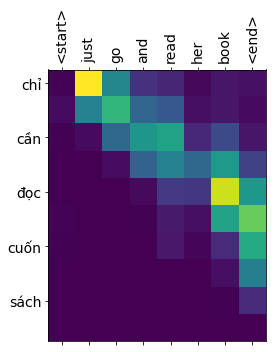


Input:  <start> read it from an african woman the damage that we have done <end>
Groundtruth:  <start> đọc nó từ một người phụ nữ châu phi những thiệt hại mà chúng ta đã gây ra <end>
Translation:  <start> đọc được từ một người phụ nữ châu phi mà chúng ta đã làm <end>
Bleu Score:  68.14506851874793

Input:  <start> we western people are imperialist colonialist missionaries and there are only two ways we deal with people we either patronize them or we are paternalistic <end>
Groundtruth:  <start> những người tây phương như chúng ta là những người theo chủ nghĩa đế quốc thực dân truyền giáo và chúng ta chỉ có hai cách để đối xử với người khác hoặc bảo trợ hoặc bảo hộ <end>
Translation:  <start> chúng ta phương tây người ta đều được đặt vào việc chống lại là phụ trách nhiệm vụ và phụ nữ chỉ có hai cách chúng ta đối mặt với những người chúng ta hay chúng ta hay không <end>
Bleu Score:  46.34146341463415

Input:  <start> the two words come from the latin root pater which means father <end>


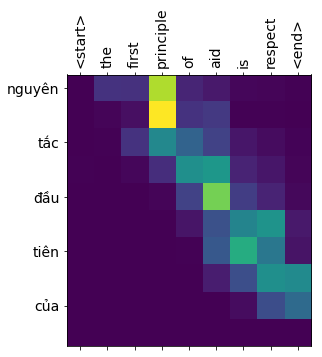


Input:  <start> this morning the gentleman who opened this conference lay a stick on the floor and said can we can you imagine a city that is not neocolonial <end>
Groundtruth:  <start> sáng nay người tổ chức buổi họp này đặt một cây gậy ra sàn nhà và nói liệu chúng ta có thể hình dung về một thành phố mà không phải là chủ nghĩa thực dân mới không <end>
Translation:  <start> buổi sáng nay người anh đã mở bài này là một cái que diêm vào và đóng đinh có thể có thể tưởng tượng thành phố mà không thể không <end>
Bleu Score:  41.37379160066838

Input:  <start> i decided when i was 27 years old to only respond to people and i invented a system called enterprise facilitation where you never initiate anything you never motivate anybody but you become a servant of the local passion the servant of local people who have a dream to become a better person <end>
Groundtruth:  <start> khi 27 tuổi tôi đã quyết định chỉ hưởng ứng với mọi người và tôi đã tạo ra một hệ thống gọi là enterprise facilitati

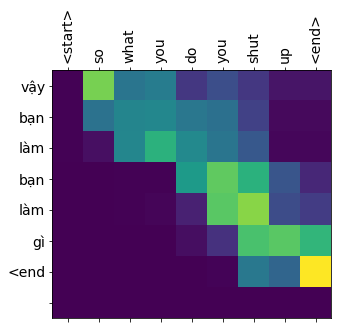


Input:  <start> you never arrive in a community with any ideas and you sit with the local people <end>
Groundtruth:  <start> đừng bao giờ mang đến một cộng đồng với những ý tưởng bạn ngồi với người bản địa <end>
Translation:  <start> bạn không bao giờ đến một cộng đồng với bất cứ ai đó ngồi cạnh địa phương <end>
Bleu Score:  59.91975663261708

Input:  <start> we dont work from offices <end>
Groundtruth:  <start> chúng tôi không làm việc từ những văn phòng <end>
Translation:  <start> chúng tôi không làm việc từ văn phòng <end>
Bleu Score:  90.48374180359595


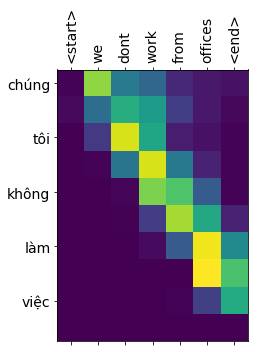


Input:  <start> we meet at the cafe we meet at the pub <end>
Groundtruth:  <start> chúng tôi gặp gỡ tại quán cà phê quán rượu <end>
Translation:  <start> chúng tôi gặp nhau ở quán cà phê espresso bar ở quán rượu <end>
Bleu Score:  66.66666666666666

Input:  <start> we have zero infrastructure <end>
Groundtruth:  <start> chúng tôi không có bất cứ cơ sở hạ tầng nào <end>
Translation:  <start> chúng ta có cơ sở hạ tầng <end>
Bleu Score:  56.99381230488485


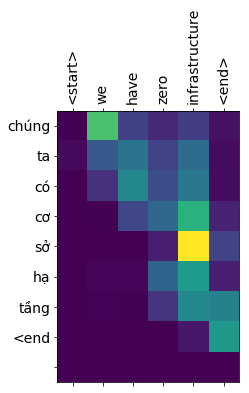


Input:  <start> and what we do we become friends and we find out what that person wants to do <end>
Groundtruth:  <start> và cái chúng tôi làm là trở thành bạn của nhau và tìm ra cái mà người đó muốn làm <end>
Translation:  <start> và những gì chúng ta làm gì chúng ta trở thành bạn bè và chúng tôi tìm ra những người muốn làm <end>
Bleu Score:  62.5

Input:  <start> the most important thing is passion <end>
Groundtruth:  <start> cái quan trọng nhất là khát vọng <end>
Translation:  <start> điều quan trọng nhất là đam mê <end>
Bleu Score:  66.66666666666666


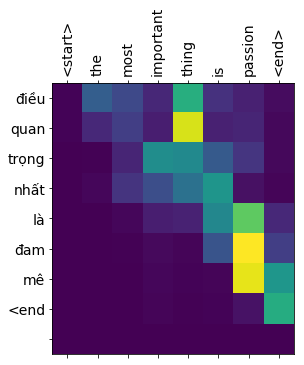


Input:  <start> you can give somebody an idea <end>
Groundtruth:  <start> bạn có thể cho ai đó một ý tưởng <end>
Translation:  <start> bạn có thể cho ai đó một ý tưởng <end>
Bleu Score:  100.0

Input:  <start> if that person doesnt want to do it what are you going to do <end>
Groundtruth:  <start> nếu người đó không muốn làm vậy thì bạn phải làm sao <end>
Translation:  <start> nếu người đó không muốn làm điều đó bạn sẽ làm gì <end>
Bleu Score:  71.42857142857143

Input:  <start> the passion that the person has for her own growth is the most important thing <end>
Groundtruth:  <start> cái khát vọng của người phụ nữ có cho sự phát triển của bản thân là thứ quan trọng nhất <end>
Translation:  <start> niềm đam mê rằng người đã có sự giúp đỡ của mình là một điều quan trọng nhất <end>
Bleu Score:  45.241870901797974

Input:  <start> the passion that that man has for his own personal growth is the most important thing <end>
Groundtruth:  <start> cái khát vọng của nam giới có cho sự phát triể

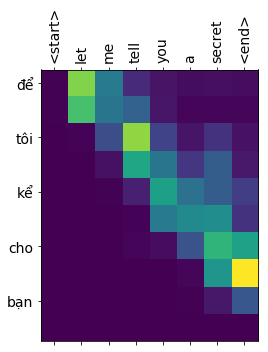


Input:  <start> there is a problem with community meetings <end>
Groundtruth:  <start> có một vần đề trong những cuộc họp cộng đồng <end>
Translation:  <start> có một vấn đề với cộng đồng <end>
Bleu Score:  55.73021304462805


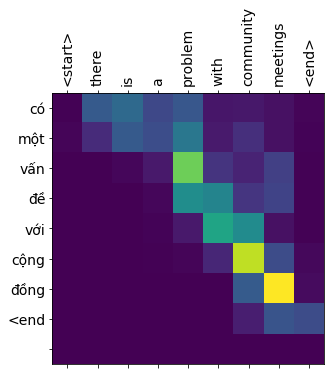


Input:  <start> entrepreneurs never come and they never tell you in a public meeting what they want to do with their own money what opportunity they have identified <end>
Groundtruth:  <start> những doanh nhân chẳng bao giờ đến dự và họ chẳng đời nào cho bạn biết trong buổi họp cộng đồng cái họ muốn làm với tiền của mình cái cơ hội mà họ mới tìm ra <end>
Translation:  <start> các doanh nghiệp không bao giờ đến và họ không bao giờ nói với bạn trong cuộc thi hành những gì họ muốn làm với những gì mà họ có thể xác định <end>
Bleu Score:  43.325862984864585

Input:  <start> so planning has this blind spot <end>
Groundtruth:  <start> vậy nên hoạch định có một điểm mù này <end>
Translation:  <start> vì vậy dự định có thể hiện tượng này mù này <end>
Bleu Score:  53.84615384615385

Input:  <start> the smartest people in your community you dont even know because they dont come to your public meetings <end>
Groundtruth:  <start> những người thông thái nhất trong cộng đồng bạn chẳng bao giờ biết

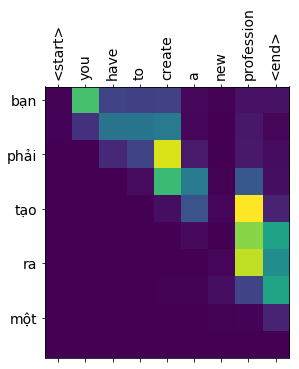


Input:  <start> the profession is the family doctor of enterprise the family doctor of business who sits with you in your house at your kitchen table at the cafe and helps you find the resources to transform your passion into a way to make a living <end>
Groundtruth:  <start> một chuyên ngành mới như một bác sỹ gia đình cho doanh nghiệp bác sỹ gia đình cho công việc làm ăn người ngồi với bạn trong nhà bạn tại bàn cơm trong bếp tại quán cà phê và giúp bạn tìm ra những nguồn tài nguyên để biến khát vọng của bạn thành một phương cách kiếm sống <end>
Translation:  <start> nghề nghiệp là gia đình là gia đình là các nhà kinh doanh gia đình kinh doanh gia đình kinh doanh trong nhà bạn ở nhà bếp ở nhà tắm ở nhà tắm ở nhà tắm ở nhà tắm ở nhà tắm ở nhà tắm ở nhà tắm ở nhà tắm ở nhà tắm ở nhà tắm ở nhà tắm
Bleu Score:  18.0327868852459

Input:  <start> i started this as a tryout in esperance in western australia <end>
Groundtruth:  <start> tôi đã bắt đầu như một sự thử nghiệm tại esperance tây ú

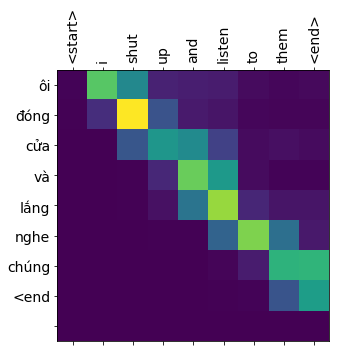


Input:  <start> so so the government says do it again <end>
Groundtruth:  <start> vậy nên vậy nên chính phủ nói với tôi cứ làm tiếp nhé <end>
Translation:  <start> vậy nên chính phủ đã nói nó lại <end>
Bleu Score:  42.45714617988433


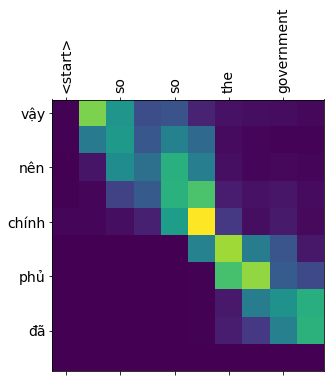


Input:  <start> weve done it in 300 communities around the world <end>
Groundtruth:  <start> chúng tôi đã làm thế tại 300 cộng đồng trên khắp thế giới <end>
Translation:  <start> chúng tôi đã làm việc ở đó 300 người ở khắp thế giới <end>
Bleu Score:  66.66666666666666

Input:  <start> we have helped to start 40 000 businesses <end>
Groundtruth:  <start> chúng tôi đã giúp khởi động 40 000 công việc làm ăn <end>
Translation:  <start> chúng ta đã giúp bắt đầu 40 000 doanh nghiệp <end>
Bleu Score:  49.37810061861915

Input:  <start> there is a new generation of entrepreneurs who are dying of solitude <end>
Groundtruth:  <start> có một thế hệ doanh nhân mới những người đang kiệt quệ vì sự cô lập <end>
Translation:  <start> có một thế hệ mới của những doanh nghiệp mới đang sống đang duy trì sự tồn tại một sự đơn độc <end>
Bleu Score:  45.83333333333333

Input:  <start> peter drucker one of the greatest management consultants in history died age 96 a few years ago <end>
Groundtruth:  <start>

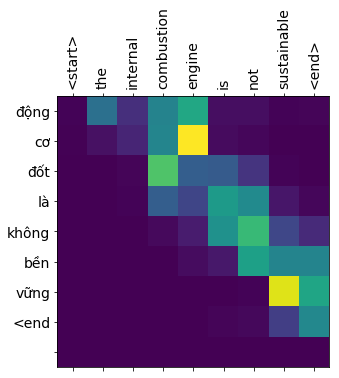


Input:  <start> freon way of maintaining things is not sustainable <end>
Groundtruth:  <start> đường lối freon để lưu trữ các thứ là không bền vững <end>
Translation:  <start> cách nào để có thể duy trì những thứ không phải là bền vững <end>
Bleu Score:  50.0

Input:  <start> what we have to look at is at how we feed cure educate transport communicate for seven billion people in a sustainable way <end>
Groundtruth:  <start> cái mà chúng ta phải nhìn đến đó là chúng ta làm thế nào để nuôi dưỡng chữa trị giáo dục di chuyển và liên lạc cho 7 tỉ người theo hướng bền vững <end>
Translation:  <start> chúng ta phải nhìn vào là cách chữa trị cứu chữa trị gia đình giao tiếp với vận tốc 7 tỉ người trong một cách bền vững <end>
Bleu Score:  37.922794726789284

Input:  <start> the technologies do not exist to do that <end>
Groundtruth:  <start> không có công nghệ nào làm được điều đó <end>
Translation:  <start> công nghệ không tồn tại để làm điều đó <end>
Bleu Score:  72.72727272727273

Input:  <

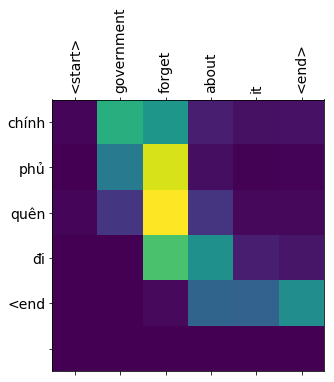


Input:  <start> it will be entrepreneurs and theyre doing it now <end>
Groundtruth:  <start> đó sẽ là các danh nhân và họ đang thực hiện điều đó ngay hiện nay <end>
Translation:  <start> nó sẽ trở thành những nhà doanh nghiệp và họ đang làm việc đó <end>
Bleu Score:  38.60923948807605

Input:  <start> theres a lovely story that i read in a futurist magazine many many years ago <end>
Groundtruth:  <start> có một câu chuyện rất vui mà tôi đọc được trên một tờ tạp chí vị lai nhiều năm về trước <end>
Translation:  <start> có một câu chuyện đáng chú ý tôi đọc trong một tạp chí rất nhiều năm trước <end>
Bleu Score:  63.9598211788758

Input:  <start> there was a group of experts who were invited to discuss the future of the city of new york in 1860 <end>
Groundtruth:  <start> có một nhóm chuyên gia được mời đến để thảo luận về tương lai của thành phố new york năm 1860 <end>
Translation:  <start> có một nhóm chuyên gia những người đã mời tham gia về tương lai của thành phố new york <end>
Bleu

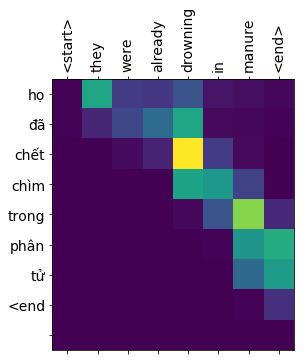


Input:  <start> so 1860 they are seeing this dirty technology that is going to choke the life out of new york <end>
Groundtruth:  <start> vậy nên vào năm 1860 họ nhìn thấy cái công nghệ nhem nhuốc này cái mà làm cho cuộc sống ở thành phố new york ngộp thở <end>
Translation:  <start> vì vậy là chúng tôi đang thấy những công nghệ thuỷ tinh này sẽ bị nghẹn lại cuộc sống tại new york <end>
Bleu Score:  37.213749198570774

Input:  <start> so what happens in 40 years time in the year 1900 in the united states of america there were 1 001 car manufacturing companies 1 001 <end>
Groundtruth:  <start> vậy điều gì đã xảy ra trong vòng 40 năm tới thời điểm 1900 tại mỹ có khoảng 1 001 công ty sản xuất xe hơi 1 001 <end>
Translation:  <start> vì vậy thì có thể trong năm 40 năm 1900 hơn ở mỹ có 1 chiếc xe sản xuất 1 ngân hàng <end>
Bleu Score:  45.43004567916529

Input:  <start> the idea of finding a different technology had absolutely taken over and there were tiny tiny little factories in backwate

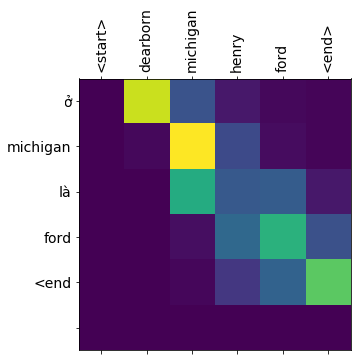


Input:  <start> however there is a secret to work with entrepreneurs <end>
Groundtruth:  <start> tuy nhiên có một bí mật để làm việc với các doanh nhân <end>
Translation:  <start> tuy nhiên có một bí mật để làm việc với doanh nhân <end>
Bleu Score:  93.10627797040229

Input:  <start> first you have to offer them confidentiality <end>
Groundtruth:  <start> trước tiên bạn phải mang đến cho họ sự bảo mật <end>
Translation:  <start> đầu tiên bạn phải đưa họ <end>
Bleu Score:  40.14460713892427


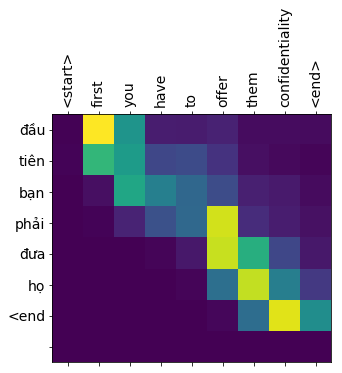


Input:  <start> otherwise they dont come and talk to you <end>
Groundtruth:  <start> không thì họ sẽ chẳng tìm đến mà nói chuyện với bạn <end>
Translation:  <start> nếu không họ không đến và nói chuyện với bạn <end>
Bleu Score:  63.48612936679605

Input:  <start> then you have to offer them absolute dedicated passionate service to them <end>
Groundtruth:  <start> sau đó bạn phải mang đến cho họ một dịch vụ tuyệt đối riêng biệt và say mê <end>
Translation:  <start> sau đó bạn phải đưa chúng có thể đưa ra những điều trị sức khoẻ rất tốt cho họ <end>
Bleu Score:  38.095238095238095

Input:  <start> and then you have to tell them the truth about entrepreneurship <end>
Groundtruth:  <start> và sau đó bạn phải nói với họ sự thật về kinh doanh <end>
Translation:  <start> và bạn phải nói với họ sự thật về kinh doanh <end>
Bleu Score:  85.74039191604413

Input:  <start> the smallest company the biggest company has to be capable of doing three things beautifully the product that you want to sel

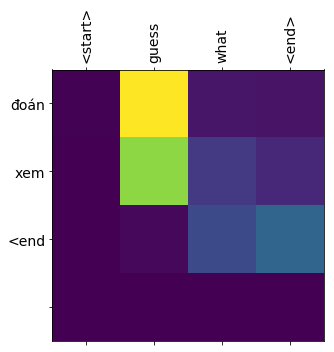


Input:  <start> we have never met a single human being in the world who can make it sell it and look after the money <end>
Groundtruth:  <start> chúng ta chưa bao giờ gặp một cá nhân nào trên thế giới người mà vừa có thể làm ra bán nó và quản lí tiền bạc cùng lúc <end>
Translation:  <start> chúng ta chưa bao giờ gặp ai đó trên thế giới mà có thể làm bán nó và nhìn vào tiền <end>
Bleu Score:  58.34005237938401

Input:  <start> it doesnt exist <end>
Groundtruth:  <start> điều đó không tồn tại <end>
Translation:  <start> nó không tồn tại <end>
Bleu Score:  70.5401437408845


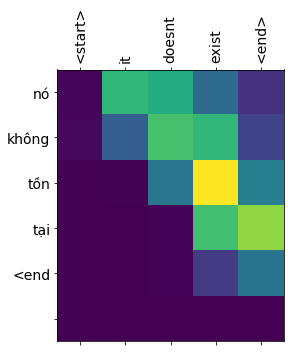


Input:  <start> this person has never been born <end>
Groundtruth:  <start> nhân vật này chưa bao giờ được sinh ra <end>
Translation:  <start> người này không được sinh ra <end>
Bleu Score:  51.546695909322914


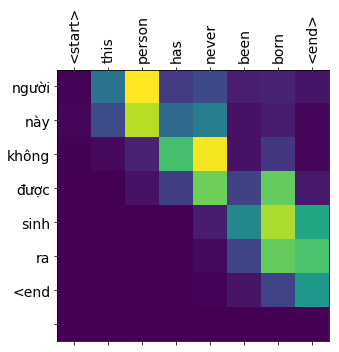


Input:  <start> weve done the research and we have looked at the 100 iconic companies of the world carnegie westinghouse edison ford all the new companies google yahoo <end>
Groundtruth:  <start> chúng tôi đã làm một nghiên cứu và xem xét 100 công ty tiêu biểu trên thế giới carnegie westinghouse edison ford tất cả công ty mới google yahoo <end>
Translation:  <start> chúng tôi đã nghiên cứu và chúng tôi đã tìm thấy 100 công ty hình ảnh của thế giới hội thảo ted 2007 jim t tất cả các công ty google mới <end>
Bleu Score:  55.88235294117647

Input:  <start> theres only one thing that all the successful companies in the world have in common only one none were started by one person <end>
Groundtruth:  <start> chỉ có một điều mà tất cả mọi công ty thành công trên thế giới đều có chỉ một mà thôi đó là không một công ty nào bắt đầu chỉ với một người <end>
Translation:  <start> chỉ có một điều mà tất cả các công ty thành công trong thế giới có những người không được bắt đầu bằng một người <end>

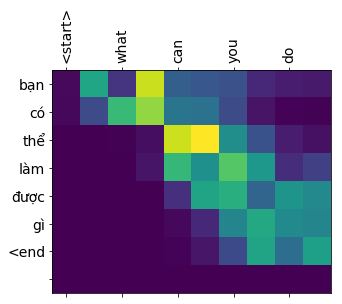


Input:  <start> okay can you sell it can you look after the money <end>
Groundtruth:  <start> okay bạn có thể bán nó không bạn có thể quản lí tiền bạc không <end>
Translation:  <start> được rồi bạn có thể bán nó có thể bạn có thể nhìn vào tiền <end>
Bleu Score:  64.70588235294117

Input:  <start> quot oh no i cannot do this would you like me to find you somebody <end>
Groundtruth:  <start> quot oh không tôi không thể làm được điều này bạn có muốn tôi tìm ai khác cho bạn không <end>
Translation:  <start> quot ồ không tôi không thể làm điều này sẽ như thế này như thế này như thế này như thế này như thế này như thế này như thế này như thế này như thế này như thế này như thế này như thế này như thế này như thế này như thế này như thế này như thế
Bleu Score:  14.75409836065574

Input:  <start> we activate communities <end>
Groundtruth:  <start> chúng tôi kích hoạt những cộng đồng <end>
Translation:  <start> chúng tôi kích hoạt cộng đồng <end>
Bleu Score:  88.24969025845955


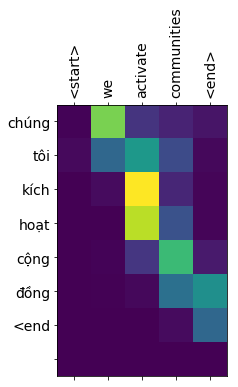


Input:  <start> we have groups of volunteers supporting the enterprise facilitator to help you to find resources and people and we have discovered that the miracle of the intelligence of local people is such that you can change the culture and the economy of this community just by capturing the passion the energy and imagination of your own people <end>
Groundtruth:  <start> chúng tôi có những nhóm tình nguyện viên trợ giúp cho enterprise facilitator họ giúp tìm kiếm những nguồn tài nguyên và con người và chúng tôi khám phá ra rằng cái phép lạ từ trí thông minh của người bản địa như cái gì đó giống như là bạn có thể thách thức nền văn hoá và kinh tế của cộng đồng này chỉ bằng cách nắm được cái khát vọng nguồn năng lượng và trí tưởng tượng như thể của người dân của bạn <end>
Translation:  <start> những nhóm tình nguyện viên ủng hộ ủng hộ ủng hộ ủng hộ ủng hộ lợi nhuận để giúp đỡ các bạn có thể tìm thấy nguồn lực và mọi người và chúng tôi đã khám phá ra rằng phép màu của trí tuệ của ngư

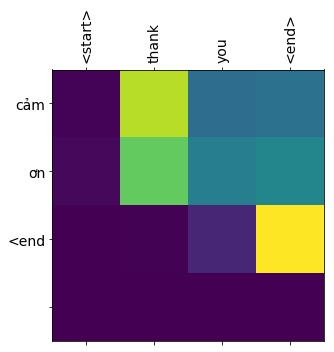


Input:  <start> before march 2011 i was a photographic retoucher based in new york city <end>
Groundtruth:  <start> cho đến tháng ba 2011 tôi làm thợ chỉnh sửa ảnh tại thành phố new york <end>
Translation:  <start> trước khi tôi đoạt một năm làm việc theo đuổi theo học thành phố new york <end>
Bleu Score:  44.44444444444444

Input:  <start> were pale gray creatures <end>
Groundtruth:  <start> chúng tôi là những sinh vật xanh xao <end>
Translation:  <start> chúng ta là một con số loài vật xám <end>
Bleu Score:  45.45454545454545

Input:  <start> we hide in dark windowless rooms and generally avoid sunlight <end>
Groundtruth:  <start> ẩn trong bóng tối căn phòng không cửa sổ và nói chung là tránh ánh nắng mặt trời <end>
Translation:  <start> chúng ta giấu đi dưới màu tối màu và thường tránh được ánh sáng mặt trời <end>
Bleu Score:  39.77063630286087

Input:  <start> we make skinny models skinnier perfect skin more perfect and the impossible possible and we get criticized in the press al

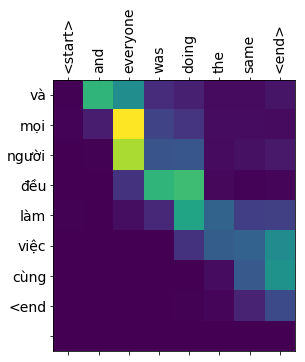


Input:  <start> they were collecting them up and handing them in to various places around the different towns for safekeeping <end>
Groundtruth:  <start> họ đã thu thập và bàn giao chúng để bảo quản ở những nơi xung quanh các thị xã <end>
Translation:  <start> họ đang thu thập những cái và chúng làm ở nhiều nơi khác nhau trên những thị trấn khác nhau <end>
Bleu Score:  50.0

Input:  <start> now it wasnt until this point that i realized that these photos were such a huge part of the personal loss these people had felt <end>
Groundtruth:  <start> không phải đến thời điểm ấy mà tôi mới nhận ra những tấm hình này đúng là một phần mất mát cá nhân rất lớn ở những người này <end>
Translation:  <start> bây giờ nó không phải cho đến khi tôi nhận ra rằng những bức ảnh này là một phần lớn của những kẻ mất đi những người này đã cảm thấy <end>
Bleu Score:  54.54545454545454

Input:  <start> as they had run from the wave and for their lives absolutely everything they had everything had to be left b

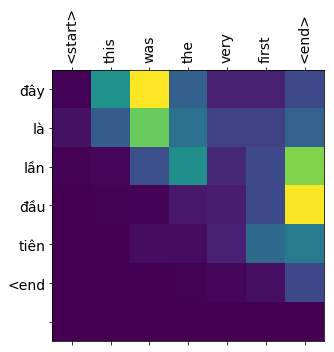


Input:  <start> not terribly damaged but where the water had caused that discoloration on the girls face had to be repaired with such accuracy and delicacy <end>
Groundtruth:  <start> không bị hư hỏng trầm trọng nhưng chỗ bị thấm nước khiến đổi màu khuôn mặt cô gái phải được sửa chữa với độ chính xác và tinh vi cao <end>
Translation:  <start> không phải vô cùng vô hại nhưng khi nước đã gây ra rằng những con cái này <end>
Bleu Score:  15.931211137222773

Input:  <start> otherwise that little girl isnt going to look like that little girl anymore and surely thats as tragic as having the photo damaged <end>
Groundtruth:  <start> nếu không bé gái trong hình sẽ không còn trông giống em nữa và chắc chắn điều đó cũng tồi tệ như việc tấm ảnh bị hư hại vậy <end>
Translation:  <start> nếu không có chút cô bé sẽ không quan sát giống như cô bé gái này và chắc chắn là như bi kịch bị mắc bị tổn thương <end>
Bleu Score:  45.136751355826945

Input:  <start> over time more photos came in thankfully and

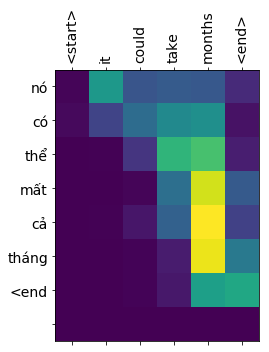


Input:  <start> the kimono in this shot pretty much had to be hand drawn or pieced together picking out the remaining parts of color and detail that the water hadnt damaged <end>
Groundtruth:  <start> chiếc kimono trong bức ảnh này gần như phải được vẽ lại bằng tay hoặc chắp ghép từ các phần màu sắc và chi tiết còn lại chưa bị nước làm hư hại <end>
Translation:  <start> người hoàn toàn là một người bị thu hút hoặc bị chia rẽ những con phần còn lại của các loại hình tròn màu và chi tiết mà các nước không hề bị tổn thương <end>
Bleu Score:  35.13513513513514

Input:  <start> it was very time consuming <end>
Groundtruth:  <start> nó rất tốn thời gian <end>
Translation:  <start> đó là thời gian rất nhiều thời gian <end>
Bleu Score:  50.0


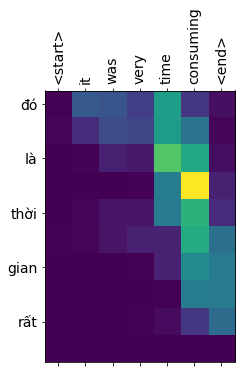


Input:  <start> now all these photos had been damaged by water submerged in salt water covered in bacteria in sewage sometimes even in oil all of which over time is going to continue to damage them so hand cleaning them was a huge part of the project <end>
Groundtruth:  <start> bấy giờ tất cả những hình ảnh này đã bị nước làm hư hại bị nhấn chìm trong nước muối bị bao phủ bởi vi khuẩn trong nước thải đôi khi cả trong dầu suốt một quãng thời gian nên chúng sẽ tiếp tục thêm hư hại thế nên lau sạch chúng là một phần rất lớn của dự án <end>
Translation:  <start> tất cả những bức ảnh này bị huỷ hoại nước bị đổ nước muối trong nước trong nước trong nước trong nước trong nước trong nước trong nước trong nước trong nước trong nước trong nước trong nước trong nước trong nước trong nước trong nước trong nước trong nước trong nước trong nước trong nước trong nước trong nước
Bleu Score:  24.190332751996788

Input:  <start> we couldnt retouch the photo unless it was cleaned dry and reclaimed <end>

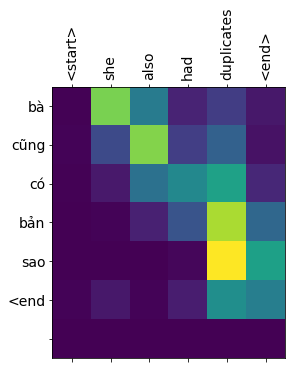


Input:  <start> areas like her husband and her face which otherwise would have been completely impossible to fix we could just put them together in one good photo and remake the whole photo <end>
Groundtruth:  <start> nếu không những chỗ như chồng và khuôn mặt cô sẽ không bao giờ có thể được khắc phục chỉ có thể đặt họ gần nhau trong một bức ảnh lành khác và làm lại toàn bộ bức hình <end>
Translation:  <start> các khu vực như thế chồng của cô ấy và mặt mình không phải là hoàn toàn không thể sửa chữa chúng ta có thể đưa chúng lại với nhau trong một bức ảnh tốt và hành động của mình <end>
Bleu Score:  47.61904761904761

Input:  <start> when she collected the photos from us she shared a bit of her story with us <end>
Groundtruth:  <start> khi nhận lại các bức ảnh từ chúng tôi cô ấy đã chia sẻ một chút câu chuyện của mình <end>
Translation:  <start> khi cô ấy thu thập những bức ảnh từ những bức ảnh của mình từ những người khác với chúng tôi <end>
Bleu Score:  52.17391304347826

Input:  <s

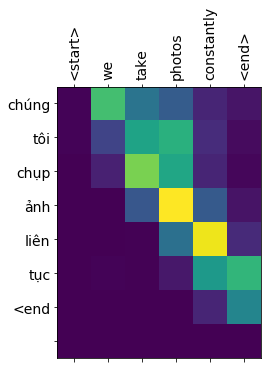


Input:  <start> a photo is a reminder of someone or something a place a relationship a loved one <end>
Groundtruth:  <start> mỗi bức ảnh gợi nhắc về ai đó hoặc một cái gì đó một nơi một mối quan hệ một người thân yêu <end>
Translation:  <start> một bức ảnh là một lời nhắc nhở của một người hay một người có một mối quan hệ tình yêu một người vô cùng một người vô cùng một người vô cùng một người vô cùng một người vô cùng một người vô cùng một người vô cùng một người vô cùng một người vô cùng một người vô
Bleu Score:  21.311475409836063

Input:  <start> theyre our memory keepers and our histories the last thing we would grab and the first thing youd go back to look for <end>
Groundtruth:  <start> chúng là những vật lưu giữ kỉ niệm và câu chuyện của chúng ta là điều cuối cùng chúng ta còn bám víu lấy và cũng là thứ đầu tiên ta quay lại kiếm tìm <end>
Translation:  <start> chúng là sự thụ thai và lịch sử của chúng ta sẽ cầm lấy và điều đầu tiên bạn quay trở lại <end>
Bleu Score:  36.361113

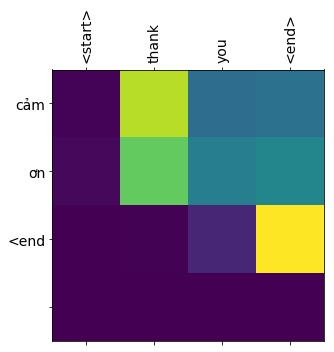


Input:  <start> im 150 feet down an illegal mine shaft in ghana <end>
Groundtruth:  <start> tôi ở độ sâu gần 50m dưới 1 hầm mỏ bất hợp pháp tại ghana <end>
Translation:  <start> tôi 150 người xuống một cái mà tôi có thể chất ở ghana <end>
Bleu Score:  29.17244396809825

Input:  <start> the air is thick with heat and dust and its hard to breathe <end>
Groundtruth:  <start> không khí đặc quánh bụi và hơi nóng và rất khó thở <end>
Translation:  <start> không khí dày và nhiệt độ và nó rất khó để thở <end>
Bleu Score:  64.28571428571429

Input:  <start> i can feel the brush of sweaty bodies passing me in the darkness but i cant see much else <end>
Groundtruth:  <start> tôi có thể cảm nhận sự va chạm từ những thân thể bóng nhẫy mồ hôi lướt qua trong bóng tối nhưng chẳng thể thấy gì hơn <end>
Translation:  <start> tôi có thể cảm giác đánh răng của bò trong trại giam giữ tôi trong bóng tối nhưng tôi không thể nhìn thấy nhiều thứ khác <end>
Bleu Score:  41.353540473101575

Input:  <start> i he

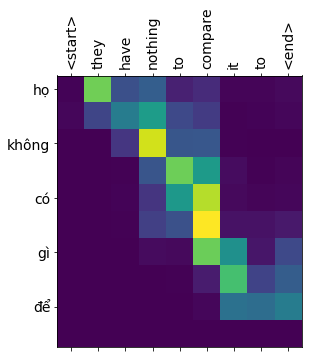


Input:  <start> when these villagers claimed their freedom the slaveholders burned down all of their houses <end>
Groundtruth:  <start> khi người dân làng này đòi tự do những chủ nô đốt sạch nhà của họ <end>
Translation:  <start> khi những người dân làng nghĩ rằng sự tự do của mình đã cháy bị bỏ rơi khỏi tất cả nhà <end>
Bleu Score:  47.82608695652174

Input:  <start> i mean these people had nothing and they were so petrified they wanted to give up but the woman in the center rallied for them to persevere and abolitionists on the ground helped them get a quarry lease of their own so that now they do the same back breaking work but they do it for themselves and they get paid for it and they do it in freedom <end>
Groundtruth:  <start> những người này không có gì họ chết điếng họ muốn đầu hàng nhưng người phụ nữ ở giữa trấn tĩnh và kêu gọi mọi người kiên trì và những người theo chủ nghĩa bãi nô tại hiện trường giúp họ lấy được hợp đồng cho thuê mỏ đá của chính mình để giờ đây họ vẫn làm

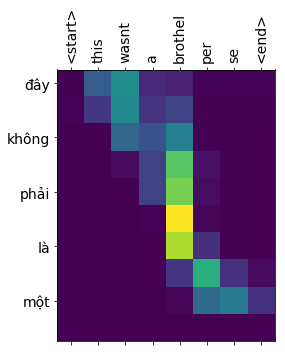


Input:  <start> it was more like a restaurant <end>
Groundtruth:  <start> nó giống 1 nhà hàng hơn <end>
Translation:  <start> nó giống như một nhà hàng <end>
Bleu Score:  75.0


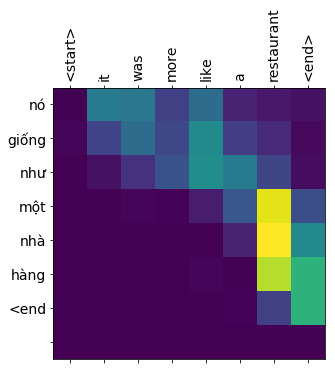


Input:  <start> cabin restaurants as theyre known in the trade are venues for forced prostitution <end>
Groundtruth:  <start> những nhà hàng phân buồng như được biết đến trong ngành là những địa điểm của nạn mại dâm cưỡng ép <end>
Translation:  <start> nhà hàng nhà tù là họ được biết trong thương mại đang được những người di chuyển được tiếp cận bị buộc phải làm nghệ thuật <end>
Bleu Score:  35.71428571428572

Input:  <start> each has small private rooms where the slaves women along with young girls and boys some as young as seven years old are forced to entertain the clients encouraging them to buy more food and alcohol <end>
Groundtruth:  <start> mỗi nơi có phòng riêng nhỏ nơi các nô lệ phụ nữ cùng trẻ em trai và gái một số mới 7 tuổi bị buộc giải khuây cho khách hàng dụ họ mua thêm rượu và đồ ăn <end>
Translation:  <start> mỗi người có một căn phòng nhỏ mà các tổ chức phụ nữ cùng với những bé gái trẻ em bé gái nhỏ như là bảy năm bị buộc phải giải trí dạy khách hàng triệu đô la và m

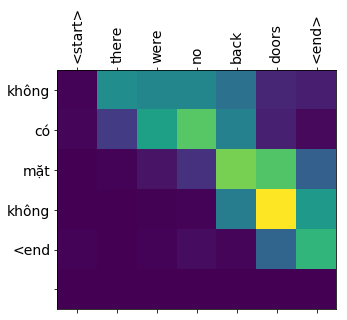


Input:  <start> there were no windows large enough to climb through <end>
Groundtruth:  <start> chẳng có cửa sổ đủ lớn mà chui lọt <end>
Translation:  <start> không có cửa hàng loạt để có thể leo lên <end>
Bleu Score:  33.33333333333333

Input:  <start> these people have no escape at all and as we take in such a difficult subject its important to note that slavery including sex trafficking occurs in our own backyard as well <end>
Groundtruth:  <start> những người này không có lối thoát nào khi ta đề cập về chủ đề khó khăn như thế cần nhớ rằng nô lệ bao gồm nô lệ của nạn mua bán tình dục cũng xảy ra tại nơi chúng ta đang sống <end>
Translation:  <start> những người này không có cách nào để tránh khỏi tình huống khó khăn để quan trọng để ghi nhớ rằng thời điểm của thời gian bao gồm cả buôn lậu tình trạng ở nhà sân sau khi chúng ta <end>
Bleu Score:  42.11950670089627

Input:  <start> tens of hundreds of people are enslaved in agriculture in restaurants in domestic servitude and the list

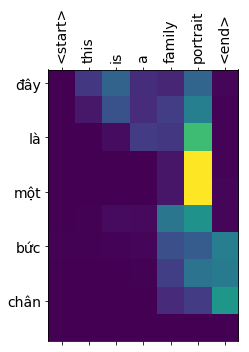


Input:  <start> the dyed black hands are the father while the blue and red hands are his sons <end>
Groundtruth:  <start> đôi tay nhuộm đen là người cha những bàn tay xanh và đỏ là con trai ông ấy <end>
Translation:  <start> loại đen là người cha là người cha màu xanh và đỏ là những con trai <end>
Bleu Score:  64.62728399214892

Input:  <start> they mix dye in these big barrels and they submerge the silk into the liquid up to their elbows but the dye is toxic <end>
Groundtruth:  <start> họ trộn thuốc nhuộm trong những thùng lớn và nhúng lụa vào dung dịch đó ngập đến khuỷ tay dù thuốc nhuộm rất độc <end>
Translation:  <start> chúng trộn màu nhuộm màu đỏ này và đôi khi nhấn chìm trong chuỗi chảy vào trong những cơn gió và thuốc lá tơ màu mỡ <end>
Bleu Score:  32.142857142857146

Input:  <start> my interpreter told me their stories <end>
Groundtruth:  <start> người phiên dịch của tôi kể chuyện của họ <end>
Translation:  <start> phiên dịch của tôi bảo tôi kể chuyện của họ <end>
Bleu Score

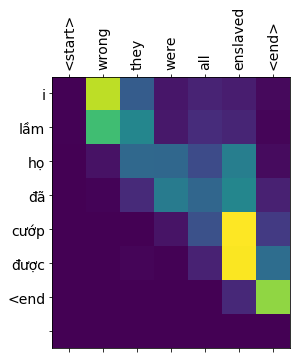


Input:  <start> children are taken from their families and trafficked and vanished and theyre forced to work endless hours on these boats on the lake even though they do not know how to swim <end>
Groundtruth:  <start> trẻ em bị đưa khỏi gia đình buôn bán và mất tích và bị bắt làm việc không ngừng nghỉ trên những con thuyền này ở hồ này dù chúng không biết bơi <end>
Translation:  <start> trẻ em bị lấy từ gia đình và bị biến mất và bị biến mất những giờ những chiếc thuyền này trên hồ nước này thậm chí không biết cách bơi <end>
Bleu Score:  57.042056977262575

Input:  <start> this young child is eight years old <end>
Groundtruth:  <start> đứa trẻ này 8 tuổi <end>
Translation:  <start> đứa trẻ em bé 8 tuổi <end>
Bleu Score:  75.0


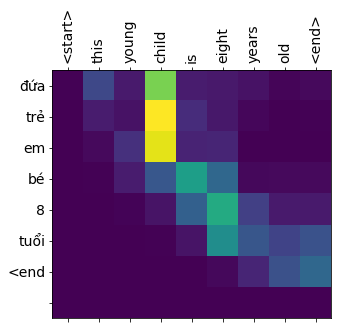


Input:  <start> he was trembling when our boat approached frightened it would run over his tiny canoe <end>
Groundtruth:  <start> em run rẩy khi thuyền của chúng tôi đến gần cứ sợ thuyền đè qua cái canoe bé xíu của em <end>
Translation:  <start> ông ấy đã rơi vào thuyền của chúng ta sẽ sợ hãi nó sẽ chạy qua chiếc taxi của mình <end>
Bleu Score:  34.74774677339216

Input:  <start> he was petrified he would be knocked in the water <end>
Groundtruth:  <start> cậu bé khiếp đảm vì sợ rơi xuống nước <end>
Translation:  <start> ông ấy sợ ngã sợ hãi khi anh ta bị đánh rơi vào nước <end>
Bleu Score:  31.25

Input:  <start> the skeletal tree limbs submerged in lake volta often catch the fishing nets and weary frightened children are thrown into the water to untether the lines <end>
Groundtruth:  <start> những cành cây gãy tụ vào hồ volta thường vướng vào lưới đánh cá và những đứa trẻ vừa mệt lử vừa sợ hãi bị đẩy xuống nước để gỡ lưỡi câu <end>
Translation:  <start> cái phao bơi trên eo biển thư

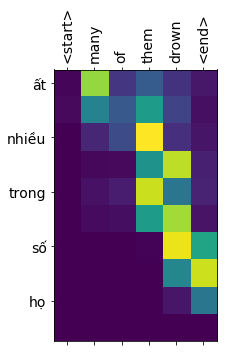


Input:  <start> for as long as he can recall hes been forced to work on the lake <end>
Groundtruth:  <start> những gì cậu bé nhớ được là em bị bắt làm việc ở hồ <end>
Translation:  <start> khi mà chúng ta có thể nhớ là ông ta buộc phải làm việc trên hồ <end>
Bleu Score:  38.88888888888889

Input:  <start> terrified of his master he will not run away and since hes been treated with cruelty all his life he passes that down to the younger slaves that he manages <end>
Groundtruth:  <start> quá sợ người chủ em không dám chạy trốn và vì bị đối xử tàn tệ từ nhỏ em tiếp diễn điều đó xuống những nô lệ nhỏ hơn mà em quản lý <end>
Translation:  <start> sợ hãi của ông ta sẽ không chạy trốn và kể từ anh ta bị đối xử với nhau với cuộc đời cậu ấy đã vượt qua những người dân bị cướp đi <end>
Bleu Score:  37.142857142857146

Input:  <start> i met these boys at five in the morning when they were hauling in the last of their nets but they had been working since 1 a m <end>
Groundtruth:  <start> tôi gặp 

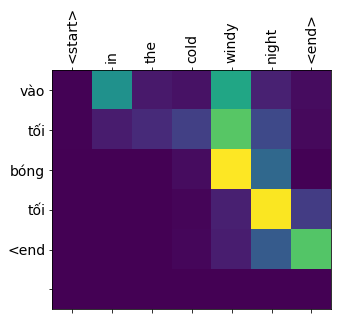


Input:  <start> and its important to note that these nets weigh more than a thousand pounds when theyre full of fish <end>
Groundtruth:  <start> cần lưu ý rằng những chiếc lưới này nặng gần 500kgs khi chúng đầy cá <end>
Translation:  <start> và quan trọng để ý nghĩa những màn này thấp hơn một ngàn pound khi chúng được che phủ <end>
Bleu Score:  33.33333333333333

Input:  <start> i want to introduce you to kofi <end>
Groundtruth:  <start> tôi muốn giới thiệu kofi với bạn <end>
Translation:  <start> tôi muốn giới thiệu với bạn đến cambridge <end>
Bleu Score:  80.0


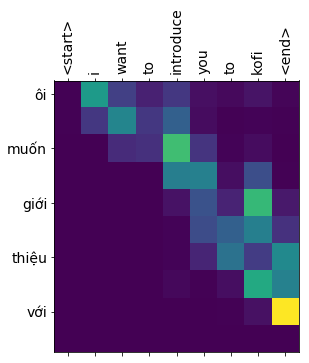


Input:  <start> kofi was rescued from a fishing village <end>
Groundtruth:  <start> kofi được cứu từ 1 làng chài <end>
Translation:  <start> kofi annan đã được từ một ngôi nhà vô tội <end>
Bleu Score:  41.66666666666667

Input:  <start> i met him at a shelter where free the slaves rehabilitates victims of slavery <end>
Groundtruth:  <start> tôi gặp cậu bé ở khu cứu trợ mà tổ chức giải phóng nô lệ phục hồi các nạn nhân bị nô lệ <end>
Translation:  <start> tôi gặp ông ở nơi trú ẩn nơi trú ẩn nô lệ nô lệ nô lệ <end>
Bleu Score:  33.89047890027252

Input:  <start> here hes seen taking a bath at the well pouring big buckets of water over his head and the wonderful news is as you and i are sitting here talking today kofi has been reunited with his family and whats even better his family has been given tools to make a living and to keep their children safe <end>
Groundtruth:  <start> nơi đây em đang tắm ở giếng dội những gáo nước to lên đầu và tin tuyệt vời là khi bạn và tôi ngồi nói chuyện 

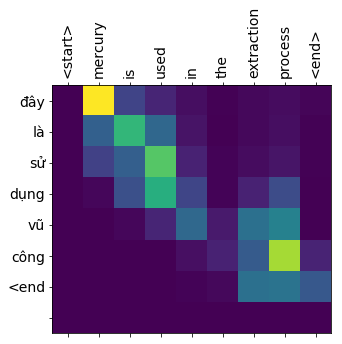


Input:  <start> these miners are enslaved in a mine shaft in another part of ghana <end>
Groundtruth:  <start> những người thợ mỏ này bị bắt làm nô lệ trong hầm mỏ ở 1 khu vực khác của ghana <end>
Translation:  <start> những mỏ này đã được làm trong một trong một phần khác ở ghana <end>
Bleu Score:  42.95557992443577

Input:  <start> when they came out of the shaft they were soaking wet from their own sweat <end>
Groundtruth:  <start> khi ra khỏi hầm người họ ướt sũng bởi mồ hôi của chính mình <end>
Translation:  <start> khi họ ra khỏi khối lượng chúng sẽ là những kẻ bị béo không béo từ ruột của họ <end>
Bleu Score:  33.33333333333333

Input:  <start> i remember looking into their tired bloodshot eyes for many of them had been underground for 72 hours <end>
Groundtruth:  <start> tôi vẫn nhớ khi nhìn vào đôi mắt đỏ quạch mệt mỏi của họ vì nhiều người đã ở dưới lòng đất tới 72 giờ <end>
Translation:  <start> tôi nhớ mình nhìn chằm chằm chằm chằm chằm chằm chằm chằm chằm chằm chằm chằm c

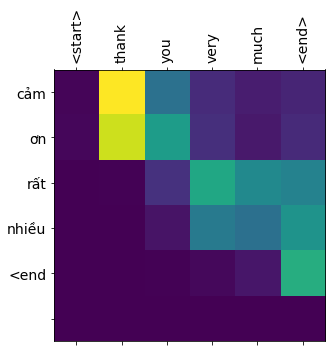

In [62]:
translation_result = []
for i in range(len(pairs_2)):
  en_sentence = pairs_2[i][0].strip("<start>").strip("<end>").strip()
  vi_result, en_sentence, attention_plot = evaluate(en_sentence, encoder, decoder, inp_lang, targ_lang, max_length_inp, max_length_targ)
  vi_result = '<start> ' + vi_result.strip()
  vi_groundtruth = pairs_2[i][1]
  bleu_score = compute_bleu([[vi_groundtruth.split()]], [vi_result.split()], max_order=1)[0]*100
  print('\nInput: ', en_sentence)
  print('Groundtruth: ', vi_groundtruth)
  print('Translation: ', vi_result)
  print('Bleu Score: ', bleu_score)
  if len(vi_result.split(' ')) <= 10:
    attention_plot = attention_plot[:len(vi_result.split(' ')), :len(en_sentence.split(' '))]
    plot_attention(attention_plot, en_sentence.split(' '), vi_result.strip('<start> ').split(' '))
  translation_result.append([en_sentence, vi_groundtruth, vi_result, bleu_score, attention_plot])

**Tính bleu score trung bình trên tập Test:**

In [63]:
bleu_score_list = []
for i in range(len(translation_result)):
  bleu_score_list.append(translation_result[i][3])

mean_bleu_score = sum(bleu_score_list)/len(bleu_score_list)
print("Average Bleu Score: ", mean_bleu_score)

Average Bleu Score:  49.46608422952518
